## shNfkb components
1/28/26 - Data generated from shNfkb single hairpin experiments (canonical Nfkb); data submitted by Jason/ERH/Selena/CHP on 1/19/2024

Analyze global run on cellranger v6 data and create h5_ad files for further analysis

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import pickle

import math
import matplotlib
from matplotlib import pyplot as plt

from pathlib import Path
import anndata

In [2]:
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "Arial"

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
np.random.seed(1573)   #fix so we can reproduce later

In [4]:
Path("./figures").mkdir(parents=True, exist_ok=True) # generate figures here
Path("./write").mkdir(parents=True, exist_ok=True) # write h5ad here

In [5]:
library = ["1659-Fosl2.226","1660-Fosl2.752","1661-Fhl2.467","1662-Fhl2.179","1663-Myc.989","1664-Myc.1389","1665-Yap1.735","1666-Yap1.2847","1667-Atf4.1383","1668-Atf4.536","1669-Maff.85","1670-Maff.587","1671-Nfkb2.152","1672-Nfkb2.534","1673-Relb.286","1674-Relb.1795","1675-Onecut2.1799","1676-Onecut2.2361","1810-Slc4a11.541","1934-Slc4a11.1966","1811-Itga2.672","1812-Itga2.204","1998-Cldn4-1013","1999-Cldn4-951","2113-Lif.440","2114-Lif.1890","2115-Fosl1.1401","2116-Fosl1.699","2117-Nfkb1.2331","2118-Nfkb1.3737","shRenilla",'JCP628-shIkbkg-1.2526','JCP629-shIkbkg-2.2984',
           'JCP618-shRela-1.1202','JCP621-shRela-4.1182','JCP623-shRel-1.1868',
           'JCP625-shRel-3.342','Ikbsr-FLAG',]

## Load adata object

In [6]:
adata = anndata.read_h5ad('write/Nfkb_combined.h5ad')

In [7]:
adata.obs['Group'].value_counts()

Group
Cre             6186
shRenilla       5386
IkbSR-Cre       4053
shNfkb1_2331    2364
shRela           923
shRel            640
shNfkb1          398
shNfkb1_3737     377
Name: count, dtype: int64

In [8]:
# select experimental lanes
#adata = adata[~adata.obs.Group.isin(['IkbSR-Cre','shNfkb1_3737','shNfkb1_2331']),:] #'Cre',
#adata.obs['Group'] = adata.obs['Group'].replace('Cre', 'shRenilla')
#adata.obs['Group'] = adata.obs['Group'].cat.remove_unused_categories()

adata = adata[adata.obs.batch.isin(['shHairpins']),:]

# reorder categories
adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(['shRenilla','shRela', 'shNfkb1','shRel'])

/tmp/ipykernel_2029983/1195422893.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Group'] = adata.obs['Group'].cat.reorder_categories(['shRenilla','shRela', 'shNfkb1','shRel'])


In [9]:
#fix a bug; 'base' is None but that doesn't seem to have transferred
adata.uns['log1p'] = {}
adata.uns['log1p']['base'] = 2

In [10]:
adata.obs[['batch','condition','Classification']].value_counts(sort=False)

batch       condition  Classification       
shHairpins  control    BF1087_B0313             474
                       BF1240_(BE1834)_B0312     15
            perturb    BD1939_B0303              75
                       BD1941_B0306             262
                       BE1137_B0304               5
                       BE1139_B0307              52
                       BE1140-NT_B0308          209
                       BE1155_(BD1672)_B0302    122
                       BE1156_(BD1671)_B0301    196
                       BE1157_(BD1674)_B0305    400
                       BE1490_B0309             359
                       BE1491-NT_B0310          199
                       BE1662_B0311              82
Name: count, dtype: int64

## Evaluate Nfkb1 knockdown and associated genes

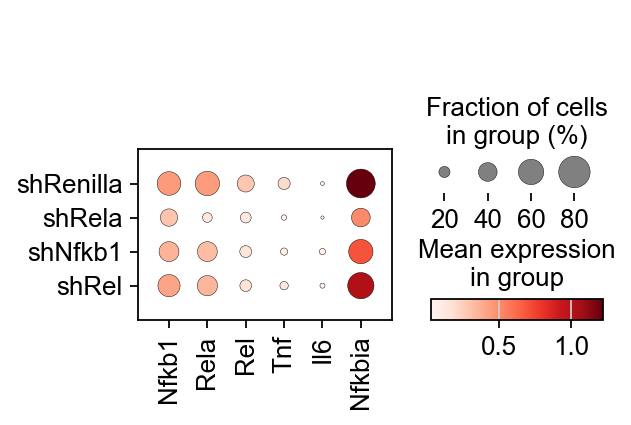

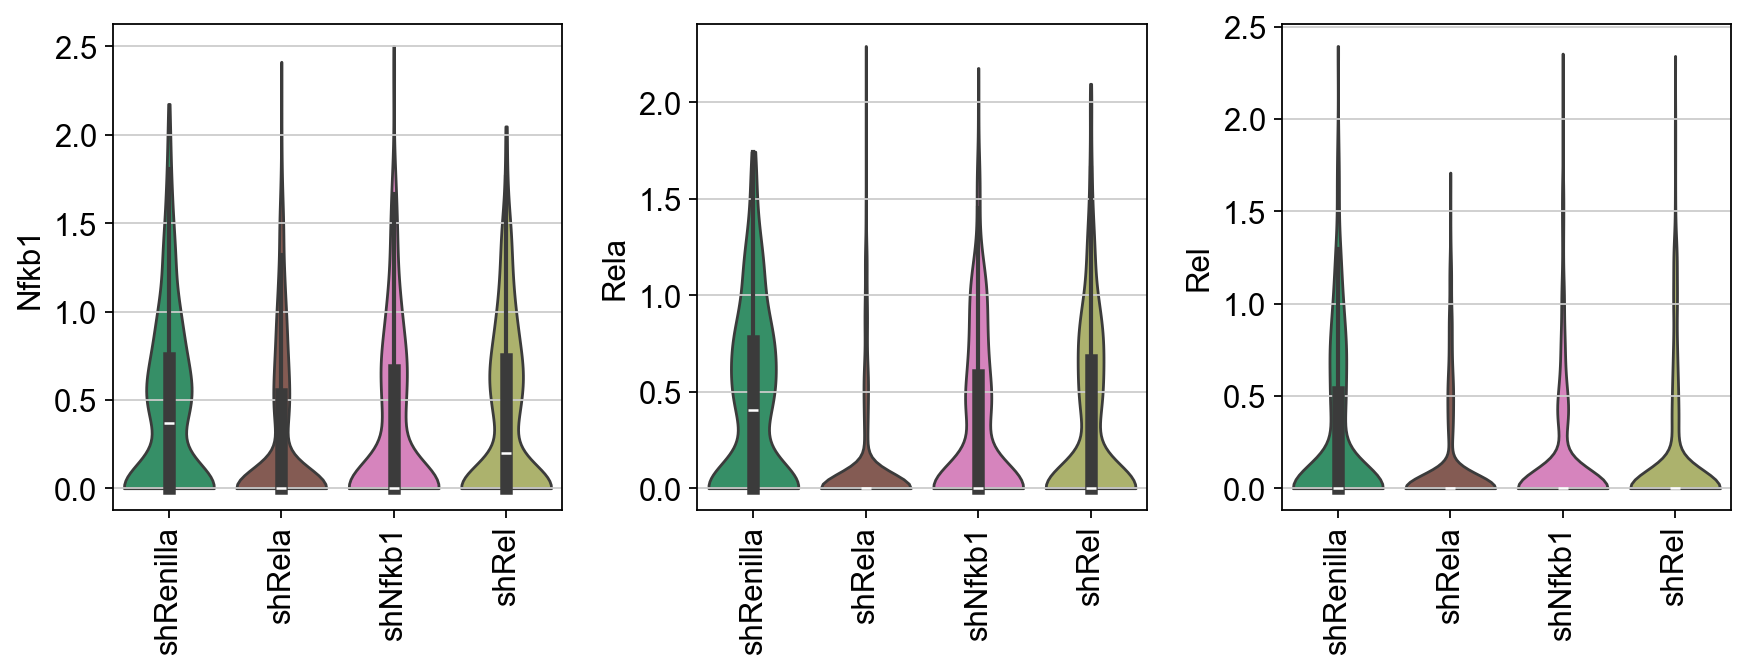

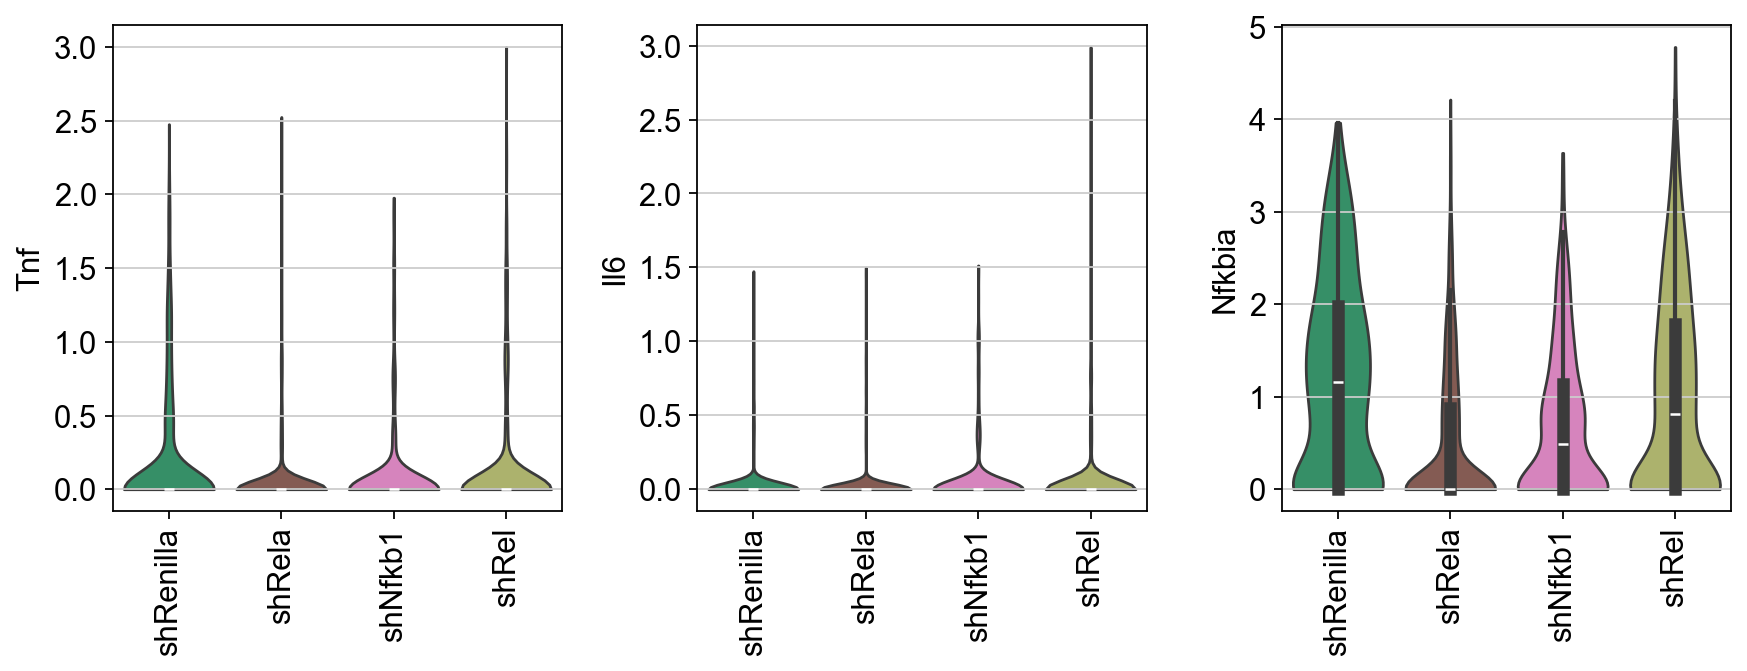

In [11]:
# note p50 (encoded by Nfkb1) creates repressive homodimers and also is an activator with p65, so there might be mixed signal; expect Tnf and Il6 to go down
sc.pl.dotplot(adata,['Nfkb1','Rela','Rel','Tnf','Il6','Nfkbia'],groupby='Group', use_raw=True)
sc.pl.violin(adata,['Nfkb1','Rela','Rel'],groupby='Group',rotation=90, inner='box',stripplot=False, use_raw=True)
sc.pl.violin(adata,['Tnf','Il6','Nfkbia'],groupby='Group',rotation=90, inner='box',stripplot=False, use_raw=True)


## Now select cells by GFP expression

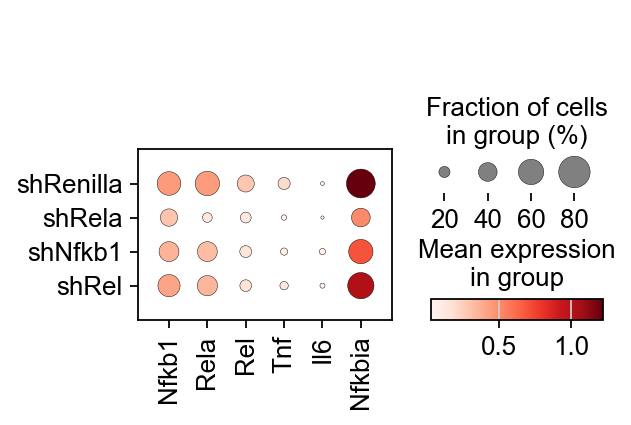

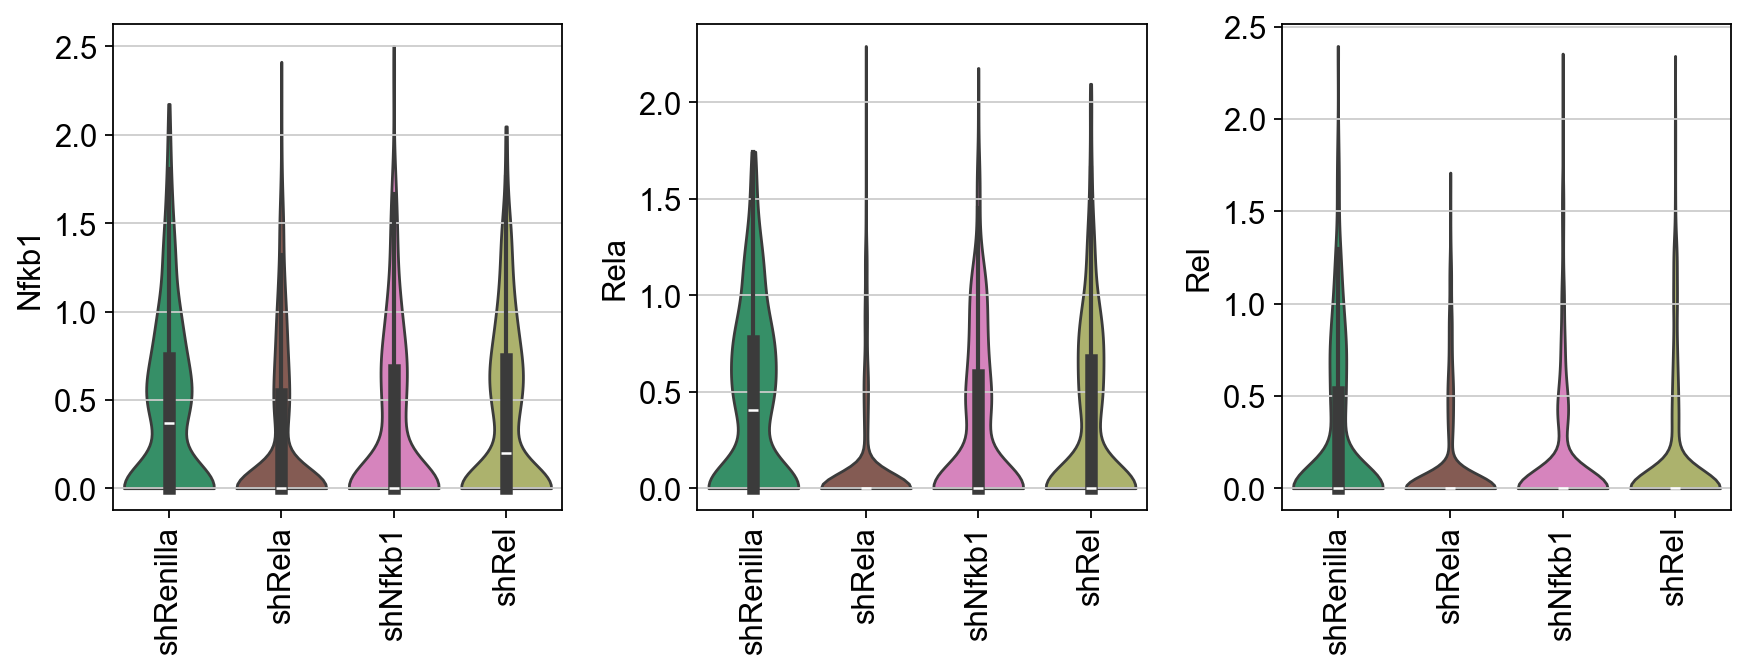

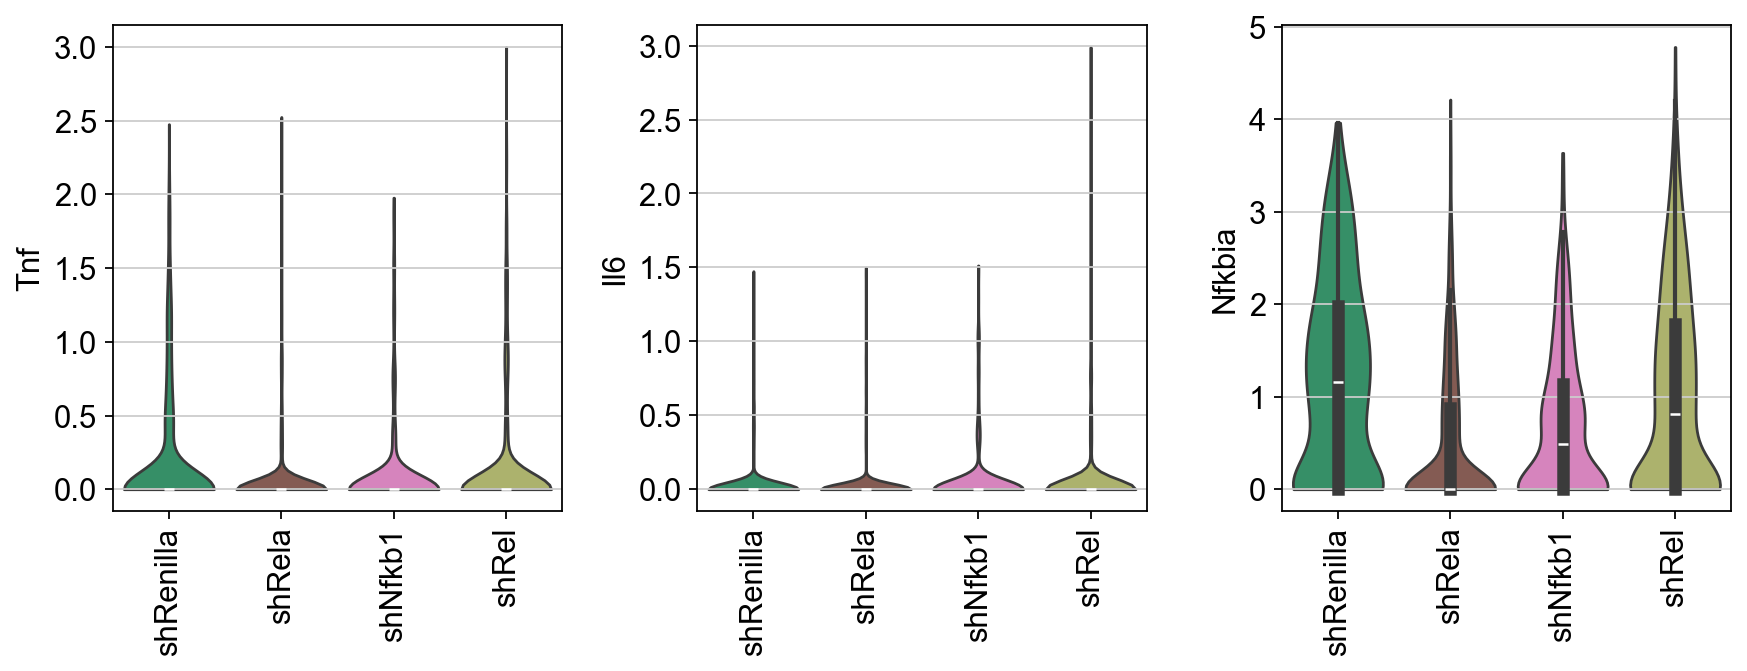

In [12]:
sc.pl.dotplot(adata,['Nfkb1','Rela','Rel','Tnf','Il6','Nfkbia'],groupby='Group')
sc.pl.violin(adata,['Nfkb1','Rela','Rel'],groupby='Group',rotation=90, inner='box',stripplot=False)
sc.pl.violin(adata,['Tnf','Il6','Nfkbia'],groupby='Group',rotation=90, inner='box',stripplot=False)


In [13]:
import csv
# Define NFκB target gene signatures
nfkb_targets_broad = ['Birc3', 'Bcl2a1a', 'Bcl2a1b', 'Bcl2a1c', 'Bcl2a1d',
                      'Cflar', 'Traf1', 'Ccl5', 'Cxcl1', 'Cxcl2', 
                      'Cxcl10', 'Il1b', 'Ccl3', 'Ccl4']

# Note: Mouse doesn't have CXCL8 (IL-8), but has functional homologs
# Remove Cxcl8 if not in your data, or replace with Cxcl1/Cxcl2
nfkb_targets_classical = ['Tnf', 'Il6', 'Ccl2', 'Icam1', 
                          'Vcam1', 'Nfkbia', 'Nfkbiz', 'Tnfaip3',
                          'Cxcl1', 'Cxcl2']  # Added mouse chemokines

nfkb_genes = [
    "Ager","Alox12b","Apoc3","B2m","Bcl2","Bcl2a1","Bcl2l1","Bcl3","Bdkrb1",
    "Ccl11","Ccl15","Ccl2","Ccl5","Ccnd1","Ccr5","Ccr7","Cd209","Cd3g","Cd40",
    "Cd40lg","Cd44","Cd48","Cd69","Cd74","Cd80","Cd83","Cr2","Crp","Csf1",
    "Csf2","Csf3","Cxcl5","Cxcl8","Cxcr5","Defb4","Elf3","Eng","F3","Fas",
    "Faslg","Gstp1","Hmox1","Icam1","Ier3","Ifnb1","Ighg3","Ighg4","Il11",
    "Il13","Il15","Il15ra","Il1a","Il1b","Il1rn","Il2","Il2ra","Il6","Il9",
    "Irf1","Irf2","Irf4","Irf7","Klk3","Lta","Ltb","Mmp9","Myc","Nfkb1",
    "Nfkb2","Nfkbia","Nod2","Nos2","Nqo1","Nr4a2","Oprm1","Pdgfb","Plau",
    "Plcd1","Psma2","Psmb9","Ptafr","Ptgs2","Ptx3","Relb","S100a6","Scnn1a",
    "Sele","Selp","Slc2a5","Sod2","Stat5a","Tacr1","Tap1","Tfpi2","Tgm2",
    "Tnc","Tnf","Tnfaip3","Tnfrsf9","Tp53","Tpmt","Vcam1","Vegfc","Vim"
]

# Additional important mouse NFκB targets
nfkb_targets_extended = ['Ptgs2', 'Nos2', 'Sod2', 'Csf2', 'Csf3',
                         'Il1a', 'Il1b', 'Ccl20', 'Cxcl10', 'Relb']

# Define p50 targets that are normally repressed by p50 homodimers (encoded by Nfkb1):
p50_targets = ['Ccl2', 'Cxcl10', 'Csf2', 'Mmp13', 'Il6', 'Il1b', 'Nos2', 'Lcn2', 'Batf']

# Hallmark Nfkb genes from mSigDB:
hallmark_nfkb = []
with open('../../common_files/hallmark_tnfanfkb.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                hallmark_nfkb = [x for row in csvreader for x in row]
    
# Score each cell
sc.tl.score_genes(adata, 
                  gene_list=nfkb_targets_classical,
                  score_name='nfkb_classical_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_targets_broad, 
                  score_name='nfkb_broad_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_targets_extended, 
                  score_name='nfkb_extended_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=nfkb_genes, 
                  score_name='nfkb_genes_score',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=p50_targets, 
                  score_name='p50_targets',
                  use_raw=True)

sc.tl.score_genes(adata,
                  gene_list=hallmark_nfkb, 
                  score_name='hallmark_nfkb',
                  use_raw=True)

computing score 'nfkb_classical_score'
    finished: added
    'nfkb_classical_score', score of gene set (adata.obs).
    300 total control genes are used. (0:00:00)
computing score 'nfkb_broad_score'
    finished: added
    'nfkb_broad_score', score of gene set (adata.obs).
    400 total control genes are used. (0:00:00)
computing score 'nfkb_extended_score'
    finished: added
    'nfkb_extended_score', score of gene set (adata.obs).
    399 total control genes are used. (0:00:00)
computing score 'nfkb_genes_score'
       'Faslg', 'Ighg4', 'Il9', 'Klk3', 'Tp53'],
      dtype='object')
    finished: added
    'nfkb_genes_score', score of gene set (adata.obs).
    898 total control genes are used. (0:00:00)
computing score 'p50_targets'
    finished: added
    'p50_targets', score of gene set (adata.obs).
    349 total control genes are used. (0:00:00)
computing score 'hallmark_nfkb'
    finished: added
    'hallmark_nfkb', score of gene set (adata.obs).
    839 total control genes are

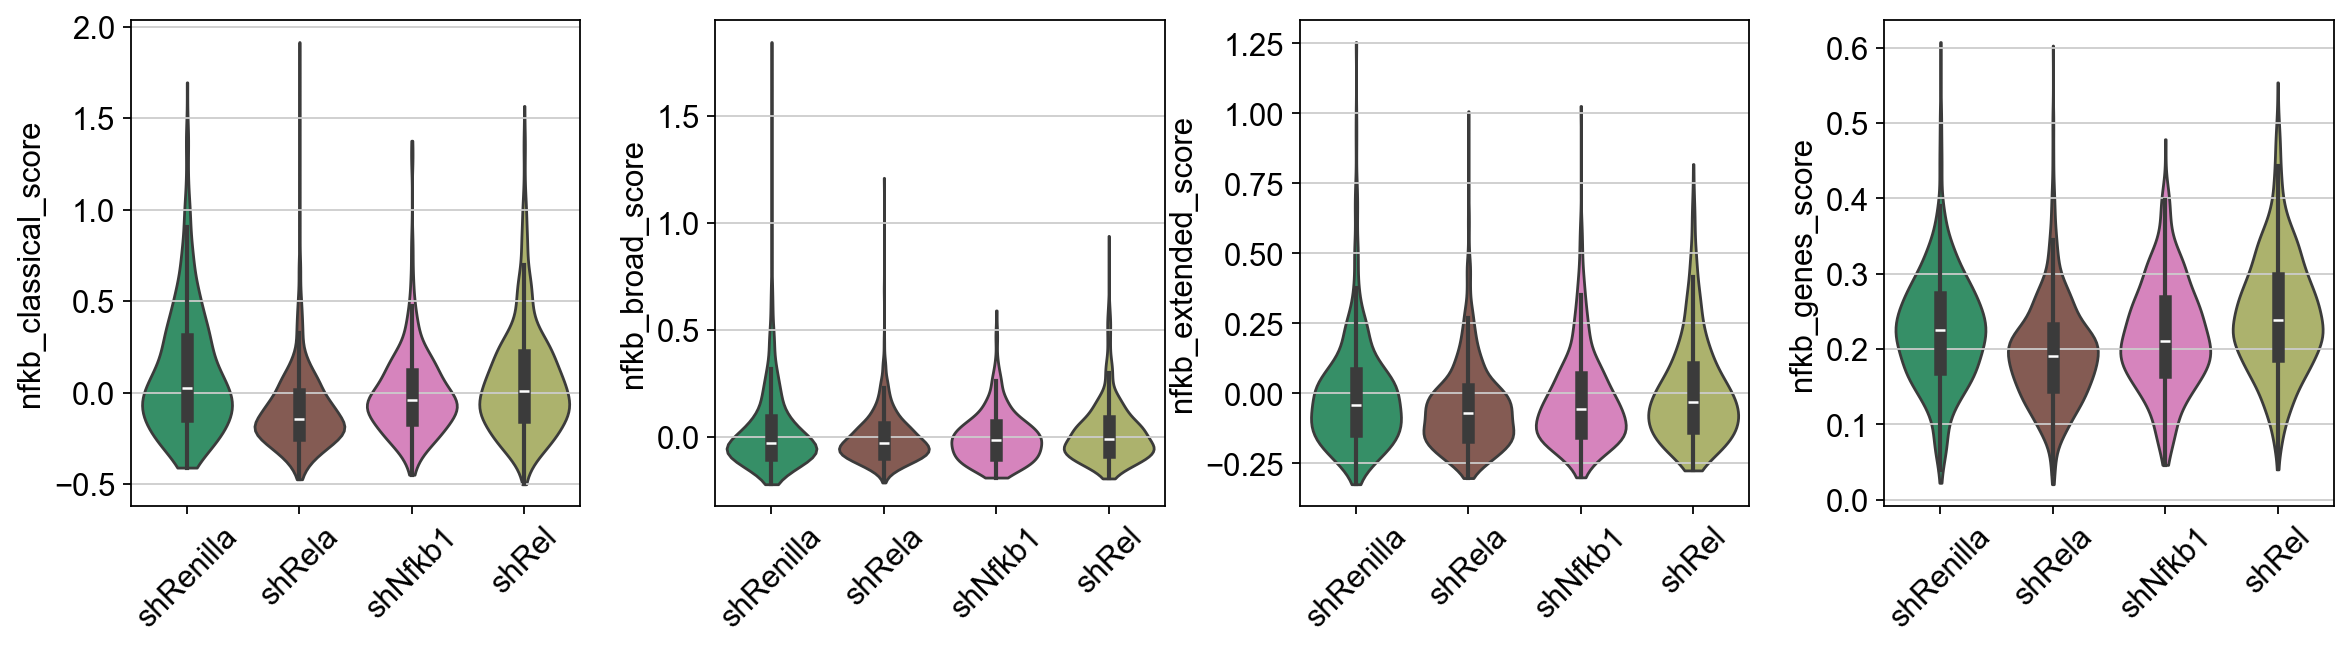

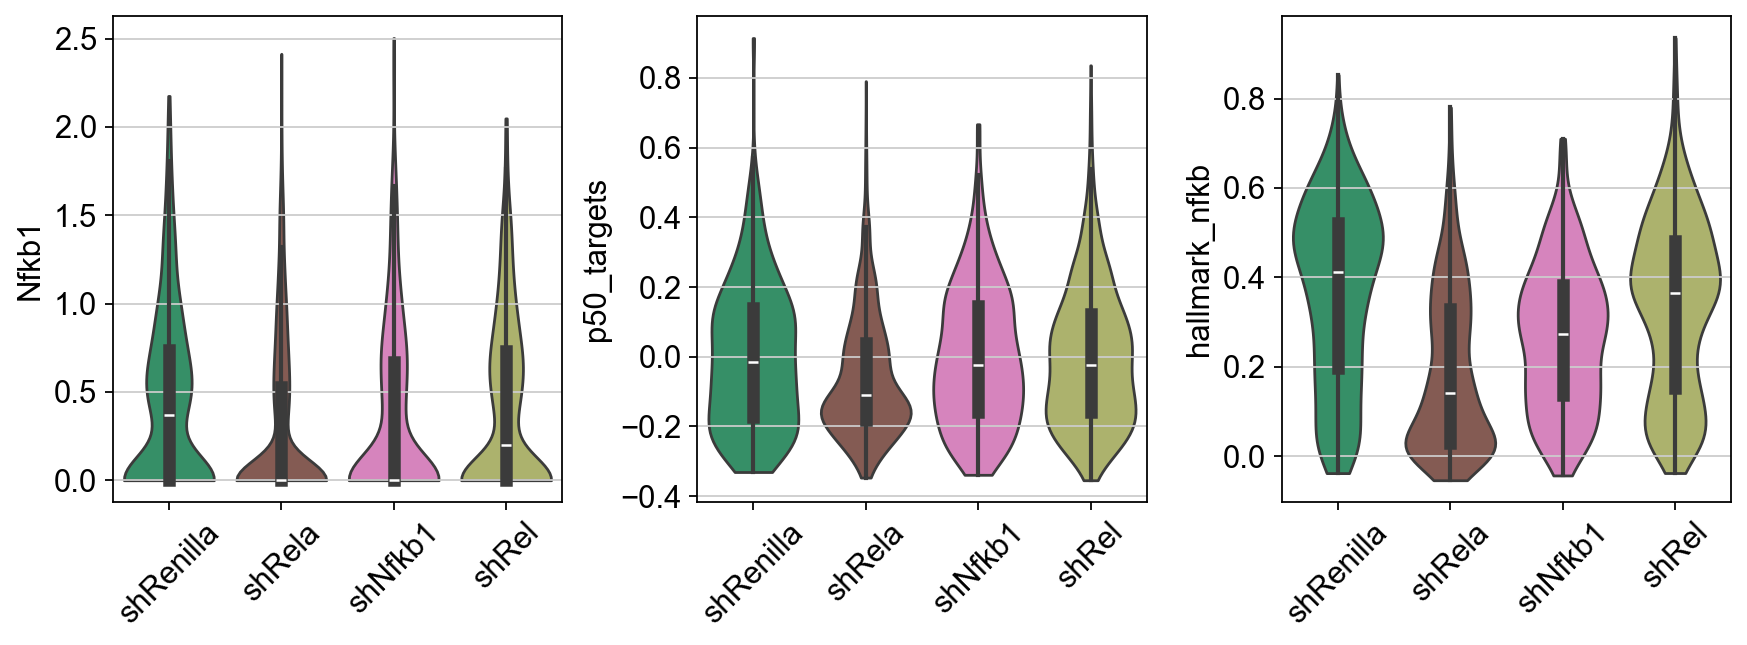

In [14]:
sc.pl.violin(adata, 
             keys=['nfkb_classical_score', 'nfkb_broad_score', 'nfkb_extended_score', 'nfkb_genes_score'],
             groupby='Group',
             rotation=45,inner='box',stripplot=False,use_raw=True)
sc.pl.violin(adata, 
             keys=['Nfkb1','p50_targets','hallmark_nfkb'],
             groupby='Group',
             rotation=45,inner='box',stripplot=False,use_raw=True)

In [15]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='shRela'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.0000


In [16]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='shNfkb1'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.0000


In [17]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
hp2_classical = adata[adata.obs['Group']=='shRel'].obs['nfkb_classical_score']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"HP1 vs HP2 classical score: p={pval:.4f}")

HP1 vs HP2 classical score: p=0.0917


In [18]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['Cluster 5']
hp2_classical = adata[adata.obs['Group']=='shRela'].obs['Cluster 5']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP1 classical score: p={pval:.4f}")

shRenilla vs HP1 classical score: p=0.0000


In [19]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['Cluster 5']
hp2_classical = adata[adata.obs['Group']=='shNfkb1'].obs['Cluster 5']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP1 classical score: p={pval:.4f}")

shRenilla vs HP1 classical score: p=0.1252


In [20]:
from scipy.stats import mannwhitneyu

hp1_classical = adata[adata.obs['Group']=='shRenilla'].obs['Cluster 5']
hp2_classical = adata[adata.obs['Group']=='shRel'].obs['Cluster 5']

stat, pval = mannwhitneyu(hp1_classical, hp2_classical)
print(f"shRenilla vs HP1 classical score: p={pval:.4f}")

shRenilla vs HP1 classical score: p=0.0001


In [21]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata,
    groupby="Group",                 # shRenilla / shRela / shNfkb1 / shRel
    groups=["shRela", "shNfkb1", "shRel"],
    reference="shRenilla",
    method="wilcoxon",
    use_raw=True
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


In [22]:
df_Rela = sc.get.rank_genes_groups_df(adata, group="shRela")
df_Nfkb1 = sc.get.rank_genes_groups_df(adata, group="shNfkb1")
df_Rel = sc.get.rank_genes_groups_df(adata, group="shRel")

df_Rela[df_Rela["names"] == "Rela"]


names    scores  logfoldchanges         pvals     pvals_adj
30133  Rela -12.93254       -2.096785  2.949117e-38  8.081653e-35

In [23]:
df_Nfkb1[df_Nfkb1["names"] == "Nfkb1"]

names    scores  logfoldchanges     pvals  pvals_adj
28832  Nfkb1 -2.763768       -0.349826  0.005714   0.119361

In [24]:
df_Rel[df_Rel["names"] == "Rel"]

names   scores  logfoldchanges     pvals  pvals_adj
29444   Rel -4.21098       -0.874326  0.000025   0.000974

In [25]:
import pandas as pd

df = adata.obs.copy()
df["Rela_expr"] = (
    adata.raw[:, "Rela"].X.A1
    if hasattr(adata.raw[:, "Rela"].X, "A1")
    else adata.raw[:, "Rela"].X.toarray().ravel()
)
df["Nfkb1_expr"] = (
    adata.raw[:, "Nfkb1"].X.A1
    if hasattr(adata.raw[:, "Nfkb1"].X, "A1")
    else adata.raw[:, "Nfkb1"].X.toarray().ravel()
)
df["Rel_expr"] = (
    adata.raw[:, "Rel"].X.A1
    if hasattr(adata.raw[:, "Rel"].X, "A1")
    else adata.raw[:, "Rel"].X.toarray().ravel()
)

/tmp/ipykernel_2029983/2404083075.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Rela_expr"]


Text(0, 0.5, 'Mean Rela expression per mouse')

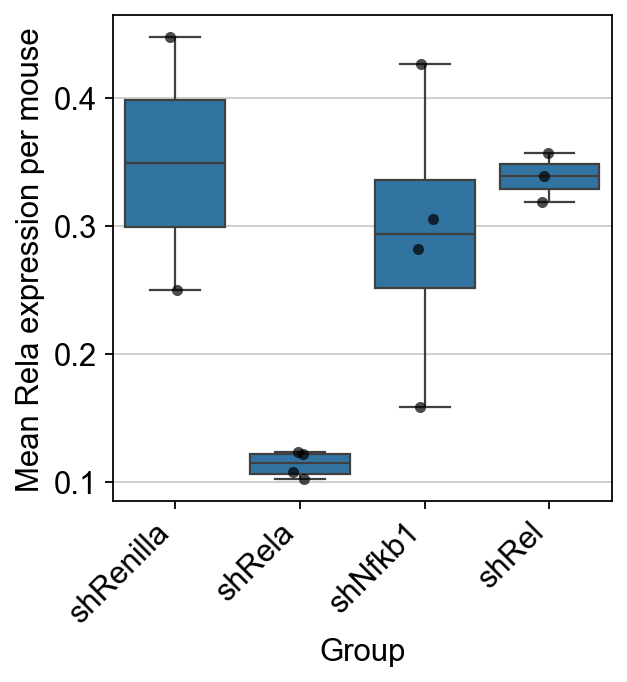

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

pb = (
    df.groupby(["Classification", "Group"])["Rela_expr"]
      .mean()
      .reset_index()
)

sns.boxplot(
    data=pb,
    x="Group",
    y="Rela_expr",
    showfliers=False,
)
sns.stripplot(
    data=pb,
    x="Group",
    y="Rela_expr",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Rela expression per mouse")


/tmp/ipykernel_2029983/167854861.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Nfkb1_expr"]


Text(0, 0.5, 'Mean Nfkb1 expression per mouse')

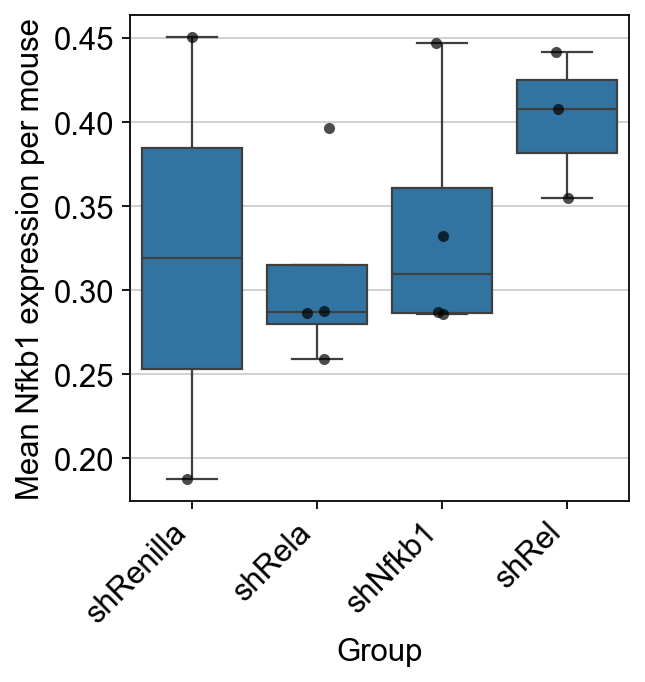

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

pb = (
    df.groupby(["Classification", "Group"])["Nfkb1_expr"]
      .mean()
      .reset_index()
)

sns.boxplot(
    data=pb,
    x="Group",
    y="Nfkb1_expr",
    showfliers=False,
)
sns.stripplot(
    data=pb,
    x="Group",
    y="Nfkb1_expr",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Nfkb1 expression per mouse")


/tmp/ipykernel_2029983/2254418270.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Rel_expr"]


Text(0, 0.5, 'Mean Rel expression per mouse')

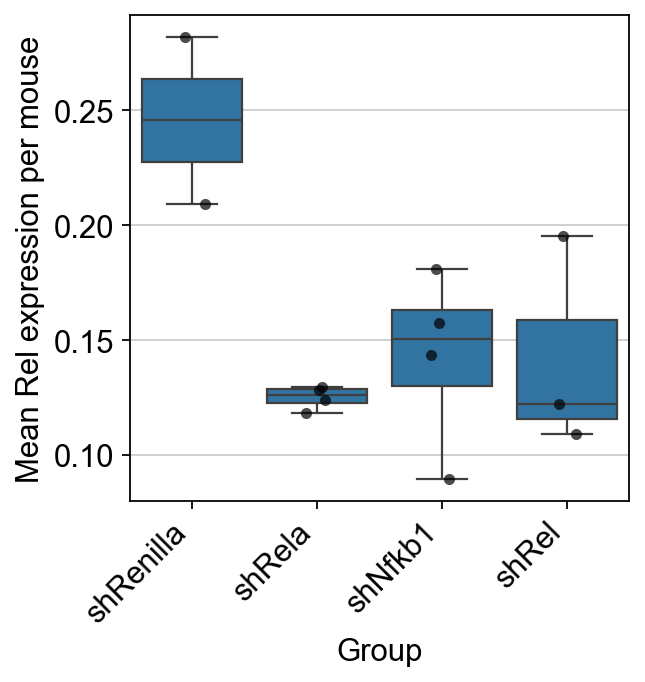

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

pb = (
    df.groupby(["Classification", "Group"])["Rel_expr"]
      .mean()
      .reset_index()
)

sns.boxplot(
    data=pb,
    x="Group",
    y="Rel_expr",
    showfliers=False,
)
sns.stripplot(
    data=pb,
    x="Group",
    y="Rel_expr",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Rel expression per mouse")



Rows (mouse × group): 13

Mice per group:
 Group
shNfkb1      4
shRela       4
shRel        3
shRenilla    2
Name: count, dtype: int64

Cells per mouse×group summary:
            count        mean         std   min     25%    50%     75%    max
Group                                                                       
shNfkb1      4.0   99.500000   80.309817   5.0   57.50   98.5  140.50  196.0
shRel        3.0  213.333333  139.055145  82.0  140.50  199.0  279.00  359.0
shRela       4.0  230.750000  143.813247  52.0  169.75  235.5  296.50  400.0
shRenilla    2.0  244.500000  324.562013  15.0  129.75  244.5  359.25  474.0


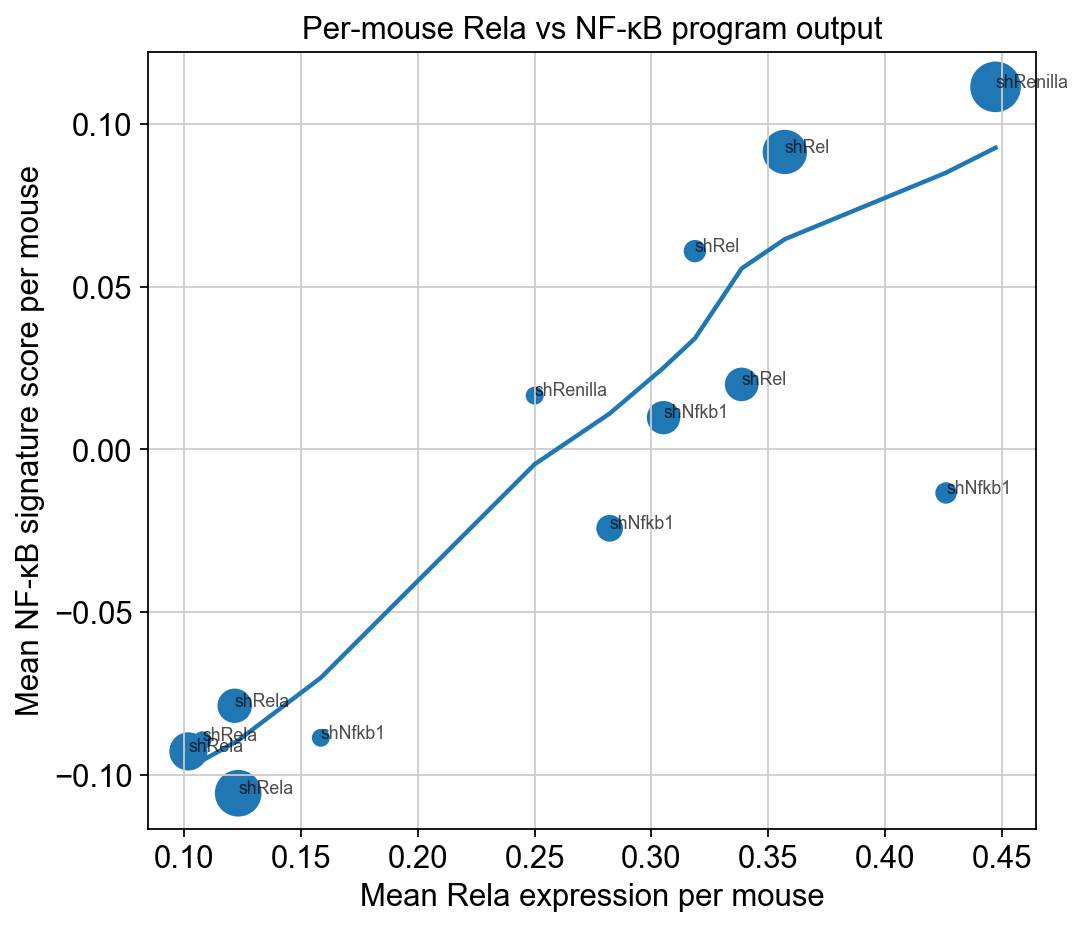

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# -----------------------------
# USER SETTINGS (edit these)
# -----------------------------
MOUSE_COL   = "Classification"
GROUP_COL   = "Group"          # shRenilla / Nfkb1_2331 / Nfkb1_3737
GENE        = "Rela"
SCORE_COL   = "nfkb_classical_score"       # must already exist in adata.obs, OR compute below
COUNTS_LAYER_FOR_SCORE = None    # leave None unless you want to force use_raw/layer logic

# Optional: subset to a celltype (recommended if mixed)
CELLTYPE_COL = None   # e.g., "celltype"
KEEP_CELLTYPE = None  # e.g., "Tumor"

# Optional: compute the NF-κB score here (replace gene list!)
COMPUTE_SCORE = False
NFkB_GENESET = ["Nfkbia", "Tnfaip3", "Rel", "Relb", "Icam1", "Cxcl1", "Cxcl2", "Il1b"]


# -----------------------------
# (Optional) subset cells
# -----------------------------
adata_use = adata
if CELLTYPE_COL is not None and KEEP_CELLTYPE is not None:
    adata_use = adata[adata.obs[CELLTYPE_COL].astype(str) == str(KEEP_CELLTYPE)].copy()
    print(f"Using subset: {adata_use.n_obs} cells where {CELLTYPE_COL} == {KEEP_CELLTYPE}")

# -----------------------------
# (Optional) compute signature score
# -----------------------------
if COMPUTE_SCORE:
    import scanpy as sc
    genes_present = [g for g in NFkB_GENESET if g in adata_use.var_names]
    if len(genes_present) < 5:
        raise ValueError(f"Too few NF-κB genes found in adata.var_names: {genes_present}")
    sc.tl.score_genes(adata_use, gene_list=genes_present, score_name=SCORE_COL, use_raw=False)
    print(f"Computed {SCORE_COL} using {len(genes_present)} genes.")

if SCORE_COL not in adata_use.obs.columns:
    raise ValueError(
        f"Missing adata.obs['{SCORE_COL}']. Set COMPUTE_SCORE=True or provide your precomputed score."
    )

# -----------------------------
# Extract per-cell Nfkb1 expression
# -----------------------------
if GENE not in adata_use.var_names:
    # case-insensitive fallback
    lower_map = {g.lower(): g for g in adata_use.var_names}
    if GENE.lower() in lower_map:
        print(f"NOTE: '{GENE}' not found exactly; using '{lower_map[GENE.lower()]}' instead.")
        GENE = lower_map[GENE.lower()]
    else:
        raise ValueError(f"Gene '{GENE}' not found in adata.var_names.")

Xg = adata_use.raw[:, GENE].X
if sp.issparse(Xg):
    rela_expr = Xg.toarray().ravel()
else:
    rela_expr = np.asarray(Xg).ravel()

# -----------------------------
# Build per-cell dataframe
# -----------------------------
for col in [MOUSE_COL, GROUP_COL]:
    if col not in adata_use.obs.columns:
        raise ValueError(f"Missing adata.obs['{col}'].")

df = adata_use.obs[[MOUSE_COL, GROUP_COL]].copy()
df[MOUSE_COL] = df[MOUSE_COL].astype(str)
df[GROUP_COL] = df[GROUP_COL].astype(str)
df["rela_expr"] = rela_expr
df[SCORE_COL] = adata_use.obs[SCORE_COL].values

# -----------------------------
# Aggregate per mouse (and group)
# -----------------------------
pb = (df.groupby([MOUSE_COL, GROUP_COL])
        .agg(
            rela_mean=("rela_expr", "mean"),
            nfkb_score_mean=(SCORE_COL, "mean"),
            n_cells=("rela_expr", "size"),
        )
        .reset_index())

print("\nRows (mouse × group):", pb.shape[0])
print("\nMice per group:\n", pb[GROUP_COL].value_counts())
print("\nCells per mouse×group summary:\n", pb.groupby(GROUP_COL)["n_cells"].describe())

# -----------------------------
# Plot: x = mean Nfkb1 per mouse, y = mean NF-κB score per mouse
# Point size encodes n_cells (optional), and we label by group.
# -----------------------------
plt.figure(figsize=(7, 6))

sizes = np.clip(pb["n_cells"].values, 50, 600)  # optional sizing by cells
plt.scatter(pb["rela_mean"], pb["nfkb_score_mean"], s=sizes)

# annotate each point with perturb label (can be noisy if many mice)
for _, r in pb.iterrows():
    plt.text(r["rela_mean"], r["nfkb_score_mean"], r[GROUP_COL], fontsize=8, alpha=0.7)

plt.xlabel("Mean Rela expression per mouse")
plt.ylabel("Mean NF-κB signature score per mouse")
plt.title("Per-mouse Rela vs NF-κB program output")

# Add a smoother to reveal nonlinearity (LOWESS if available; else quadratic fit)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    xy = pb[["rela_mean", "nfkb_score_mean"]].dropna().sort_values("rela_mean")
    sm = lowess(xy["nfkb_score_mean"], xy["rela_mean"], frac=0.6, return_sorted=True)
    plt.plot(sm[:, 0], sm[:, 1], linewidth=2)
except Exception:
    xy = pb[["rela_mean", "nfkb_score_mean"]].dropna()
    if len(xy) >= 5:
        xs = np.linspace(xy["rela_mean"].min(), xy["rela_mean"].max(), 200)
        coeff = np.polyfit(xy["rela_mean"], xy["nfkb_score_mean"], deg=2)
        plt.plot(xs, np.polyval(coeff, xs), linewidth=2)

plt.tight_layout()
plt.show()



Rows (mouse × group): 13

Mice per group:
 Group
shNfkb1      4
shRela       4
shRel        3
shRenilla    2
Name: count, dtype: int64

Cells per mouse×group summary:
            count        mean         std   min     25%    50%     75%    max
Group                                                                       
shNfkb1      4.0   99.500000   80.309817   5.0   57.50   98.5  140.50  196.0
shRel        3.0  213.333333  139.055145  82.0  140.50  199.0  279.00  359.0
shRela       4.0  230.750000  143.813247  52.0  169.75  235.5  296.50  400.0
shRenilla    2.0  244.500000  324.562013  15.0  129.75  244.5  359.25  474.0


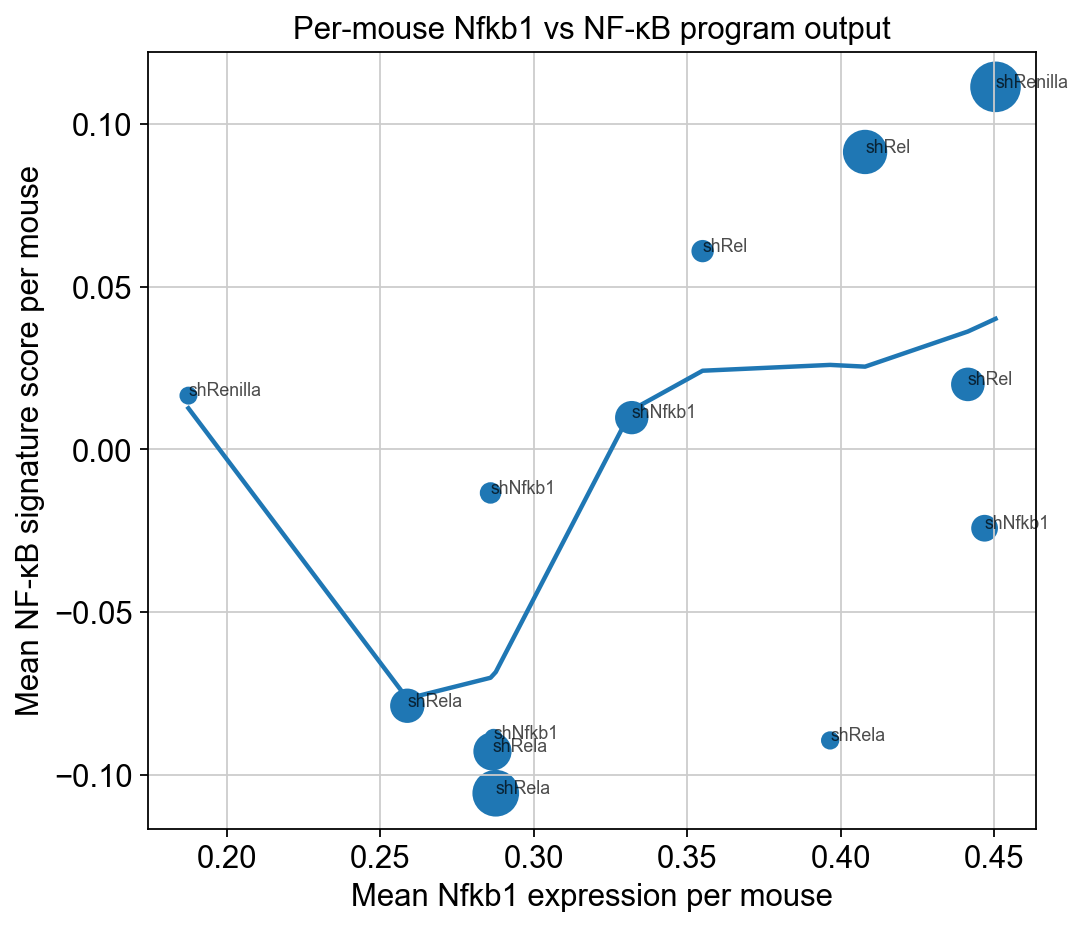

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# -----------------------------
# USER SETTINGS (edit these)
# -----------------------------
MOUSE_COL   = "Classification"
GROUP_COL   = "Group"          # shRenilla / Nfkb1_2331 / Nfkb1_3737
GENE        = "Nfkb1"
SCORE_COL   = "nfkb_classical_score"       # must already exist in adata.obs, OR compute below
COUNTS_LAYER_FOR_SCORE = None    # leave None unless you want to force use_raw/layer logic

# Optional: subset to a celltype (recommended if mixed)
CELLTYPE_COL = None   # e.g., "celltype"
KEEP_CELLTYPE = None  # e.g., "Tumor"

# Optional: compute the NF-κB score here (replace gene list!)
COMPUTE_SCORE = False
NFkB_GENESET = ["Nfkbia", "Tnfaip3", "Rel", "Relb", "Icam1", "Cxcl1", "Cxcl2", "Il1b"]


# -----------------------------
# (Optional) subset cells
# -----------------------------
adata_use = adata
if CELLTYPE_COL is not None and KEEP_CELLTYPE is not None:
    adata_use = adata[adata.obs[CELLTYPE_COL].astype(str) == str(KEEP_CELLTYPE)].copy()
    print(f"Using subset: {adata_use.n_obs} cells where {CELLTYPE_COL} == {KEEP_CELLTYPE}")

# -----------------------------
# (Optional) compute signature score
# -----------------------------
if COMPUTE_SCORE:
    import scanpy as sc
    genes_present = [g for g in NFkB_GENESET if g in adata_use.var_names]
    if len(genes_present) < 5:
        raise ValueError(f"Too few NF-κB genes found in adata.var_names: {genes_present}")
    sc.tl.score_genes(adata_use, gene_list=genes_present, score_name=SCORE_COL, use_raw=False)
    print(f"Computed {SCORE_COL} using {len(genes_present)} genes.")

if SCORE_COL not in adata_use.obs.columns:
    raise ValueError(
        f"Missing adata.obs['{SCORE_COL}']. Set COMPUTE_SCORE=True or provide your precomputed score."
    )

# -----------------------------
# Extract per-cell Nfkb1 expression
# -----------------------------
if GENE not in adata_use.var_names:
    # case-insensitive fallback
    lower_map = {g.lower(): g for g in adata_use.var_names}
    if GENE.lower() in lower_map:
        print(f"NOTE: '{GENE}' not found exactly; using '{lower_map[GENE.lower()]}' instead.")
        GENE = lower_map[GENE.lower()]
    else:
        raise ValueError(f"Gene '{GENE}' not found in adata.var_names.")

Xg = adata_use.raw[:, GENE].X
if sp.issparse(Xg):
    nfkb1_expr = Xg.toarray().ravel()
else:
    nfkb1_expr = np.asarray(Xg).ravel()

# -----------------------------
# Build per-cell dataframe
# -----------------------------
for col in [MOUSE_COL, GROUP_COL]:
    if col not in adata_use.obs.columns:
        raise ValueError(f"Missing adata.obs['{col}'].")

df = adata_use.obs[[MOUSE_COL, GROUP_COL]].copy()
df[MOUSE_COL] = df[MOUSE_COL].astype(str)
df[GROUP_COL] = df[GROUP_COL].astype(str)
df["nfkb1_expr"] = nfkb1_expr
df[SCORE_COL] = adata_use.obs[SCORE_COL].values

# -----------------------------
# Aggregate per mouse (and group)
# -----------------------------
pb = (df.groupby([MOUSE_COL, GROUP_COL])
        .agg(
            nfkb1_mean=("nfkb1_expr", "mean"),
            nfkb_score_mean=(SCORE_COL, "mean"),
            n_cells=("nfkb1_expr", "size"),
        )
        .reset_index())

print("\nRows (mouse × group):", pb.shape[0])
print("\nMice per group:\n", pb[GROUP_COL].value_counts())
print("\nCells per mouse×group summary:\n", pb.groupby(GROUP_COL)["n_cells"].describe())

# -----------------------------
# Plot: x = mean Nfkb1 per mouse, y = mean NF-κB score per mouse
# Point size encodes n_cells (optional), and we label by group.
# -----------------------------
plt.figure(figsize=(7, 6))

sizes = np.clip(pb["n_cells"].values, 50, 600)  # optional sizing by cells
plt.scatter(pb["nfkb1_mean"], pb["nfkb_score_mean"], s=sizes)

# annotate each point with perturb label (can be noisy if many mice)
for _, r in pb.iterrows():
    plt.text(r["nfkb1_mean"], r["nfkb_score_mean"], r[GROUP_COL], fontsize=8, alpha=0.7)

plt.xlabel("Mean Nfkb1 expression per mouse")
plt.ylabel("Mean NF-κB signature score per mouse")
plt.title("Per-mouse Nfkb1 vs NF-κB program output")

# Add a smoother to reveal nonlinearity (LOWESS if available; else quadratic fit)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    xy = pb[["nfkb1_mean", "nfkb_score_mean"]].dropna().sort_values("nfkb1_mean")
    sm = lowess(xy["nfkb_score_mean"], xy["nfkb1_mean"], frac=0.6, return_sorted=True)
    plt.plot(sm[:, 0], sm[:, 1], linewidth=2)
except Exception:
    xy = pb[["nfkb1_mean", "nfkb_score_mean"]].dropna()
    if len(xy) >= 5:
        xs = np.linspace(xy["nfkb1_mean"].min(), xy["nfkb1_mean"].max(), 200)
        coeff = np.polyfit(xy["nfkb1_mean"], xy["nfkb_score_mean"], deg=2)
        plt.plot(xs, np.polyval(coeff, xs), linewidth=2)

plt.tight_layout()
plt.show()



Rows (mouse × group): 13

Mice per group:
 Group
shNfkb1      4
shRela       4
shRel        3
shRenilla    2
Name: count, dtype: int64

Cells per mouse×group summary:
            count        mean         std   min     25%    50%     75%    max
Group                                                                       
shNfkb1      4.0   99.500000   80.309817   5.0   57.50   98.5  140.50  196.0
shRel        3.0  213.333333  139.055145  82.0  140.50  199.0  279.00  359.0
shRela       4.0  230.750000  143.813247  52.0  169.75  235.5  296.50  400.0
shRenilla    2.0  244.500000  324.562013  15.0  129.75  244.5  359.25  474.0


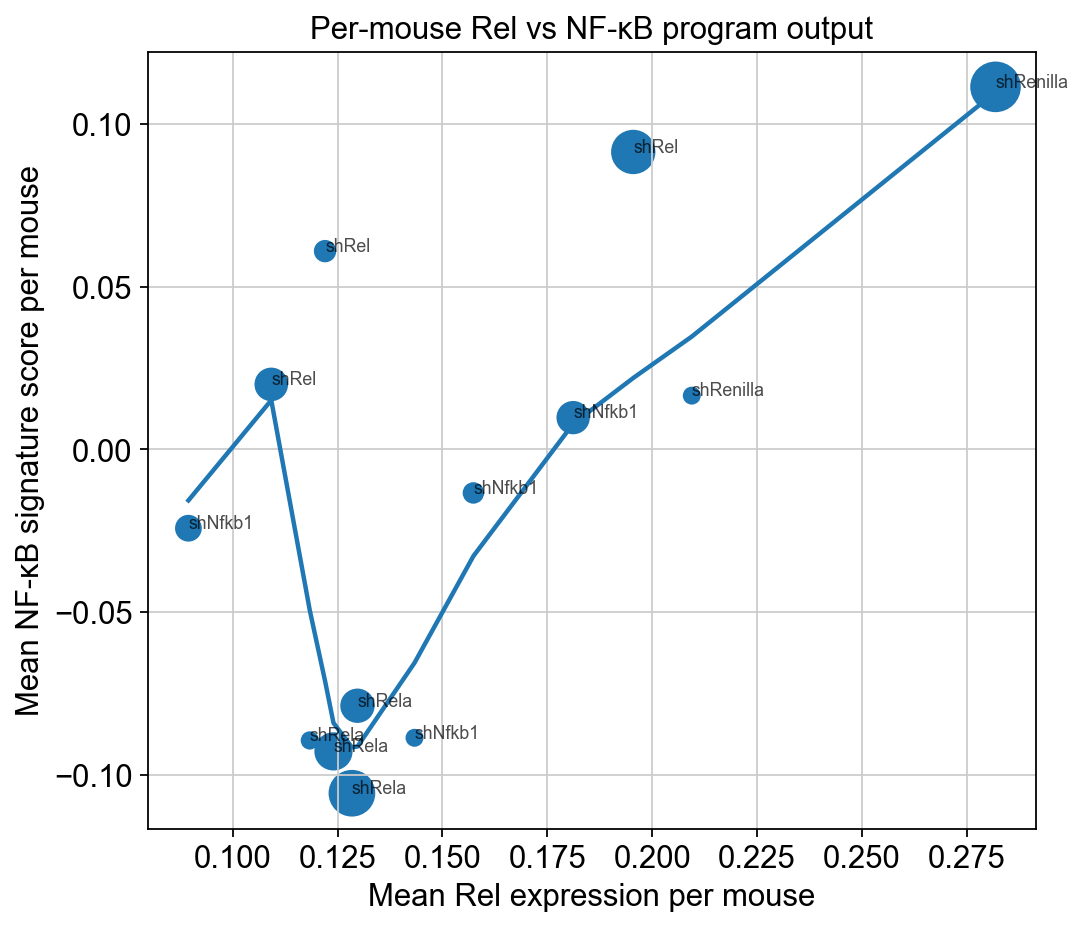

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

# -----------------------------
# USER SETTINGS (edit these)
# -----------------------------
MOUSE_COL   = "Classification"
GROUP_COL   = "Group"          # shRenilla / Nfkb1_2331 / Nfkb1_3737
GENE        = "Rel"
SCORE_COL   = "nfkb_classical_score"       # must already exist in adata.obs, OR compute below
COUNTS_LAYER_FOR_SCORE = None    # leave None unless you want to force use_raw/layer logic

# Optional: subset to a celltype (recommended if mixed)
CELLTYPE_COL = None   # e.g., "celltype"
KEEP_CELLTYPE = None  # e.g., "Tumor"

# Optional: compute the NF-κB score here (replace gene list!)
COMPUTE_SCORE = False
NFkB_GENESET = ["Nfkbia", "Tnfaip3", "Rel", "Relb", "Icam1", "Cxcl1", "Cxcl2", "Il1b"]


# -----------------------------
# (Optional) subset cells
# -----------------------------
adata_use = adata
if CELLTYPE_COL is not None and KEEP_CELLTYPE is not None:
    adata_use = adata[adata.obs[CELLTYPE_COL].astype(str) == str(KEEP_CELLTYPE)].copy()
    print(f"Using subset: {adata_use.n_obs} cells where {CELLTYPE_COL} == {KEEP_CELLTYPE}")

# -----------------------------
# (Optional) compute signature score
# -----------------------------
if COMPUTE_SCORE:
    import scanpy as sc
    genes_present = [g for g in NFkB_GENESET if g in adata_use.var_names]
    if len(genes_present) < 5:
        raise ValueError(f"Too few NF-κB genes found in adata.var_names: {genes_present}")
    sc.tl.score_genes(adata_use, gene_list=genes_present, score_name=SCORE_COL, use_raw=False)
    print(f"Computed {SCORE_COL} using {len(genes_present)} genes.")

if SCORE_COL not in adata_use.obs.columns:
    raise ValueError(
        f"Missing adata.obs['{SCORE_COL}']. Set COMPUTE_SCORE=True or provide your precomputed score."
    )

# -----------------------------
# Extract per-cell Nfkb1 expression
# -----------------------------
if GENE not in adata_use.var_names:
    # case-insensitive fallback
    lower_map = {g.lower(): g for g in adata_use.var_names}
    if GENE.lower() in lower_map:
        print(f"NOTE: '{GENE}' not found exactly; using '{lower_map[GENE.lower()]}' instead.")
        GENE = lower_map[GENE.lower()]
    else:
        raise ValueError(f"Gene '{GENE}' not found in adata.var_names.")

Xg = adata_use.raw[:, GENE].X
if sp.issparse(Xg):
    rel_expr = Xg.toarray().ravel()
else:
    rel_expr = np.asarray(Xg).ravel()

# -----------------------------
# Build per-cell dataframe
# -----------------------------
for col in [MOUSE_COL, GROUP_COL]:
    if col not in adata_use.obs.columns:
        raise ValueError(f"Missing adata.obs['{col}'].")

df = adata_use.obs[[MOUSE_COL, GROUP_COL]].copy()
df[MOUSE_COL] = df[MOUSE_COL].astype(str)
df[GROUP_COL] = df[GROUP_COL].astype(str)
df["rel_expr"] = rel_expr
df[SCORE_COL] = adata_use.obs[SCORE_COL].values

# -----------------------------
# Aggregate per mouse (and group)
# -----------------------------
pb = (df.groupby([MOUSE_COL, GROUP_COL])
        .agg(
            rel_mean=("rel_expr", "mean"),
            nfkb_score_mean=(SCORE_COL, "mean"),
            n_cells=("rel_expr", "size"),
        )
        .reset_index())

print("\nRows (mouse × group):", pb.shape[0])
print("\nMice per group:\n", pb[GROUP_COL].value_counts())
print("\nCells per mouse×group summary:\n", pb.groupby(GROUP_COL)["n_cells"].describe())

# -----------------------------
# Plot: x = mean Nfkb1 per mouse, y = mean NF-κB score per mouse
# Point size encodes n_cells (optional), and we label by group.
# -----------------------------
plt.figure(figsize=(7, 6))

sizes = np.clip(pb["n_cells"].values, 50, 600)  # optional sizing by cells
plt.scatter(pb["rel_mean"], pb["nfkb_score_mean"], s=sizes)

# annotate each point with perturb label (can be noisy if many mice)
for _, r in pb.iterrows():
    plt.text(r["rel_mean"], r["nfkb_score_mean"], r[GROUP_COL], fontsize=8, alpha=0.7)

plt.xlabel("Mean Rel expression per mouse")
plt.ylabel("Mean NF-κB signature score per mouse")
plt.title("Per-mouse Rel vs NF-κB program output")

# Add a smoother to reveal nonlinearity (LOWESS if available; else quadratic fit)
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    xy = pb[["rel_mean", "nfkb_score_mean"]].dropna().sort_values("rel_mean")
    sm = lowess(xy["nfkb_score_mean"], xy["rel_mean"], frac=0.6, return_sorted=True)
    plt.plot(sm[:, 0], sm[:, 1], linewidth=2)
except Exception:
    xy = pb[["rel_mean", "nfkb_score_mean"]].dropna()
    if len(xy) >= 5:
        xs = np.linspace(xy["rel_mean"].min(), xy["rel_mean"].max(), 200)
        coeff = np.polyfit(xy["rel_mean"], xy["nfkb_score_mean"], deg=2)
        plt.plot(xs, np.polyval(coeff, xs), linewidth=2)

plt.tight_layout()
plt.show()


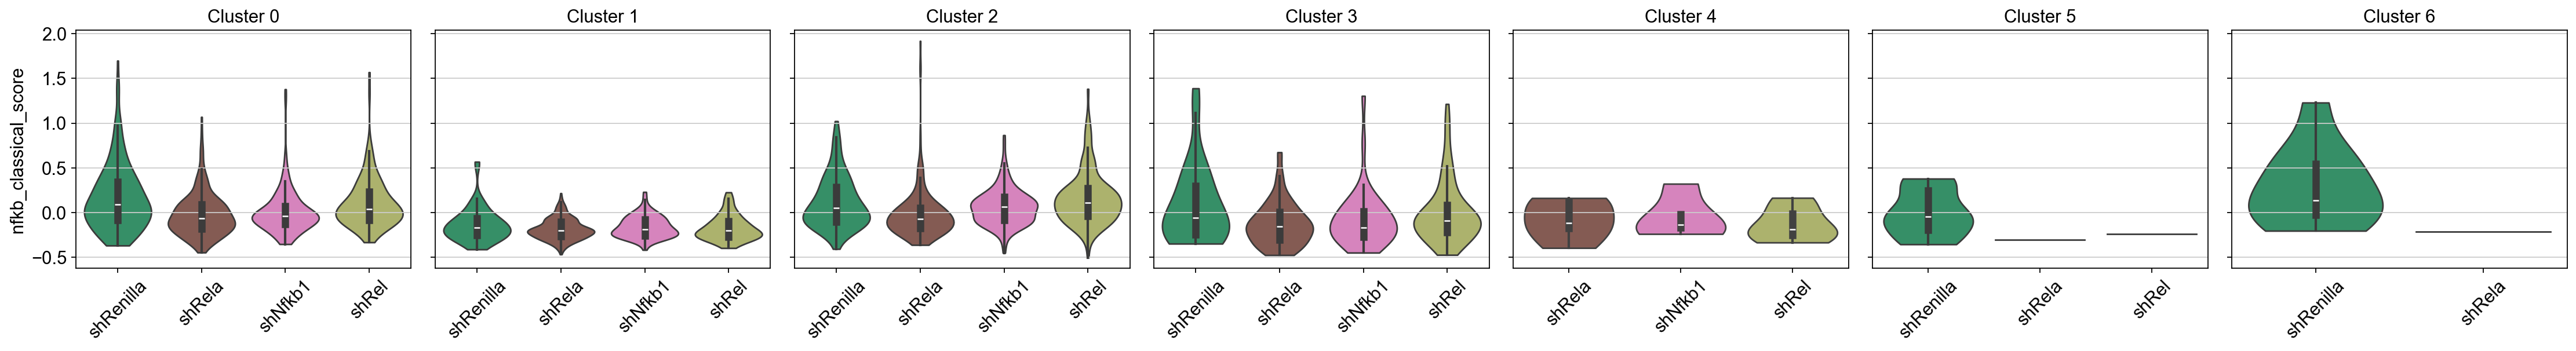

In [32]:
import matplotlib.pyplot as plt

# Get unique clusters
clusters = sorted(adata.obs['leiden'].unique())

# Create subplots
fig, axes = plt.subplots(1, len(clusters), figsize=(4*len(clusters), 4), sharey=True)
if len(clusters) == 1:
    axes = [axes]

for ax, cluster in zip(axes, clusters):
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    sc.pl.violin(adata_cluster,
                 keys='nfkb_classical_score',
                 groupby='Group',
                 ax=ax,
                 show=False, rotation=45, stripplot=False, inner='box')
    ax.set_title(f'Cluster {cluster}')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

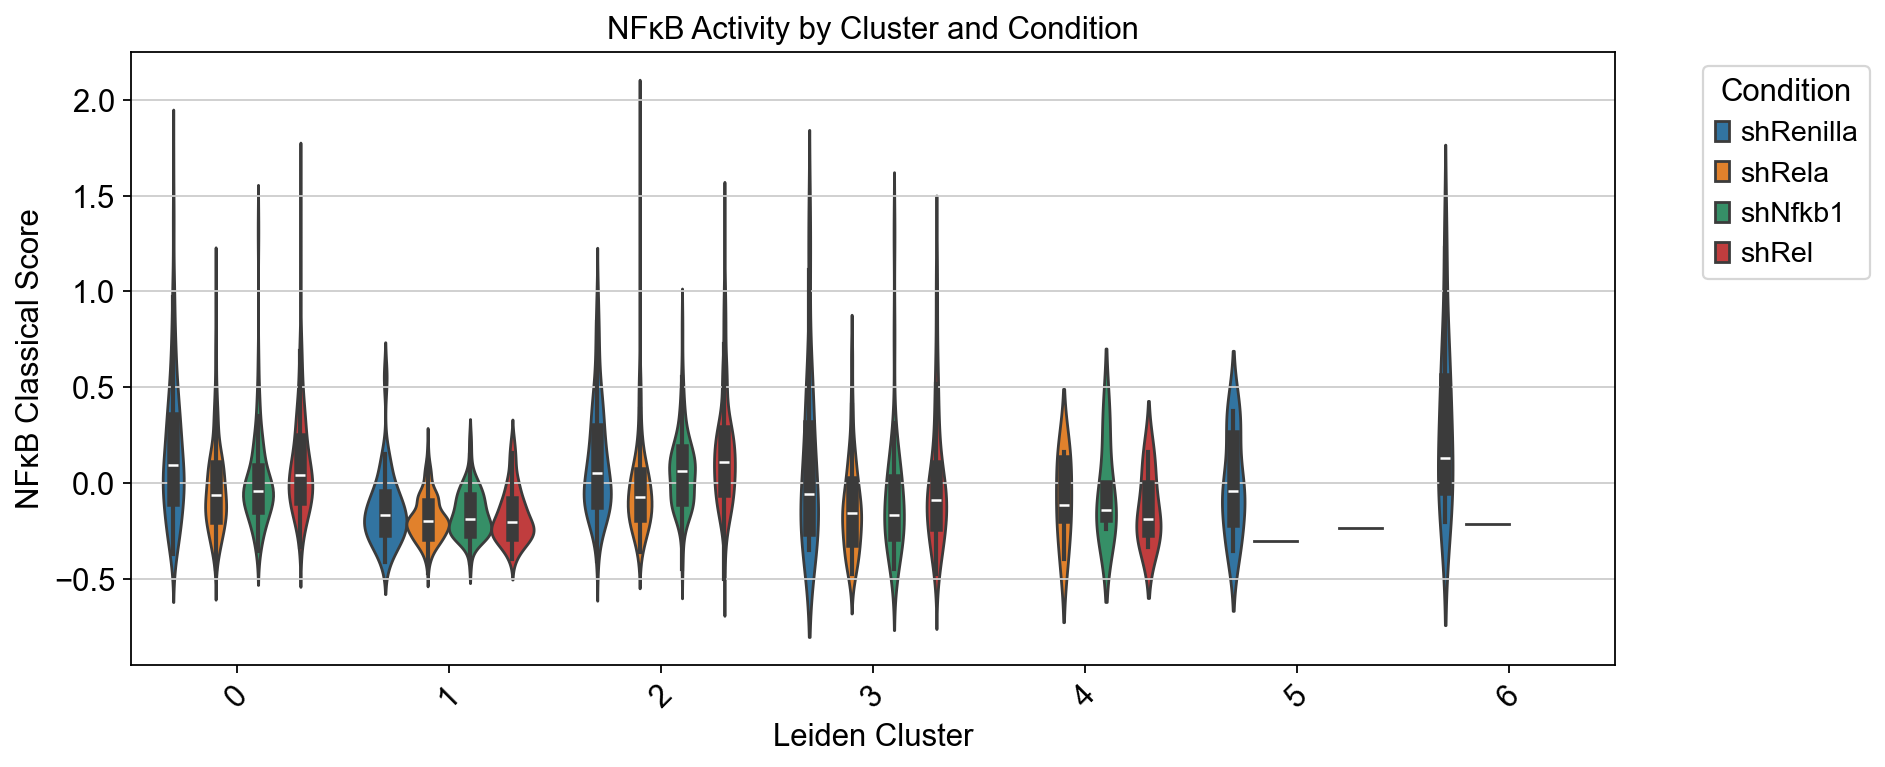

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prepare data
plot_data = adata.obs[['leiden', 'Group', 'nfkb_classical_score']].copy()

# Create the plot
plt.figure(figsize=(12, 5))
sns.violinplot(data=plot_data,
               x='leiden',
               y='nfkb_classical_score',
               hue='Group',
               split=False,  # Set to True if you want split violins
               inner='box')
plt.xticks(rotation=45)
plt.xlabel('Leiden Cluster')
plt.ylabel('NFκB Classical Score')
plt.title('NFκB Activity by Cluster and Condition')
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [34]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Compare HP1 vs HP2 within each cluster
cluster_comparisons = []

for cluster in adata.obs['leiden'].unique():
    adata_cluster = adata[adata.obs['leiden'] == cluster]
    
    # Get scores for each group
    ctrl_scores = adata_cluster[adata_cluster.obs['Group']=='shRenilla'].obs['nfkb_classical_score']
    hp1_scores = adata_cluster[adata_cluster.obs['Group']=='shRela'].obs['nfkb_classical_score']
    hp2_scores = adata_cluster[adata_cluster.obs['Group']=='shNfkb1'].obs['nfkb_classical_score']
    
    # Statistical tests
    if len(hp1_scores) > 0 and len(ctrl_scores) > 0:
        _, pval_hp1 = mannwhitneyu(hp1_scores, ctrl_scores)
    else:
        pval_hp1 = None
        
    if len(hp2_scores) > 0 and len(ctrl_scores) > 0:
        _, pval_hp2 = mannwhitneyu(hp2_scores, ctrl_scores)
    else:
        pval_hp2 = None
        
    if len(hp1_scores) > 0 and len(hp2_scores) > 0:
        _, pval_hp1_vs_hp2 = mannwhitneyu(hp1_scores, hp2_scores)
    else:
        pval_hp1_vs_hp2 = None
    
    cluster_comparisons.append({
        'cluster': cluster,
        'n_ctrl': len(ctrl_scores),
        'n_hp1': len(hp1_scores),
        'n_hp2': len(hp2_scores),
        'mean_ctrl': ctrl_scores.mean() if len(ctrl_scores) > 0 else None,
        'mean_hp1': hp1_scores.mean() if len(hp1_scores) > 0 else None,
        'mean_hp2': hp2_scores.mean() if len(hp2_scores) > 0 else None,
        'pval_hp1_vs_ctrl': pval_hp1,
        'pval_hp2_vs_ctrl': pval_hp2,
        'pval_hp1_vs_hp2': pval_hp1_vs_hp2
    })

comparison_df = pd.DataFrame(cluster_comparisons)
print(comparison_df.to_string())

# Identify clusters where HP1 and HP2 differ
sig_diff_clusters = comparison_df[comparison_df['pval_hp1_vs_hp2'] < 0.05]
if len(sig_diff_clusters) > 0:
    print(f"\nClusters with significant HP1 vs HP2 difference:")
    print(sig_diff_clusters[['cluster', 'mean_hp1', 'mean_hp2', 'pval_hp1_vs_hp2']])
else:
    print("\nNo clusters show significant difference between HP1 and HP2")

  cluster  n_ctrl  n_hp1  n_hp2  mean_ctrl  mean_hp1  mean_hp2  pval_hp1_vs_ctrl  pval_hp2_vs_ctrl  pval_hp1_vs_hp2
0       2     168    239    146   0.116977 -0.016887  0.064971      2.630139e-08          0.463304     4.350957e-08
1       0     213    226    145   0.167609 -0.020266  0.007752      6.487842e-09          0.000009     1.481574e-01
2       3      27     76     37   0.084313 -0.123449 -0.067965      3.676316e-02          0.182787     4.572559e-01
3       1      57    375     66  -0.135598 -0.183364 -0.157563      1.400240e-01          0.849155     1.287169e-01
4       5      13      1      0  -0.003401 -0.302509       NaN      4.285714e-01               NaN              NaN
5       6      11      1      0   0.288608 -0.214757       NaN      1.666667e-01               NaN              NaN
6       4       0      5      4        NaN -0.081525 -0.047879               NaN               NaN     1.000000e+00

Clusters with significant HP1 vs HP2 difference:
  cluster  mean_hp1  m

Group
shRela       923
shRel        640
shRenilla    489
shNfkb1      398
Name: count, dtype: int64
computing score 'prolif_score'
    finished: added
    'prolif_score', score of gene set (adata.obs).
    199 total control genes are used. (0:00:00)
computing score 'apoptosis_score'
    finished: added
    'apoptosis_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'repressor_score'
    finished: added
    'repressor_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


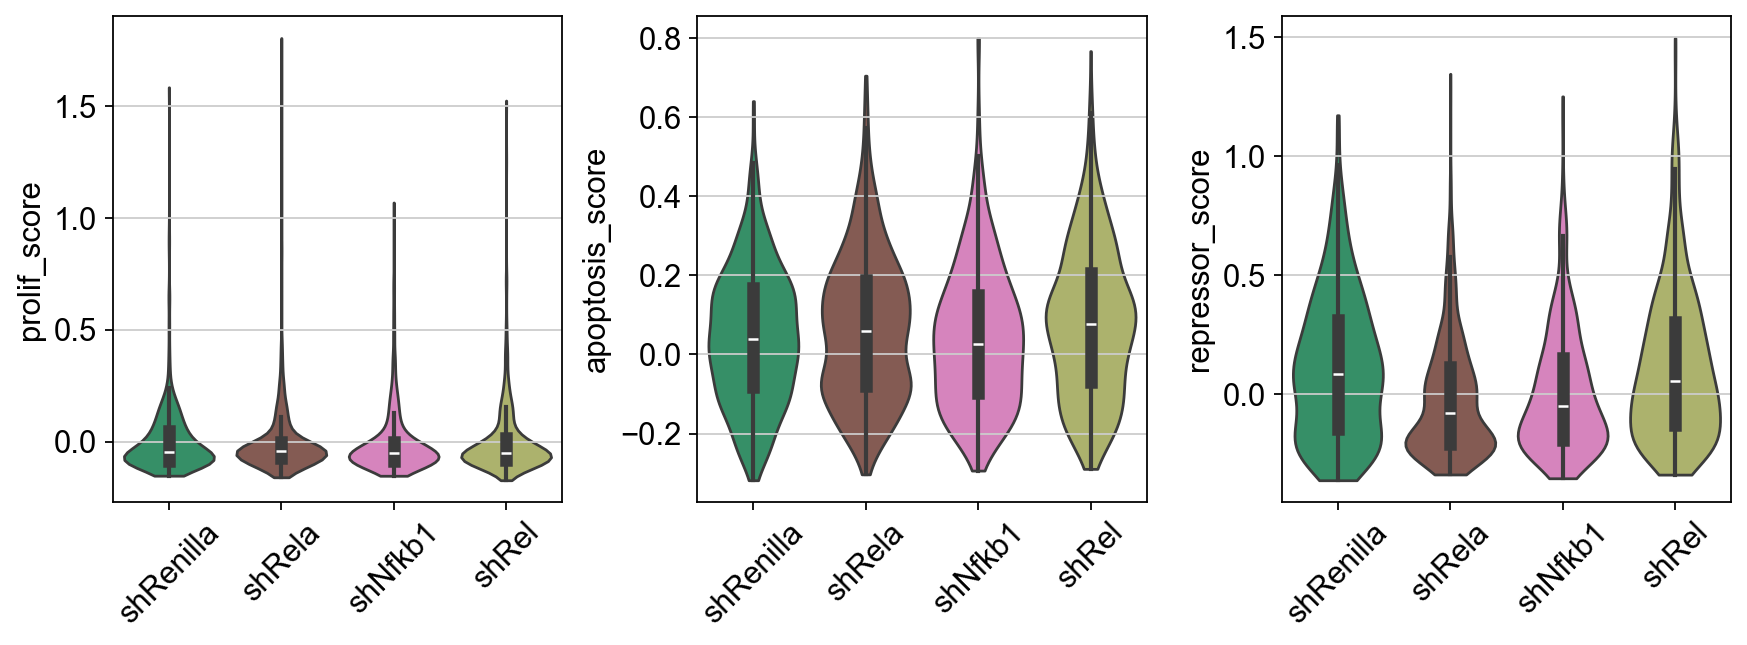

In [35]:
# Check if HP2 has fewer cells in scRNA-seq
cell_counts = adata.obs['Group'].value_counts()
print(cell_counts)

# If HP2 has dramatically fewer cells than HP1, this supports selection

# Look at proliferation/apoptosis markers
proliferation_genes = ['Mki67', 'Pcna', 'Top2a', 'Ccnb1']
apoptosis_genes = ['Bax', 'Bak1', 'Casp3', 'Casp7', 'Casp9']
repressor_genes = ['Nfkbia', 'Nos2', 'Ptgs2', 'Il12b', 'Ccl2']

# Score these
sc.tl.score_genes(adata, gene_list=proliferation_genes, score_name='prolif_score',use_raw=True)
sc.tl.score_genes(adata, gene_list=apoptosis_genes, score_name='apoptosis_score',use_raw=True)
sc.tl.score_genes(adata, gene_list=repressor_genes, score_name='repressor_score',use_raw=True)

# Compare
sc.pl.violin(adata, keys=['prolif_score', 'apoptosis_score','repressor_score'], 
             groupby='Group',rotation=45, stripplot=False, inner='box')

# If HP2 cells have LOWER proliferation than HP1,
# but tumor burden isn't reduced → selection for slow-cycling resistant cells

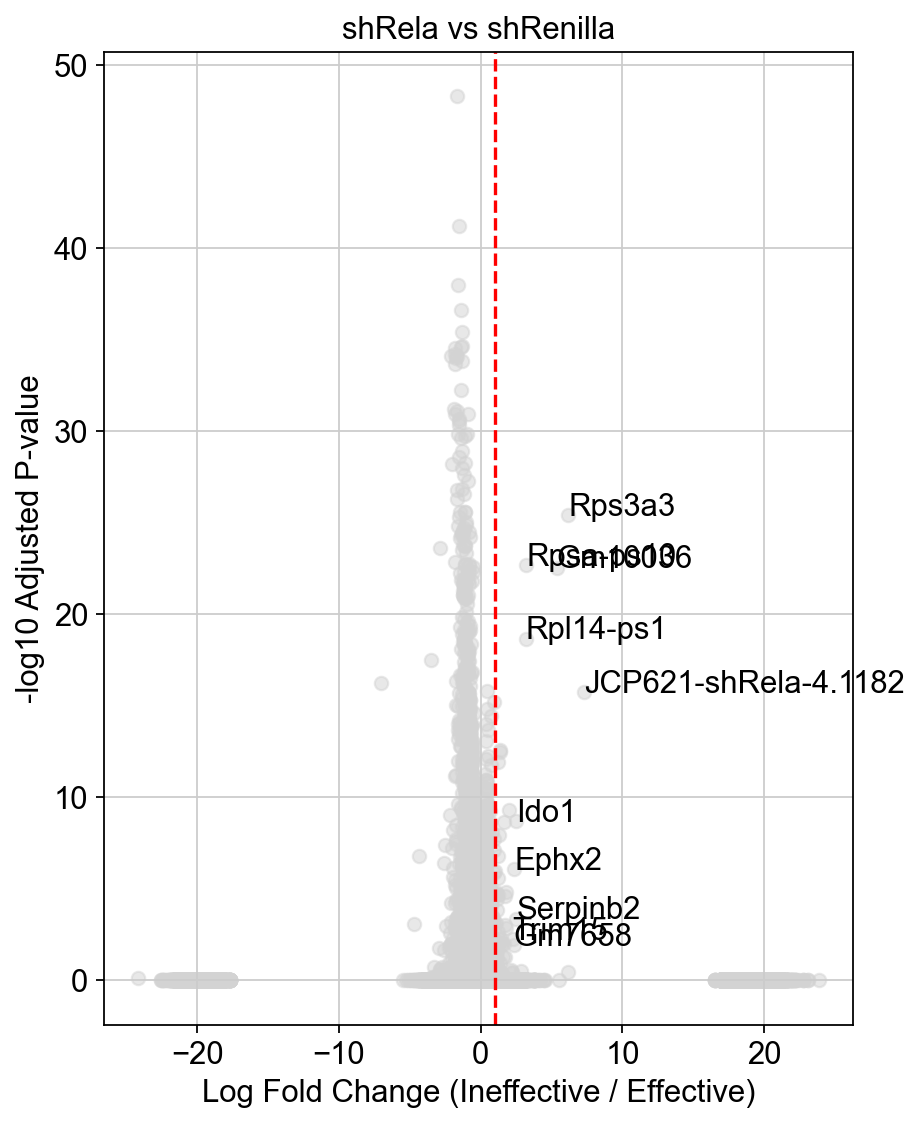

In [36]:
# 2. Extract the data for the volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shRela'],
    'logfoldchanges': result['logfoldchanges']['shRela'],
    'pvals_adj': result['pvals_adj']['shRela']
})

# 3. Plotting
plt.figure(figsize=(6, 8))
plt.scatter(df['logfoldchanges'], -np.log10(df['pvals_adj'] + 1e-300), 
            alpha=0.5, c='lightgrey')

# Highlight top cycling and NF-kB genes
top_genes = df[df['pvals_adj'] < 0.05].sort_values('logfoldchanges', ascending=False).head(10)
for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj'] + 1e-300), row['gene'])

plt.axvline(1, color='red', linestyle='--')
plt.xlabel('Log Fold Change (Ineffective / Effective)')
plt.ylabel('-log10 Adjusted P-value')
plt.title('shRela vs shRenilla')
plt.show()

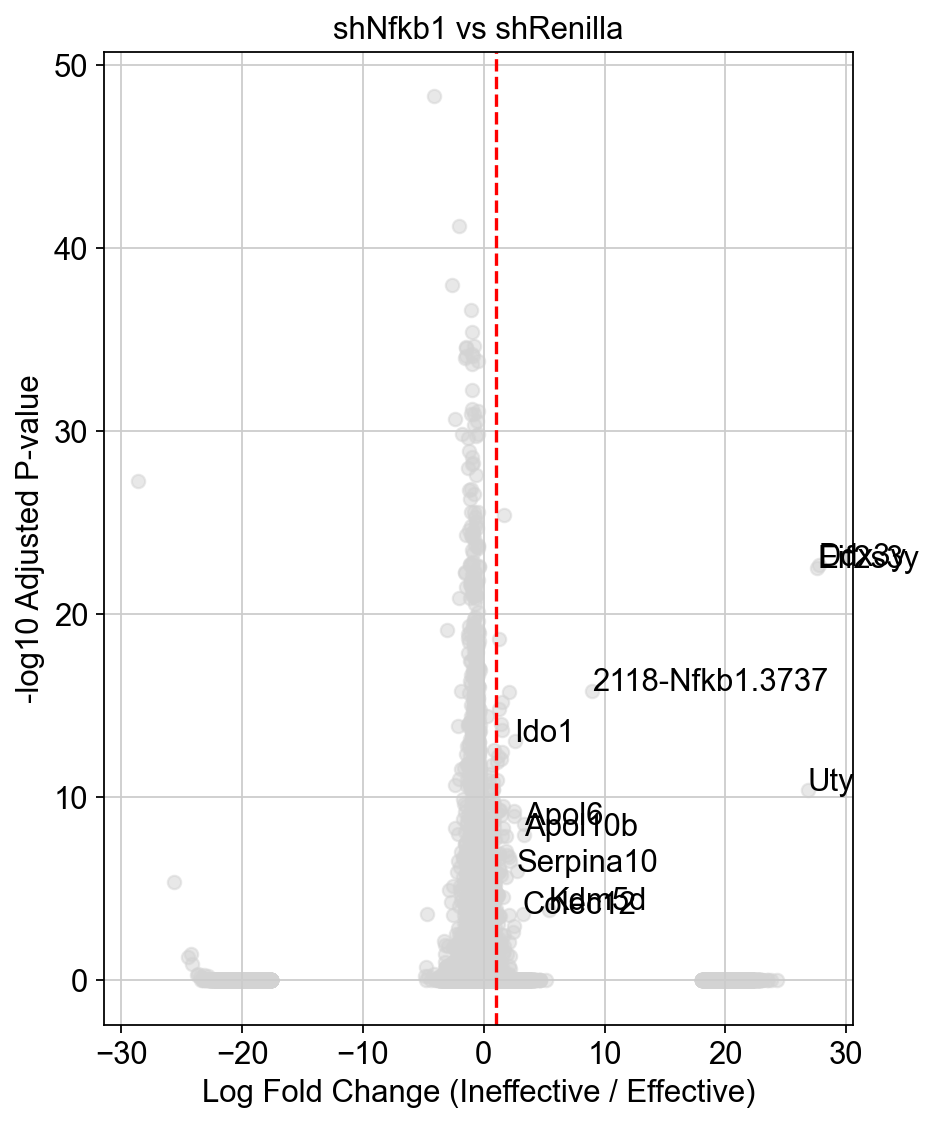

In [37]:
# 2. Extract the data for the volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1'],
    'pvals_adj': result['pvals_adj']['shRela']
})

# 3. Plotting
plt.figure(figsize=(6, 8))
plt.scatter(df['logfoldchanges'], -np.log10(df['pvals_adj'] + 1e-300), 
            alpha=0.5, c='lightgrey')

# Highlight top cycling and NF-kB genes
top_genes = df[df['pvals_adj'] < 0.05].sort_values('logfoldchanges', ascending=False).head(10)
for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj'] + 1e-300), row['gene'])

plt.axvline(1, color='red', linestyle='--')
plt.xlabel('Log Fold Change (Ineffective / Effective)')
plt.ylabel('-log10 Adjusted P-value')
plt.title('shNfkb1 vs shRenilla')
plt.show()

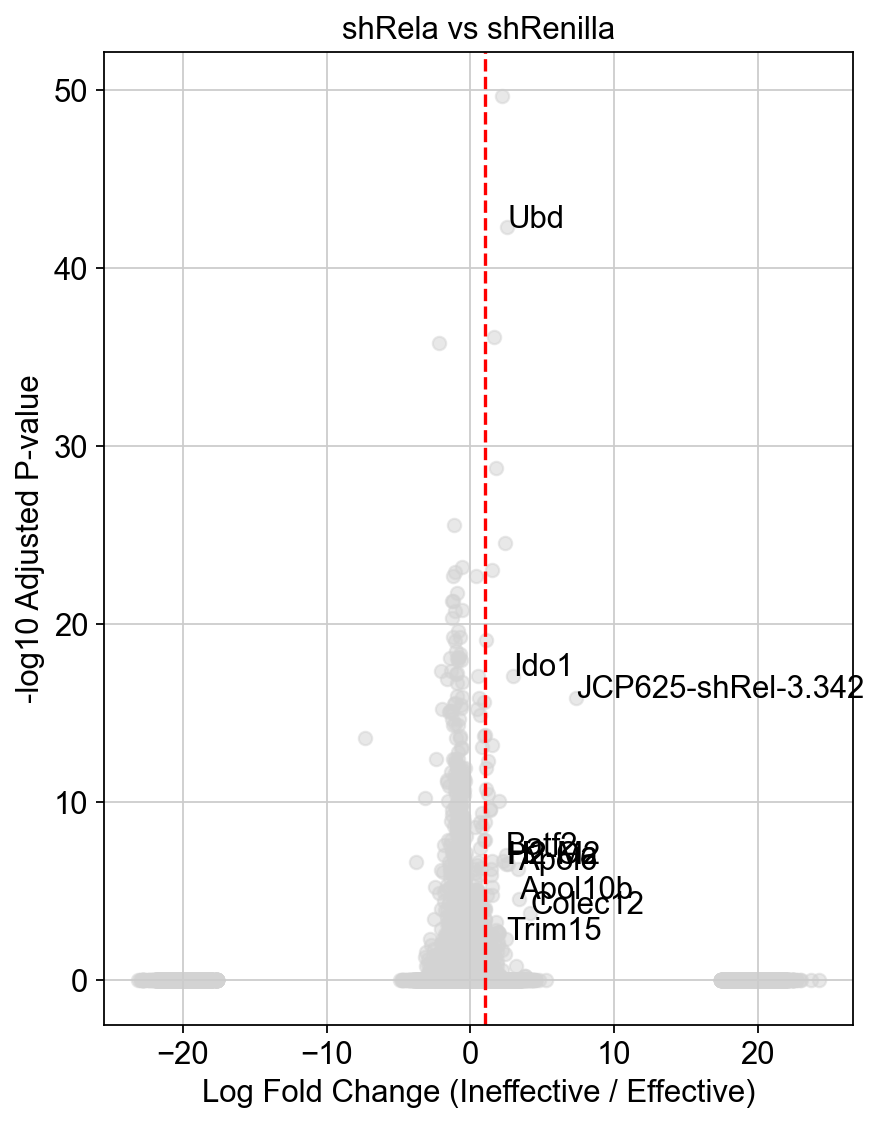

In [38]:
# 2. Extract the data for the volcano plot
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shRel'],
    'logfoldchanges': result['logfoldchanges']['shRel'],
    'pvals_adj': result['pvals_adj']['shRel']
})

# 3. Plotting
plt.figure(figsize=(6, 8))
plt.scatter(df['logfoldchanges'], -np.log10(df['pvals_adj'] + 1e-300), 
            alpha=0.5, c='lightgrey')

# Highlight top cycling and NF-kB genes
top_genes = df[df['pvals_adj'] < 0.05].sort_values('logfoldchanges', ascending=False).head(10)
for i, row in top_genes.iterrows():
    plt.text(row['logfoldchanges'], -np.log10(row['pvals_adj'] + 1e-300), row['gene'])

plt.axvline(1, color='red', linestyle='--')
plt.xlabel('Log Fold Change (Ineffective / Effective)')
plt.ylabel('-log10 Adjusted P-value')
plt.title('shRela vs shRenilla')
plt.show()

In [39]:
import gseapy as gp

# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))

                               Term  Adjusted P-value  Combined Score
0         Interferon Gamma Response      5.202972e-37     3854.143603
1         Interferon Alpha Response      3.782327e-16     1309.999125
2              IL-2/STAT5 Signaling      1.477604e-03       53.295995
3                        Complement      1.477604e-03       52.825079
4             Inflammatory Response      1.477604e-03       52.825079
5                         Apoptosis      2.518751e-03       51.245397
6     TNF-alpha Signaling via NF-kB      5.845821e-03       34.882141
7                       p53 Pathway      5.845821e-03       34.882141
8               Allograft Rejection      2.804256e-02       21.333767
9          IL-6/JAK/STAT3 Signaling      5.385535e-02       24.834990
10                Androgen Response      7.060474e-02       19.594255
11                 mTORC1 Signaling      9.281250e-02       11.672654
12  Reactive Oxygen Species Pathway      9.281250e-02       23.676317
13                  

## Explore Phase

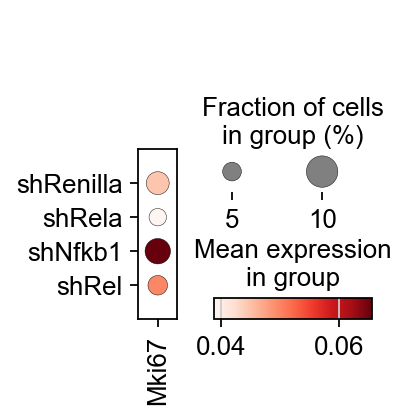

In [40]:
sc.pl.dotplot(adata,['Mki67'],groupby='Group',use_raw=True)

In [41]:
cell_cycle_genes = [x.strip() for x in open('../../common_files/regev_lab_cell_cycle_genes_mouse.txt')]

In [42]:
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [43]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes,use_raw=True)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    512 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    557 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


computing PCA
    with n_comps=12
    finished (0:00:00)


/home/chanj2/part2a-decoupler/lib/python3.11/site-packages/scanpy/preprocessing/_pca/__init__.py:384: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = x_pca


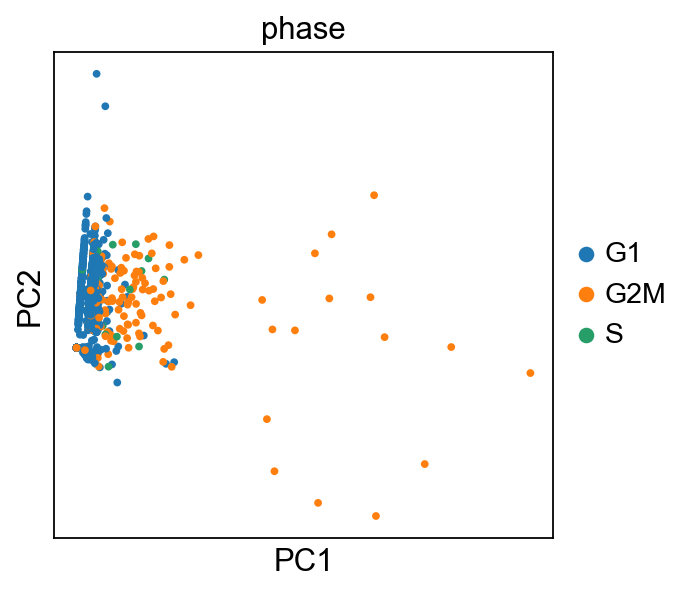

In [44]:
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')

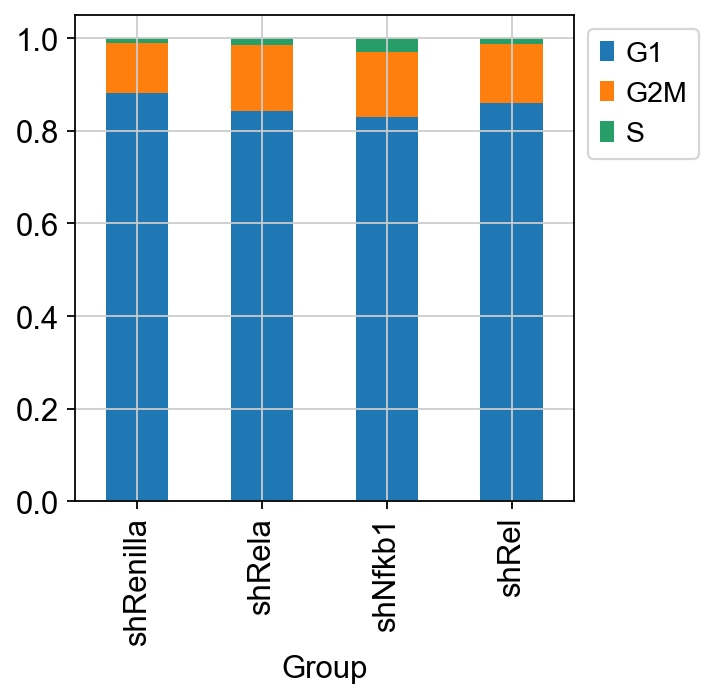

In [45]:
 cell_proportion_df = pd.crosstab(adata.obs['phase'],adata.obs['Group'], normalize='columns').T.plot(kind='bar', stacked=True).legend(bbox_to_anchor=(1,1))

In [46]:
cell_proportion_df = pd.crosstab(adata.obs['phase'],adata.obs['Group'], normalize='columns').T
cell_proportion_df

phase            G1       G2M         S
Group                                  
shRenilla  0.881391  0.108384  0.010225
shRela     0.841820  0.144095  0.014085
shNfkb1    0.829146  0.140704  0.030151
shRel      0.859375  0.128125  0.012500

In [47]:
adata.obs[['Classification','Group','phase']].value_counts(sort=False)


Classification         Group      phase
BD1939_B0303           shNfkb1    G1        67
                                  G2M        8
BD1941_B0306           shRela     G1       229
                                  G2M       30
                                  S          3
BE1137_B0304           shNfkb1    G1         2
                                  G2M        2
                                  S          1
BE1139_B0307           shRela     G1        45
                                  G2M        7
BE1140-NT_B0308        shRela     G1       173
                                  G2M       32
                                  S          4
BE1155_(BD1672)_B0302  shNfkb1    G1       104
                                  G2M       17
                                  S          1
BE1156_(BD1671)_B0301  shNfkb1    G1       157
                                  G2M       29
                                  S         10
BE1157_(BD1674)_B0305  shRela     G1       330
                    

computing score 'STAT3_score'
    finished: added
    'STAT3_score', score of gene set (adata.obs).
    150 total control genes are used. (0:00:00)
computing score 'PI3K/AKT_score'
    finished: added
    'PI3K/AKT_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'WNT_score'
    finished: added
    'WNT_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)
computing score 'MAPK_score'
    finished: added
    'MAPK_score', score of gene set (adata.obs).
    100 total control genes are used. (0:00:00)
computing score 'HIF_score'
    finished: added
    'HIF_score', score of gene set (adata.obs).
    50 total control genes are used. (0:00:00)


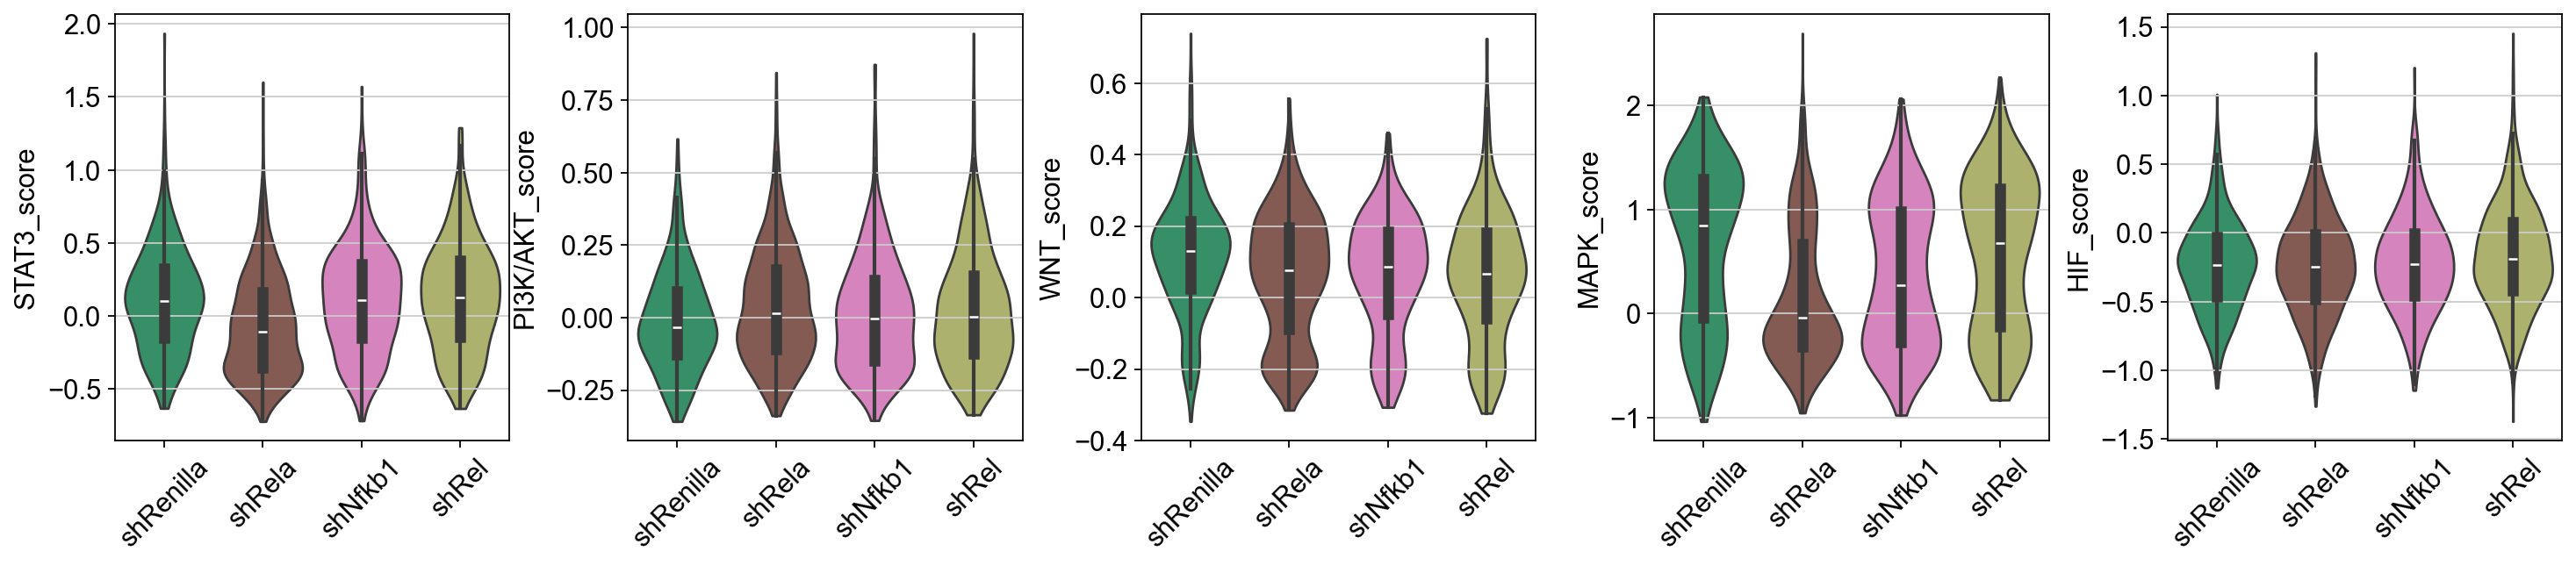

                shRenilla  shNfkb1_2331  shNfkb1_3737  HP2_vs_HP1
STAT3_score      0.110243           NaN           NaN         NaN
PI3K/AKT_score  -0.010019           NaN           NaN         NaN
WNT_score        0.116483           NaN           NaN         NaN
MAPK_score       0.668654           NaN           NaN         NaN
HIF_score       -0.233362           NaN           NaN         NaN


In [48]:
# Check alternative survival pathways
survival_pathways = {
    'STAT3': ['Stat3', 'Socs3', 'Bcl2l1', 'Mcl1'],
    'PI3K/AKT': ['Akt1', 'Akt2', 'Pdk1', 'Mtor'],
    'WNT': ['Ctnnb1', 'Axin2', 'Lef1', 'Tcf7'],
    'MAPK': ['Mapk1', 'Mapk3', 'Fos', 'Jun'],
    'HIF': ['Hif1a', 'Vegfa', 'Ldha', 'Pgk1']
}

# Score each pathway
for pathway, genes in survival_pathways.items():
    sc.tl.score_genes(adata, gene_list=genes, 
                     score_name=f'{pathway}_score',use_raw=True)

# Compare across groups
pathway_scores = [f'{p}_score' for p in survival_pathways.keys()]
sc.pl.violin(adata, keys=pathway_scores, groupby='Group', rotation=45, stripplot=False, inner='box')

# Look for HP2-specific upregulation
import pandas as pd
pathway_comparison = pd.DataFrame()
for score in pathway_scores:
    for group in ['shRenilla', 'shNfkb1_2331', 'shNfkb1_3737']:
        cells = adata.obs['Group'] == group
        pathway_comparison.loc[score, group] = adata[cells].obs[score].mean()

pathway_comparison['HP2_vs_HP1'] = (pathway_comparison['shNfkb1_3737'] / 
                                    pathway_comparison['shNfkb1_2331'])
print(pathway_comparison.sort_values('HP2_vs_HP1', ascending=False))

# If any pathway shows >1.5x in HP2 vs HP1 → compensation mechanism

computing score 'stemness_score'
    finished: added
    'stemness_score', score of gene set (adata.obs).
    200 total control genes are used. (0:00:00)


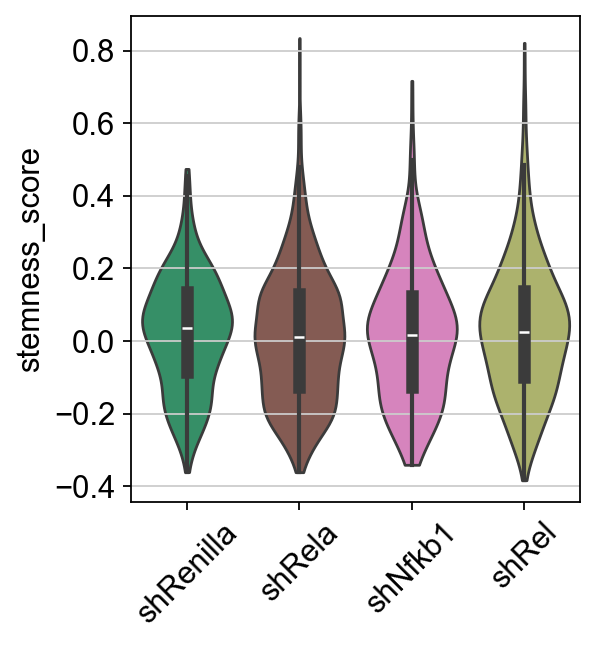

In [49]:
# p50 tumor suppressor functions:
# - Limits cancer stem cell self-renewal
# - Promotes differentiation
# - Limits metabolic reprogramming

# Check stem cell markers
stemness_genes = ['Cd44', 'Aldh1a1', 'Sox2', 'Nanog', 'Pou5f1']
differentiation_genes = ['Krt18', 'Cdh1', 'Epcam']  # Adjust for your tumor type

sc.tl.score_genes(adata, gene_list=stemness_genes, score_name='stemness_score',use_raw=True)

sc.pl.violin(adata, keys='stemness_score', groupby='Group',rotation=45, inner='box', stripplot=False)

# If HP2 has HIGHER stemness → too much p50 loss promotes cancer stem cells
# This would maintain tumor burden despite NFκB suppression


### 4. **Non-Linear Dose Response / "Goldilocks Zone"**



In [50]:
# Are different cell states enriched in HP2?
from scipy.stats import chi2_contingency

contingency = pd.crosstab(adata.obs['leiden'], adata.obs['Group'])
chi2, pval, dof, expected = chi2_contingency(contingency)

print(f"Cell composition differs across groups: p={pval:.2e}")

# Which clusters are enriched in HP2?
props = pd.crosstab(adata.obs['leiden'], adata.obs['Group'], normalize='columns')
#props['HP2_enrichment'] = props['shNfkb1_2331'] / props['shNfkb1_3737']
print(props.sort_values('shRenilla', ascending=False))

# If certain clusters are enriched in HP2 → selection

Cell composition differs across groups: p=7.91e-63
Group   shRenilla    shRela   shNfkb1     shRel
leiden                                         
0        0.435583  0.244854  0.364322  0.218750
2        0.343558  0.258938  0.366834  0.457813
1        0.116564  0.406284  0.165829  0.190625
3        0.055215  0.082340  0.092965  0.121875
5        0.026585  0.001083  0.000000  0.001563
6        0.022495  0.001083  0.000000  0.000000
4        0.000000  0.005417  0.010050  0.009375


In [51]:
# Known NFκB-independent survival genes
resistance_genes = ['Yap1', 'Taz', 'Myc', 'Sox2', 'Stat3', 'Akt1','Sox11']

resistance_expr = pd.DataFrame()
for gene in resistance_genes:
    if gene in adata.var_names:
        for group in ['shRenilla', 'shRela', 'shNfkb1', 'shRel']:
            cells = adata.obs['Group'] == group
            resistance_expr.loc[gene, group] = adata.raw[cells, gene].X.mean()

resistance_expr['shRela_vs_shRenilla'] = (resistance_expr['shRela'] / 
                                 resistance_expr['shRenilla'])
resistance_expr['shNfkb1_vs_shRenilla'] = (resistance_expr['shNfkb1'] / 
                                 resistance_expr['shRenilla'])
resistance_expr['shRel_vs_shRenilla'] = (resistance_expr['shRel'] / 
                                 resistance_expr['shRenilla'])
print(resistance_expr.sort_values('shRela_vs_shRenilla', ascending=False))

# Genes >2x in HP2 → compensation mechanisms

       shRenilla    shRela   shNfkb1     shRel  shRela_vs_shRenilla  \
Akt1    0.498621  0.548874  0.486288  0.559965             1.100783   
Yap1    0.318849  0.221218  0.346043  0.294172             0.693802   
Stat3   0.801947  0.536929  0.718840  0.724396             0.669532   
Taz     0.170556  0.105221  0.177974  0.182139             0.616928   
Myc     0.249643  0.136676  0.196782  0.251581             0.547487   
Sox2    0.015640  0.003868  0.013177  0.015968             0.247331   
Sox11   0.003396  0.000000  0.000000  0.003098             0.000000   

       shNfkb1_vs_shRenilla  shRel_vs_shRenilla  
Akt1               0.975264            1.123027  
Yap1               1.085287            0.922604  
Stat3              0.896369            0.903296  
Taz                1.043497            1.067913  
Myc                0.788253            1.007763  
Sox2               0.842542            1.020971  
Sox11              0.000000            0.912264  


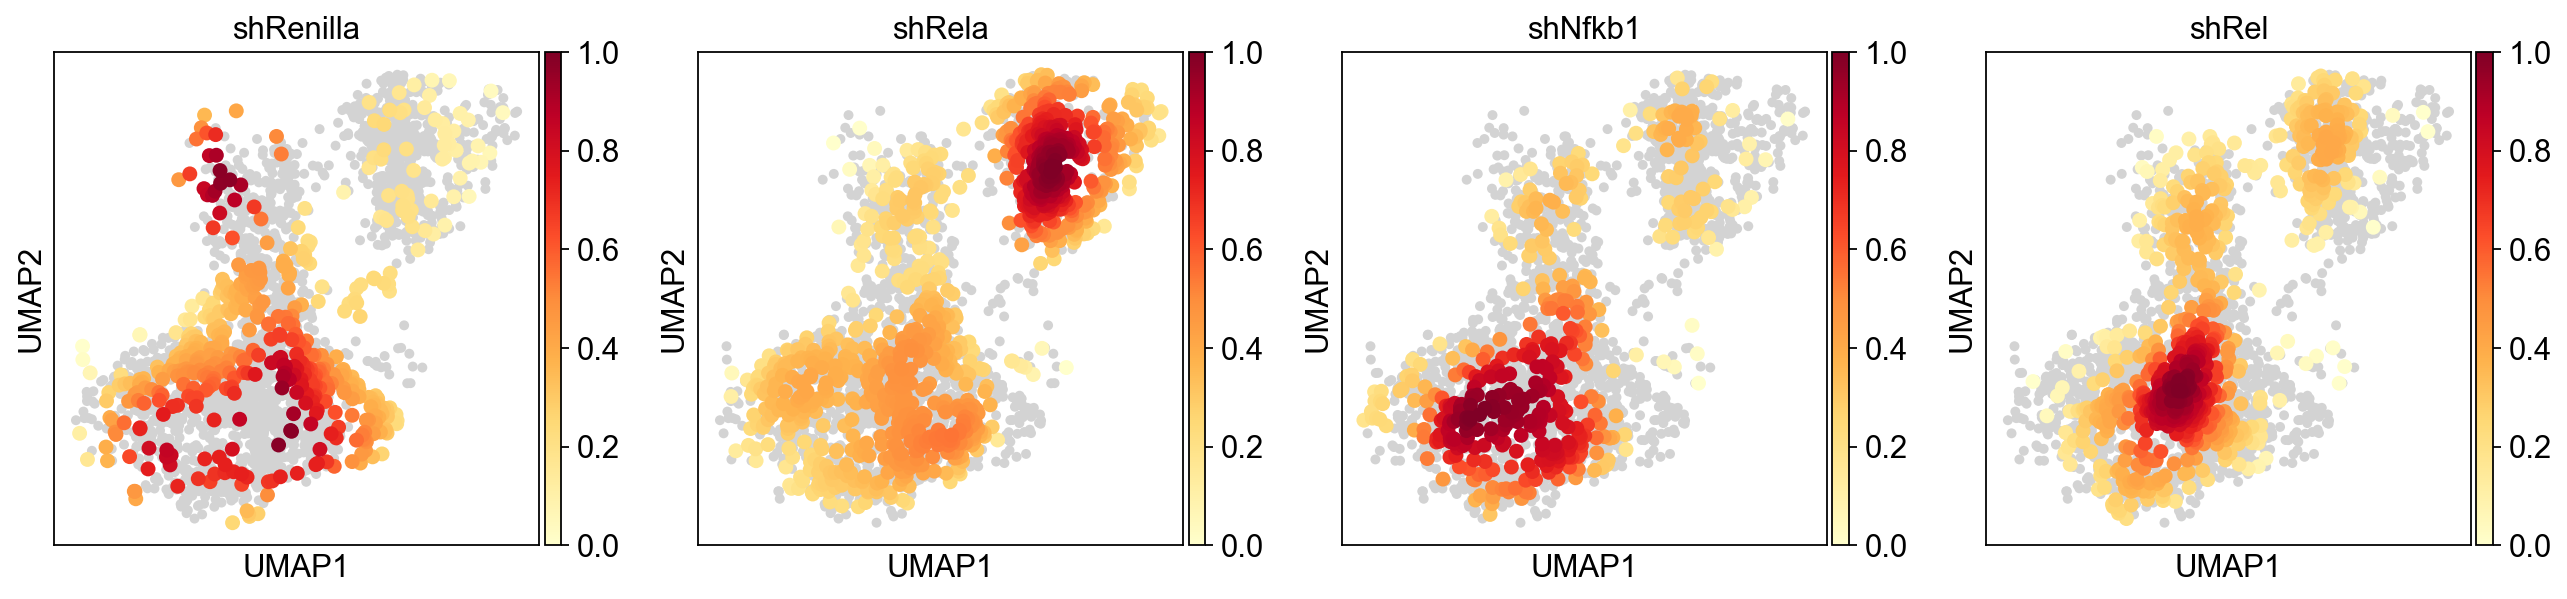

In [52]:
sc.pl.embedding_density(adata, basis='umap', key='umap_density_Group')

## Define scoring functions

In [53]:
# Score Cluster 5 cells
import csv
clusters = {}
clusterkeys = []
HPCS = False

def resetClusters(hpcs = 'cell2020'):
    clusters = {}
    clusterkeys = []
    HPCS = False
    try:
        if hpcs == 'cell2020':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'cell2020_no_Slc4a11':         
            with open('../../common_files/clusters_cell2020.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                for row in csvreader:
                    clusters[row[0]] = [x for x in row[1:] if x != '']   
                    if 'Slc4a11' in clusters[row[0]]:
                        clusters[row[0]].remove('Slc4a11')
                        print("Slc4a11 removed")
            for i in range(1,13):
                #if i == 9: continue
                clusterkeys.append('Cluster %i' % i)
            HPCS = 'Cluster 5'
        elif hpcs == 'nfkb':         
            with open('../../common_files/hallmark_tnfanfkb.csv',encoding='utf-8-sig') as csvfile:
                csvreader = csv.reader(csvfile, delimiter=",")
                clusters['nfkb'] = [x for row in csvreader for x in row]
            clusterkeys.append('nfkb')
            HPCS = 'nfkb'
        else:
            raise ValueError
    except ValueError:
        print("%s is an invalid choice" % hpcs)
        raise
    return (clusters, clusterkeys, HPCS)

(clusters, clusterkeys, HPCS) = resetClusters('cell2020')

In [54]:
def scoreAndPlot(ad, excludeList = None, groupby="Classification",rotation=90,numgenes=25,ctlgenes=25):
    #cmap = 'Reds' #colormap
    cmap = 'jet' #colormap
    if excludeList == None:
        for i in clusterkeys:
            if (numgenes > ctlgenes):
                ctlgenes = numgenes
            sc.tl.score_genes(ad, clusters[i][0:numgenes],score_name="%s" % i, ctrl_size=ctlgenes,use_raw=True)  
        #sc.tl.score_genes(ad, clusters['Highly_mixed'],score_name="Highly_mixed")
  
        sc.pl.umap(ad, color=clusterkeys, color_map=cmap)
        sc.pl.dotplot(ad, clusterkeys, groupby=groupby, swap_axes=True)

In [55]:
from scipy.stats import ranksums

def HPCSViolinPlot(ad, cluster='0', groupby='leiden', score='Cluster5', save=None, singleGene=False):
    ad.obs['Cl5'] = 'not HPCS'
    ad.obs.loc[ad.obs[groupby].isin([cluster]), 'Cl5'] = 'HPCS'

    if singleGene:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray(),ad[~ad.obs['Cl5'].isin(['HPCS'])][:,score].X.toarray())[1]
        #sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)
    else:
        pvalue = ranksums(ad[ad.obs['Cl5'].isin(['HPCS'])].obs[score],ad[ad.obs['Cl5'].isin(['not HPCS'])].obs[score])[1]
    sc.pl.violin(ad, score, groupby='Cl5', xlabel = 'p = ' + str(pvalue), save=save)

computing score 'Cluster 1'
    finished: added
    'Cluster 1', score of gene set (adata.obs).
    1397 total control genes are used. (0:00:00)
computing score 'Cluster 2'
    finished: added
    'Cluster 2', score of gene set (adata.obs).
    1293 total control genes are used. (0:00:00)
computing score 'Cluster 3'
    finished: added
    'Cluster 3', score of gene set (adata.obs).
    1196 total control genes are used. (0:00:00)
computing score 'Cluster 4'
    finished: added
    'Cluster 4', score of gene set (adata.obs).
    1495 total control genes are used. (0:00:00)
computing score 'Cluster 5'
    finished: added
    'Cluster 5', score of gene set (adata.obs).
    1493 total control genes are used. (0:00:00)
computing score 'Cluster 6'
    finished: added
    'Cluster 6', score of gene set (adata.obs).
    1990 total control genes are used. (0:00:00)
computing score 'Cluster 7'
    finished: added
    'Cluster 7', score of gene set (adata.obs).
    1190 total control genes are u

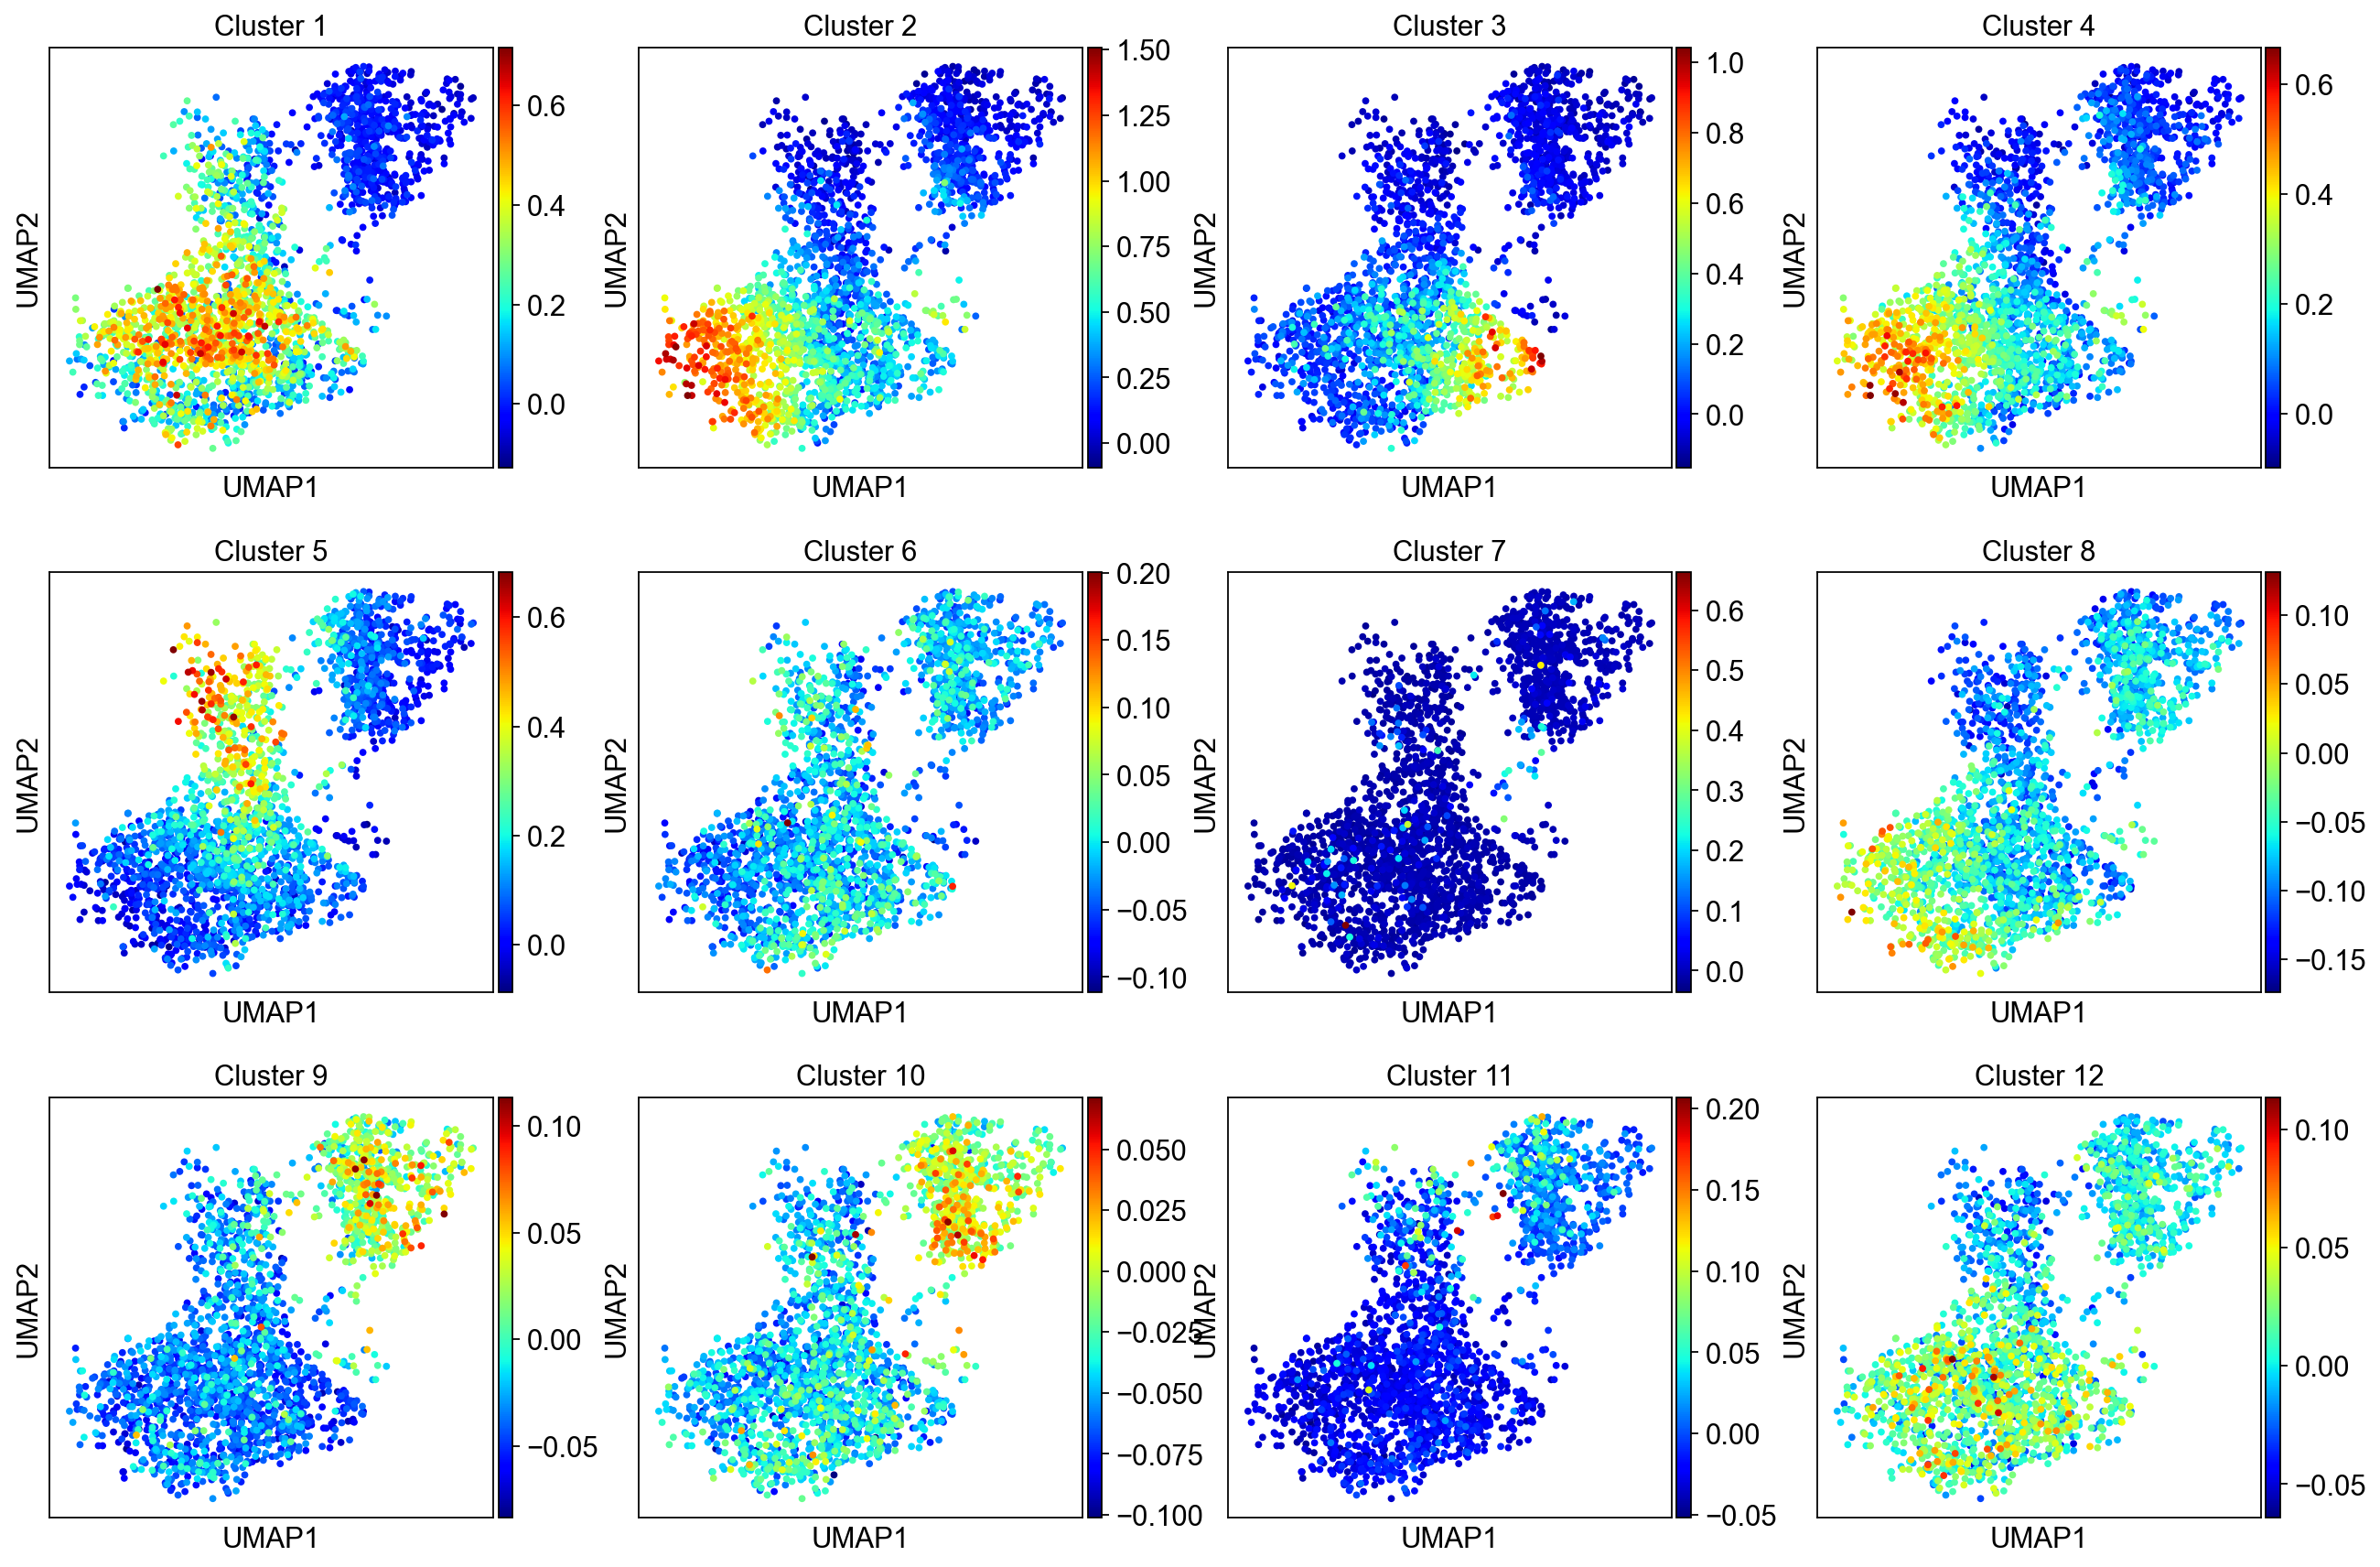

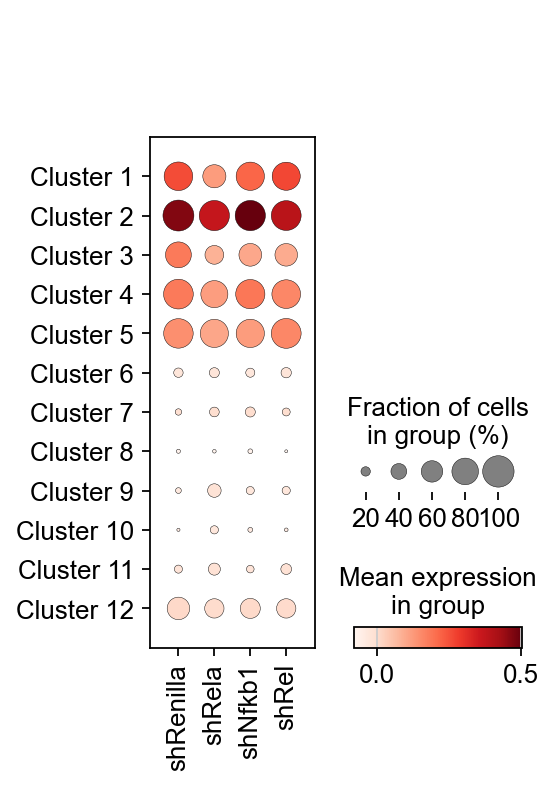

In [56]:
scoreAndPlot(adata, groupby='Group',numgenes=100)

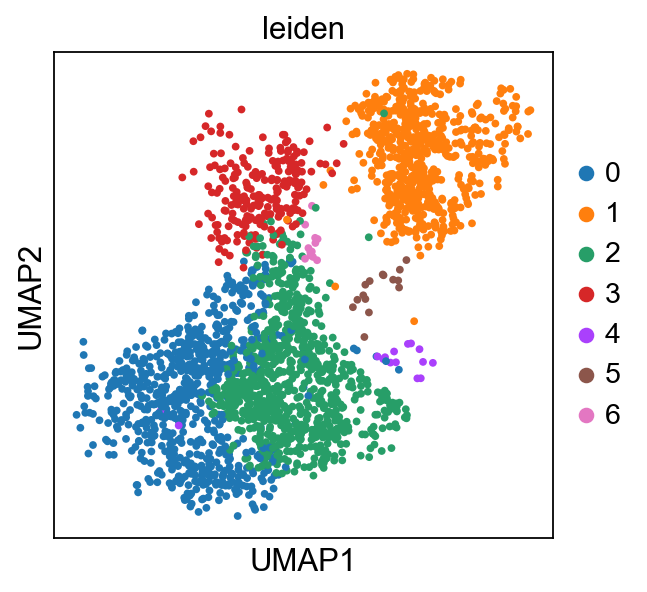

In [57]:
sc.pl.umap(adata,color=['leiden'])

In [58]:
df

gene  logfoldchanges     pvals_adj
0          Gbp4        2.232340  2.201718e-50
1           Ubd        2.583515  5.018490e-43
2          Gbp2        1.675935  7.149187e-37
3          Gbp8        1.797732  1.786379e-29
4      Serping1        2.428996  2.629559e-25
...         ...             ...           ...
30139     Sparc       -1.168110  1.966834e-23
30140      Ctsc       -1.074556  1.195292e-23
30141      Oaz1       -0.558692  5.880983e-24
30142      Ppic       -1.125298  2.588488e-26
30143     Crlf1       -2.167187  1.686198e-36

[30144 rows x 3 columns]

In [59]:
df = adata.obs.copy()

pb_cluster5 = (
    df.groupby(["Classification", "Group"])["Cluster 5"]
      .mean()
      .reset_index()
)

pb_nfkb = (
    df.groupby(["Classification", "Group"])["hallmark_nfkb"]
      .mean()
      .reset_index()
)

# df2 = adata[~adata.obs.Classification.isin(['AX1508_2117','AX1598_2117','AW1555_2118']),:].obs.copy()
# pb_cluster5a = (
#     df2.groupby(["Classification", "Group"])["Cluster 5"]
#       .mean()
#       .reset_index()
# )
# pb_nfkba = (
#     df2.groupby(["Classification", "Group"])["hallmark_nfkb"]
#       .mean()
#       .reset_index()
# )

/tmp/ipykernel_2029983/2583428365.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["Cluster 5"]
/tmp/ipykernel_2029983/2583428365.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(["Classification", "Group"])["hallmark_nfkb"]


Text(0, 0.5, 'Mean hallmark_nfkb expression per mouse')

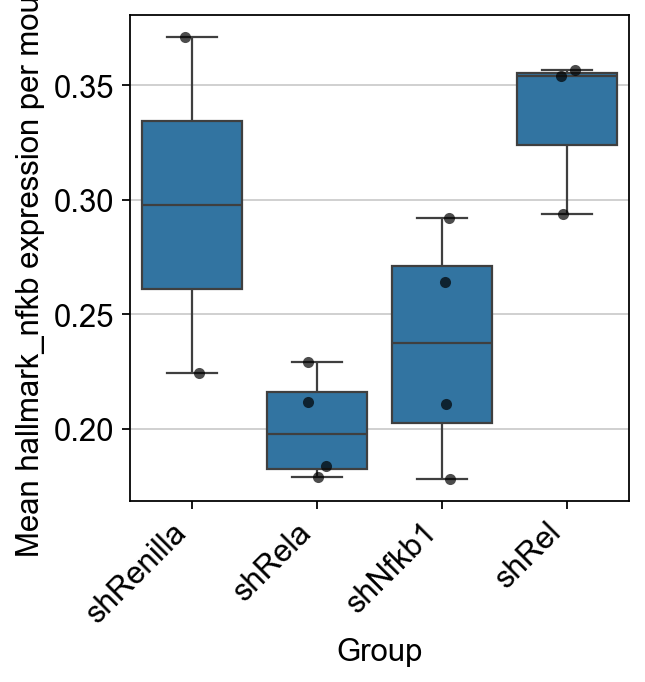

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_nfkb,
    x="Group",
    y="hallmark_nfkb",
    showfliers=False,
)
sns.stripplot(
    data=pb_nfkb,
    x="Group",
    y="hallmark_nfkb",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean hallmark_nfkb expression per mouse")


Text(0, 0.5, 'Mean Cluster 5 expression per mouse')

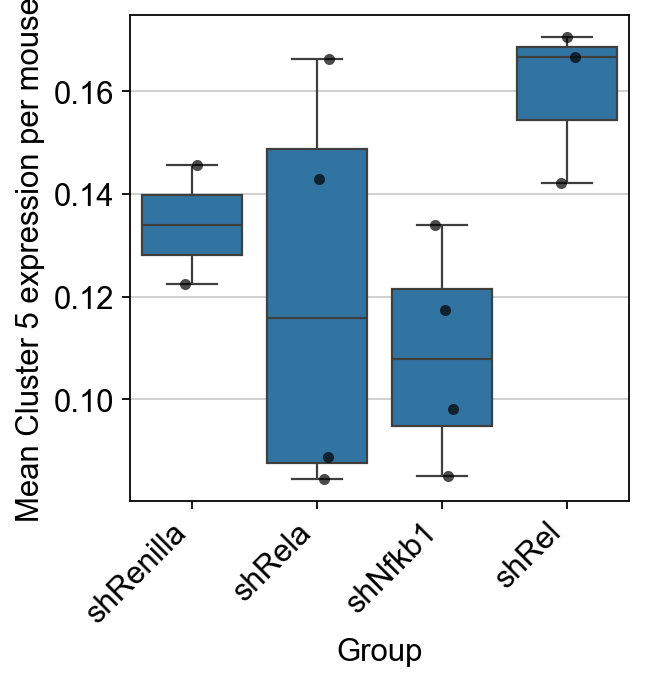

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(
    data=pb_cluster5,
    x="Group",
    y="Cluster 5",
    showfliers=False,
)
sns.stripplot(
    data=pb_cluster5,
    x="Group",
    y="Cluster 5",
    color="black",
    alpha=0.7
)

plt.xticks(rotation=45, ha='right')

plt.ylabel("Mean Cluster 5 expression per mouse")


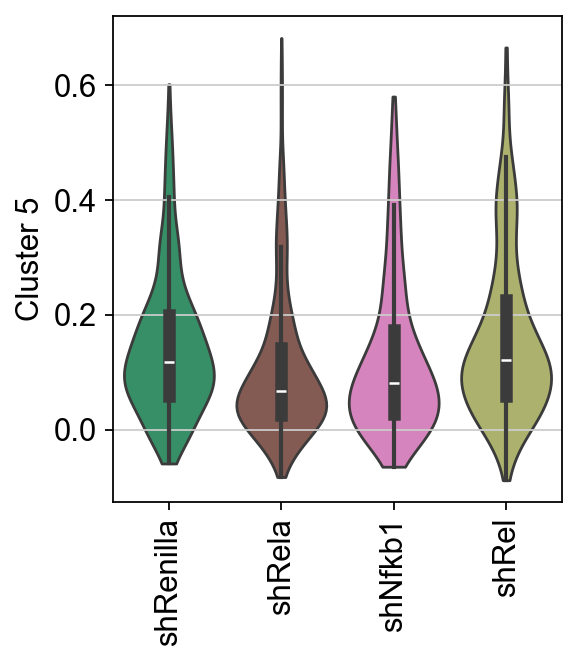

In [62]:
sc.pl.violin(adata[df.index,:], 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

## Examine differential expression

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


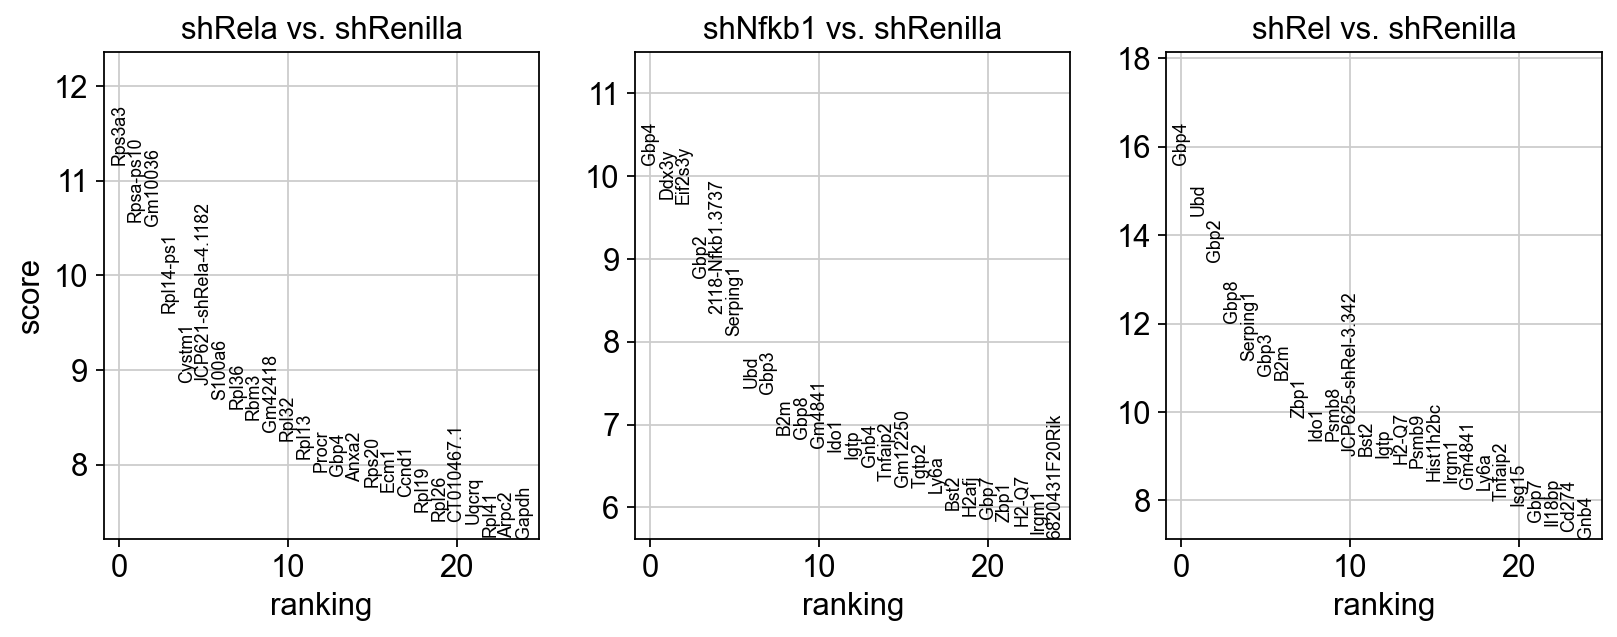

    using 'X_pca' with n_pcs = 150
Storing dendrogram info using `.uns['dendrogram_leiden']`
categories: 0, 1, 2, etc.
var_group_labels: shRela, shNfkb1, shRel


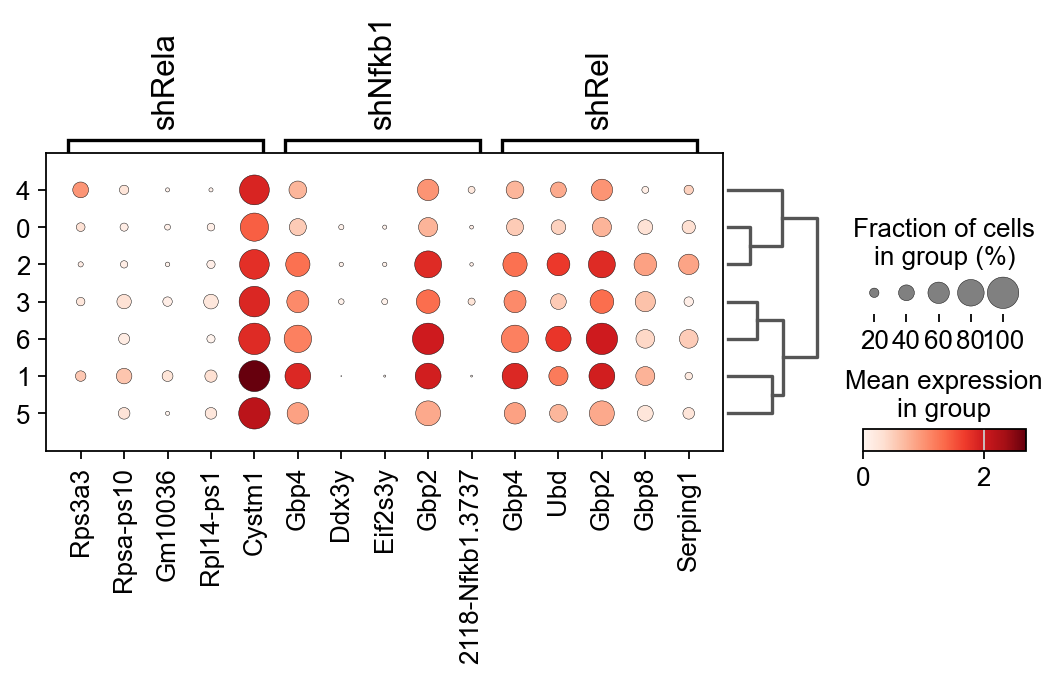

In [63]:
sc.tl.rank_genes_groups(adata, 'Group', method='wilcoxon',reference='shRenilla',use_raw=True)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5, groupby="leiden")


## Look within whole tumor

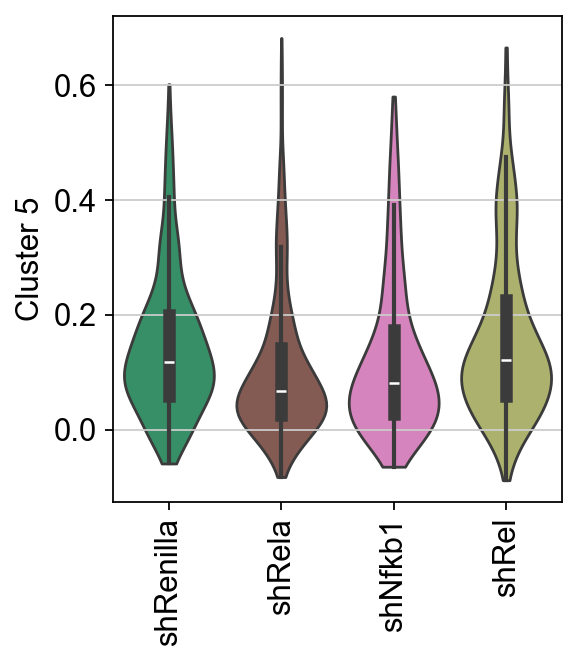

In [64]:
sc.pl.violin(adata, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

In [65]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shRela']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(283934.0), pvalue=np.float64(1.3317864398552126e-15))

In [66]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shNfkb1']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(113721.0), pvalue=np.float64(1.5324025865929045e-05))

In [67]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shRel']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(152308.0), pvalue=np.float64(0.44223710021687435))

## Now look within the HPCS cluster

In [68]:
adata2 = adata[adata.obs.leiden.isin(['3']),:].copy()

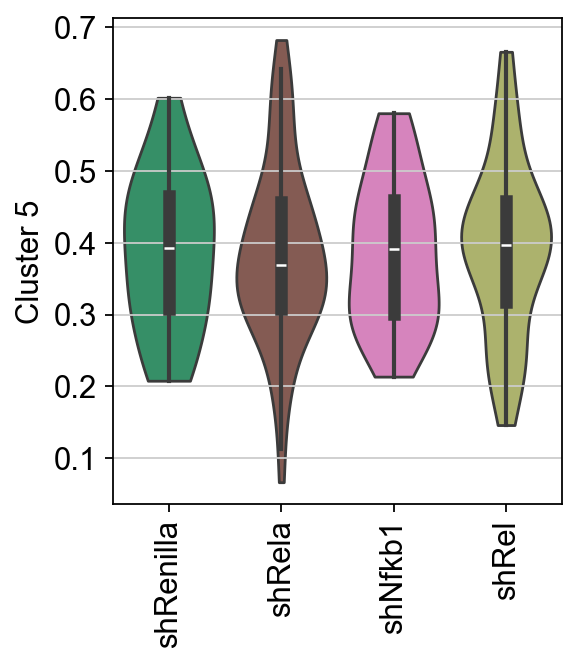

In [69]:
sc.pl.violin(adata2, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False,use_raw=True)

In [70]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shRela']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(1066.0), pvalue=np.float64(0.7670787464104453))

In [71]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shNfkb1']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(511.0), pvalue=np.float64(0.8811312138090605))

In [72]:
import scipy
scipy.stats.mannwhitneyu(adata2[adata2.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata2[adata2.obs.Group.isin(['shRel']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(1032.0), pvalue=np.float64(0.8805270081170201))

## Evaluate differences in Groups via EnrichR

In [73]:
result = adata2.uns['rank_genes_groups']
groups = result['names'].dtype.names
results_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','scores']}) #.to_excel('test.xlsx')
#results_df.to_excel('write/leiden.xlsx')

In [74]:
import gseapy
#Available databases : ‘Human’, ‘Mouse’, ‘Yeast’, ‘Fly’, ‘Fish’, ‘Worm’ 
gene_set_names = gseapy.get_library_name(organism='Mouse')
print(gene_set_names)
#gsets = 'Descartes_Cell_Types_and_Tissue_2021'
#gsets = 'Tabula_Muris'
gsets = 'MSigDB_Hallmark_2020'
#gsets = 'The_Kinase_Library_2023'
#gsets = 'TF_Perturbations_Followed_by_Expression'

['ARCHS4_Cell-lines', 'ARCHS4_IDG_Coexp', 'ARCHS4_Kinases_Coexp', 'ARCHS4_TFs_Coexp', 'ARCHS4_Tissues', 'Achilles_fitness_decrease', 'Achilles_fitness_increase', 'Aging_Perturbations_from_GEO_down', 'Aging_Perturbations_from_GEO_up', 'Allen_Brain_Atlas_10x_scRNA_2021', 'Allen_Brain_Atlas_down', 'Allen_Brain_Atlas_up', 'Azimuth_2023', 'Azimuth_Cell_Types_2021', 'BioCarta_2013', 'BioCarta_2015', 'BioCarta_2016', 'BioPlanet_2019', 'BioPlex_2017', 'CCLE_Proteomics_2020', 'CM4AI_U2OS_Protein_Localization_Assemblies', 'COMPARTMENTS_Curated_2025', 'COMPARTMENTS_Experimental_2025', 'CORUM', 'COVID-19_Related_Gene_Sets', 'COVID-19_Related_Gene_Sets_2021', 'Cancer_Cell_Line_Encyclopedia', 'Carcinogenome', 'CellMarker_2024', 'CellMarker_Augmented_2021', 'ChEA_2013', 'ChEA_2015', 'ChEA_2016', 'ChEA_2022', 'Chromosome_Location', 'Chromosome_Location_hg19', 'ClinVar_2019', 'ClinVar_2025', 'DGIdb_Drug_Targets_2024', 'DSigDB', 'Data_Acquisition_Method_Most_Popular_Genes', 'DepMap_CRISPR_GeneDependency

In [75]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shRela'],
    'logfoldchanges': result['logfoldchanges']['shRela'],
    'pvals_adj': result['pvals_adj']['shRela']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr0 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr0.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr0.results.to_excel('write/GSEA_shRela_up.xlsx')

                                 Term  Adjusted P-value  Combined Score
0           Interferon Alpha Response          0.072573       33.185535
1                IL-2/STAT5 Signaling          0.072573       20.194573
2       TNF-alpha Signaling via NF-kB          0.072573       20.012851
3           Interferon Gamma Response          0.072573       20.012851
4                          Complement          0.072573       20.012851
5   Epithelial Mesenchymal Transition          0.072573       20.012851
6                         p53 Pathway          0.072573       20.012851
7           Unfolded Protein Response          0.072573       25.816094
8                         Coagulation          0.108917       18.393325
9                           Apoptosis          0.145033       14.028131
10                            Hypoxia          0.176006        9.420767
11            Estrogen Response Early          0.176006        9.420767
12                   mTORC1 Signaling          0.176006        9

In [76]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shRela'],
    'logfoldchanges': result['logfoldchanges']['shRela'],
    'pvals_adj': result['pvals_adj']['shRela']
})
# Define the genes that are LOWER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr1 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr1.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr1.results.to_excel('write/GSEA_shRela_down.xlsx')

                             Term  Adjusted P-value  Combined Score
0   TNF-alpha Signaling via NF-kB      1.742125e-32      459.871033
1                     p53 Pathway      5.094899e-15      124.108189
2              TGF-beta Signaling      6.137070e-14      307.449905
3                       Apoptosis      3.787242e-09       62.617906
4                         Hypoxia      3.787242e-09       56.722103
5                 Mitotic Spindle      6.216182e-09       54.151887
6                mTORC1 Signaling      6.216182e-09       53.039215
7                  Myc Targets V1      6.216182e-09       53.039215
8            IL-2/STAT5 Signaling      1.099577e-08       50.581291
9         Estrogen Response Early      1.278765e-08       49.534936
10                 UV Response Dn      1.639716e-08       55.795896
11              Protein Secretion      3.687216e-08       63.901417
12                G2-M Checkpoint      8.039432e-07       34.480710
13                 UV Response Up      1.572601e

In [77]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1'],
    'pvals_adj': result['pvals_adj']['shNfkb1']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr2 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr2.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr2.results.to_excel('write/GSEA_shNfkb1_up.xlsx')

                               Term  Adjusted P-value  Combined Score
0         Interferon Gamma Response      9.142191e-24     2464.489459
1         Interferon Alpha Response      1.212682e-09      723.203983
2              IL-2/STAT5 Signaling      7.994967e-03       52.053618
3                        Complement      1.926632e-01       13.831771
4               Allograft Rejection      1.926632e-01       13.831771
5          IL-6/JAK/STAT3 Signaling      1.926632e-01       20.666131
6                       Coagulation      3.705216e-01        9.616654
7                         Apoptosis      3.947460e-01        7.330818
8   Reactive Oxygen Species Pathway      3.947460e-01       10.177820
9                      Adipogenesis      3.947460e-01        4.917637
10            Inflammatory Response      3.947460e-01        4.917637
11            Xenobiotic Metabolism      3.947460e-01        4.917637
12          Cholesterol Homeostasis      5.175337e-01        5.312273
13                An

In [78]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shNfkb1'],
    'logfoldchanges': result['logfoldchanges']['shNfkb1'],
    'pvals_adj': result['pvals_adj']['shNfkb1']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr3 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr3.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr3.results.to_excel('write/GSEA_shNfkb1_down.xlsx')

                                 Term  Adjusted P-value  Combined Score
0       TNF-alpha Signaling via NF-kB      5.464147e-34      763.017878
1                         p53 Pathway      2.402185e-15      196.831900
2                  TGF-beta Signaling      1.494462e-14      465.624016
3                           Apoptosis      3.207785e-13      170.581003
4             Estrogen Response Early      6.257110e-11      110.412964
5           Oxidative Phosphorylation      9.302540e-10       91.587919
6                   Androgen Response      1.393601e-08      108.195264
7                      UV Response Up      1.147208e-07       69.425695
8                IL-2/STAT5 Signaling      1.156547e-07       61.443627
9                    mTORC1 Signaling      1.177109e-07       60.649491
10                            Hypoxia      3.153833e-07       54.196781
11                       Adipogenesis      3.153833e-07       54.196781
12             Estrogen Response Late      3.153833e-07       54

In [79]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shRel'],
    'logfoldchanges': result['logfoldchanges']['shRel'],
    'pvals_adj': result['pvals_adj']['shRel']
})
# Define the genes that are HIGHER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] > 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr4 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr4.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr4.results.to_excel('write/GSEA_shRel_up.xlsx')

                               Term  Adjusted P-value  Combined Score
0         Interferon Gamma Response      5.202972e-37     3854.143603
1         Interferon Alpha Response      3.782327e-16     1309.999125
2              IL-2/STAT5 Signaling      1.477604e-03       53.295995
3                        Complement      1.477604e-03       52.825079
4             Inflammatory Response      1.477604e-03       52.825079
5                         Apoptosis      2.518751e-03       51.245397
6     TNF-alpha Signaling via NF-kB      5.845821e-03       34.882141
7                       p53 Pathway      5.845821e-03       34.882141
8               Allograft Rejection      2.804256e-02       21.333767
9          IL-6/JAK/STAT3 Signaling      5.385535e-02       24.834990
10                Androgen Response      7.060474e-02       19.594255
11                 mTORC1 Signaling      9.281250e-02       11.672654
12  Reactive Oxygen Species Pathway      9.281250e-02       23.676317
13                  

In [80]:
#result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df = pd.DataFrame({
    'gene': result['names']['shRel'],
    'logfoldchanges': result['logfoldchanges']['shRel'],
    'pvals_adj': result['pvals_adj']['shRel']
})
# Define the genes that are LOWER in the ineffective hairpin
upregulated_genes = df[(df['logfoldchanges'] < 0.5) & (df['pvals_adj'] < 0.05)]['gene'].tolist()

# Run Enrichment against MSigDB Hallmark
enr5 = gp.enrichr(gene_list=upregulated_genes,
                 gene_sets=['MSigDB_Hallmark_2020'],
                 organism='Mouse', 
                 outdir=None)

# Look specifically for 'HALLMARK_E2F_TARGETS' and 'HALLMARK_MYC_TARGETS'
print(enr5.results[['Term', 'Adjusted P-value', 'Combined Score']].head(20))
enr5.results.to_excel('write/GSEA_shRel_down.xlsx')

                             Term  Adjusted P-value  Combined Score
0       Oxidative Phosphorylation      7.067906e-19      231.044051
1                    Adipogenesis      7.180295e-11       96.550845
2           Fatty Acid Metabolism      7.710988e-11      106.120722
3                mTORC1 Signaling      4.637337e-10       82.554921
4                       Apoptosis      1.870891e-08       69.667378
5                     p53 Pathway      1.142411e-07       53.798475
6           Xenobiotic Metabolism      2.931276e-07       49.020614
7              TGF-beta Signaling      2.977660e-07       98.548092
8               Protein Secretion      4.644979e-07       65.323043
9         Estrogen Response Early      5.963058e-07       44.540816
10              Androgen Response      9.247733e-07       58.407515
11         Estrogen Response Late      1.401333e-06       40.348225
12  TNF-alpha Signaling via NF-kB      3.538098e-06       36.432195
13                heme Metabolism      2.238356e

In [81]:
adata.obs['Group'].value_counts()

Group
shRela       923
shRel        640
shRenilla    489
shNfkb1      398
Name: count, dtype: int64

<Axes: title={'center': 'MSigDB_Hallmark_2020 shRel Down'}, xlabel='$- \\log_{10}$ (Adjusted P-value)'>

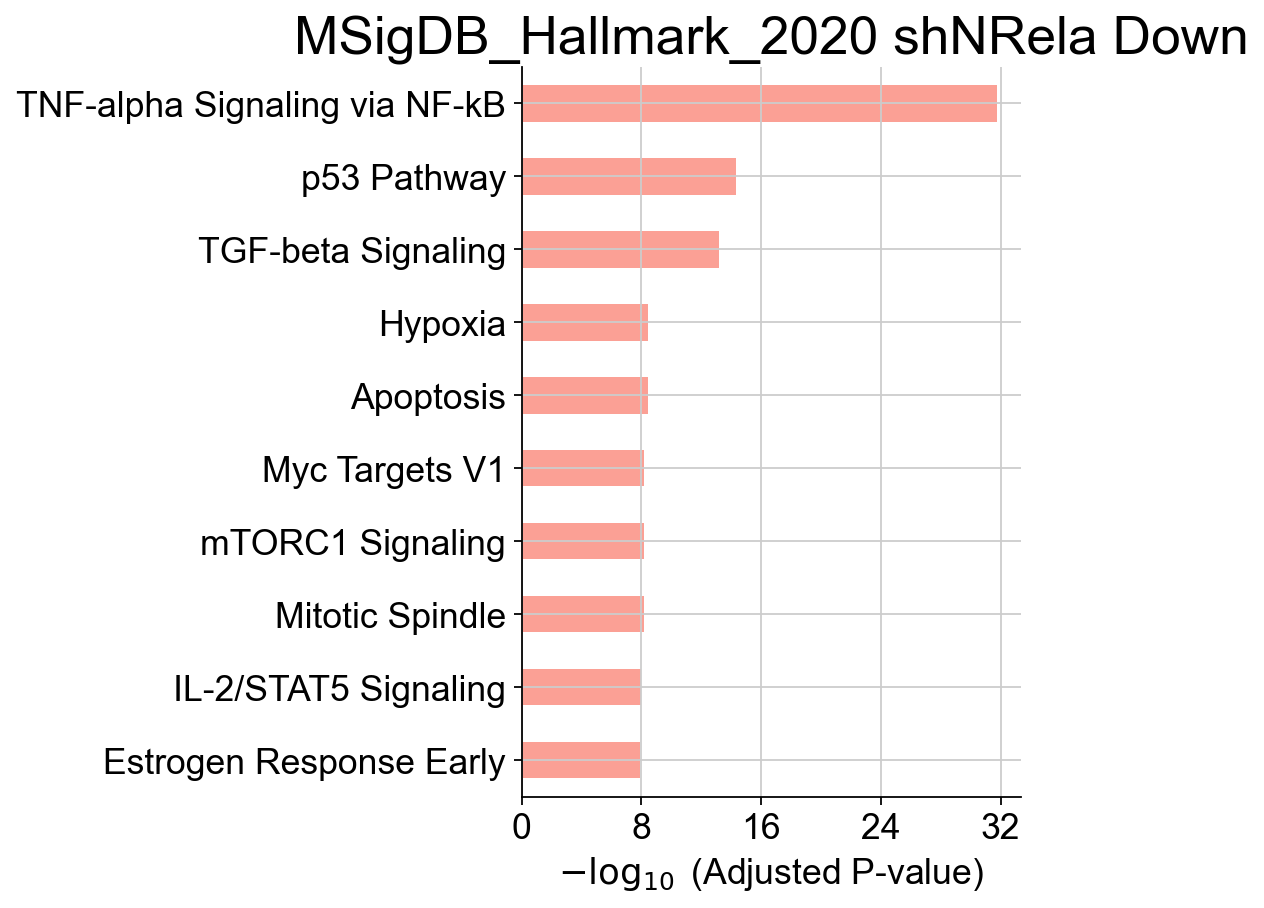

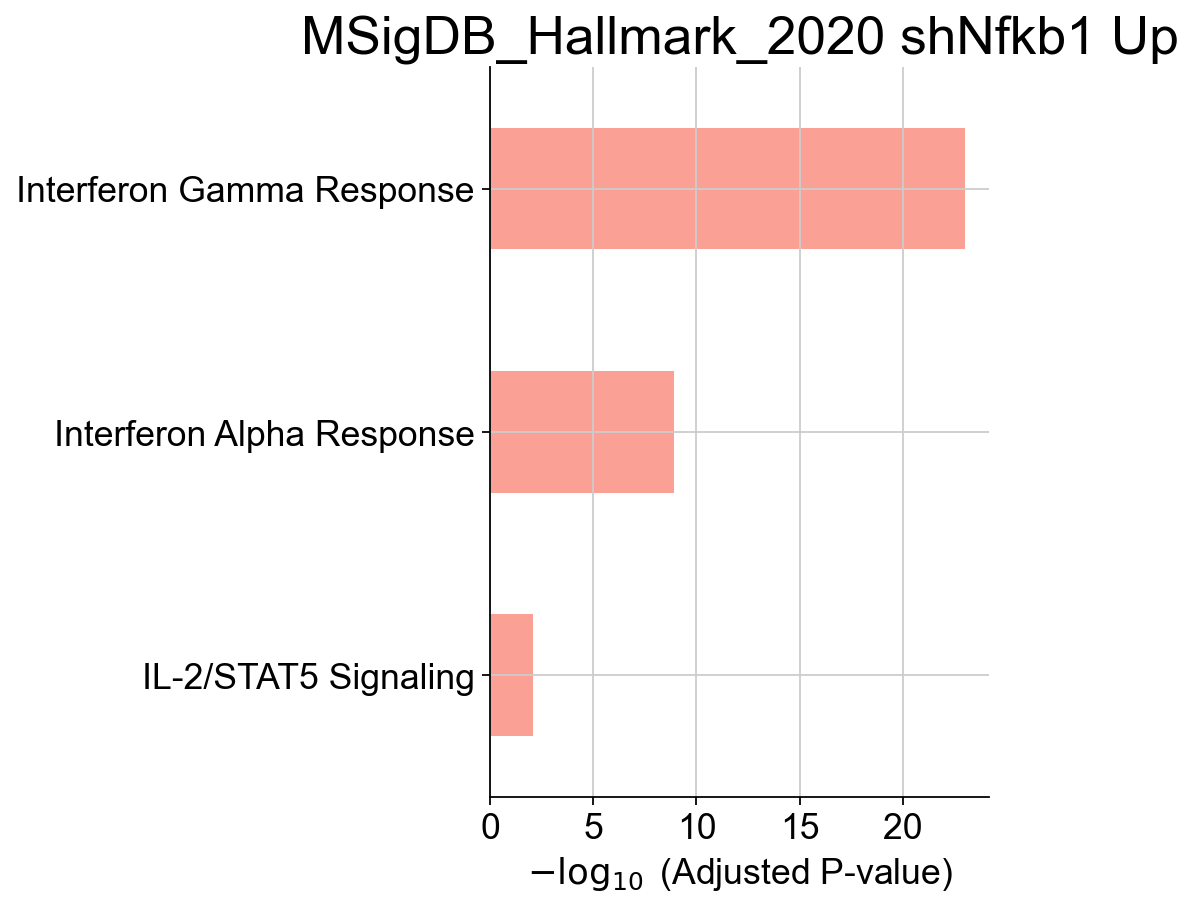

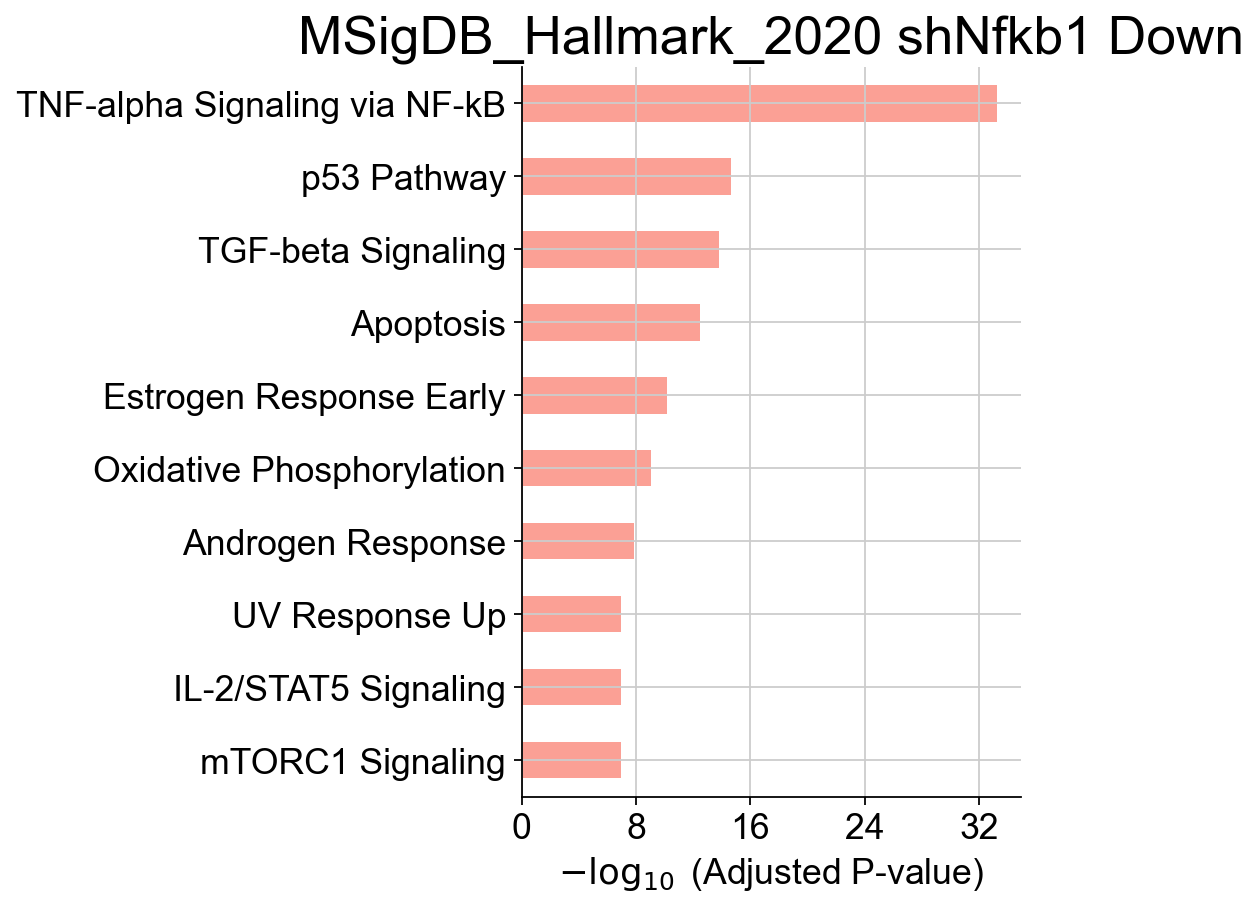

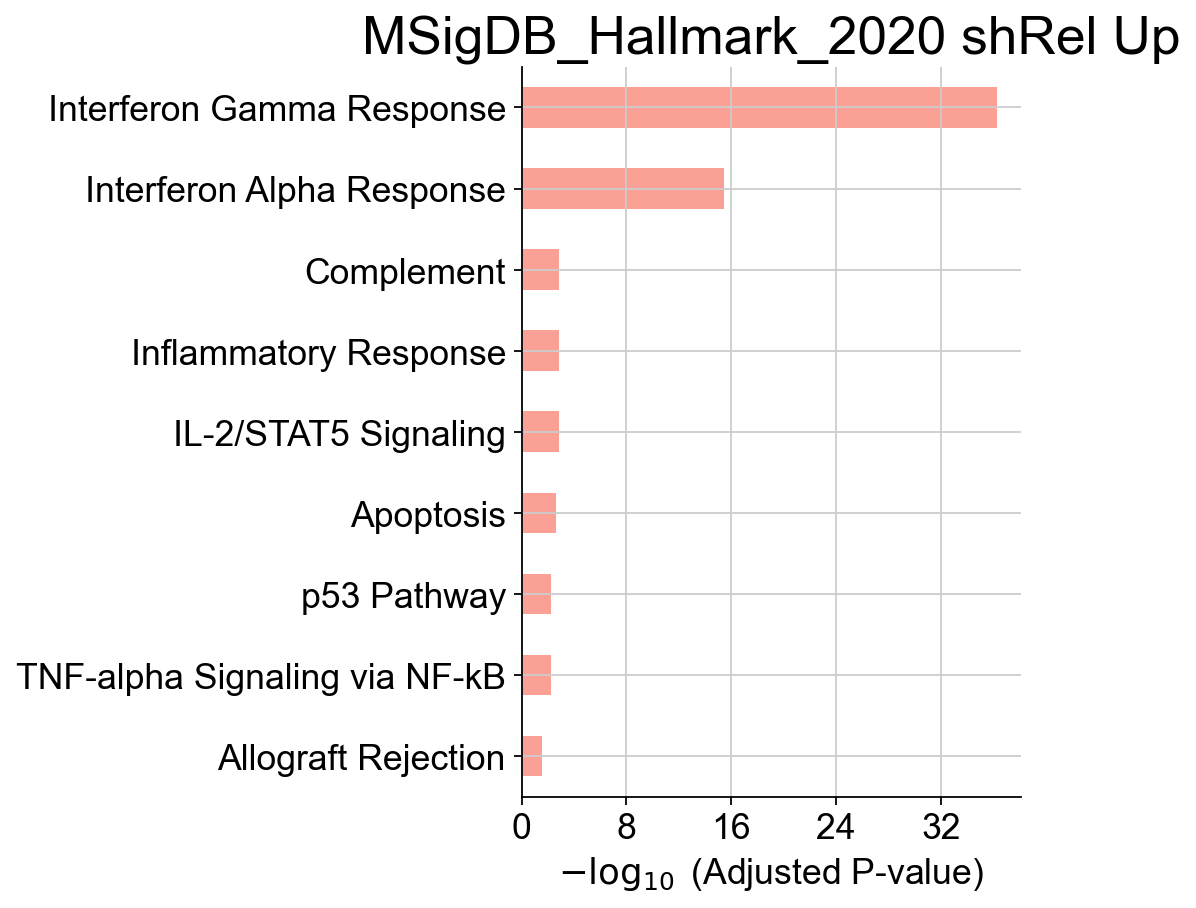

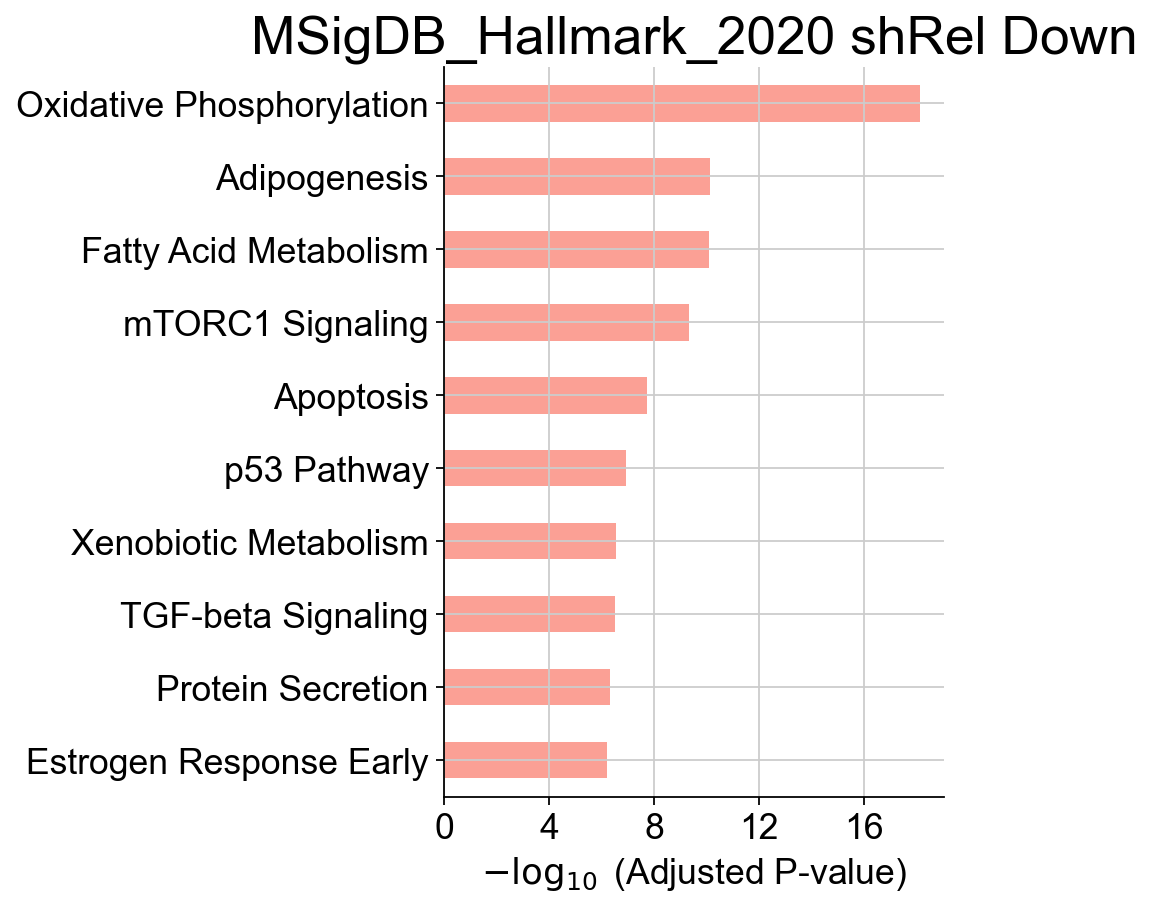

In [82]:
#gseapy.barplot(enr0.res2d,title="%s shRela Up" % gsets)
gseapy.barplot(enr1.res2d,title="%s shNRela Down" % gsets)
gseapy.barplot(enr2.res2d,title="%s shNfkb1 Up" % gsets) #nothing reaches significance
gseapy.barplot(enr3.res2d,title="%s shNfkb1 Down" % gsets)
gseapy.barplot(enr4.res2d,title="%s shRel Up" % gsets) #nothing reaches significance
gseapy.barplot(enr5.res2d,title="%s shRel Down" % gsets)

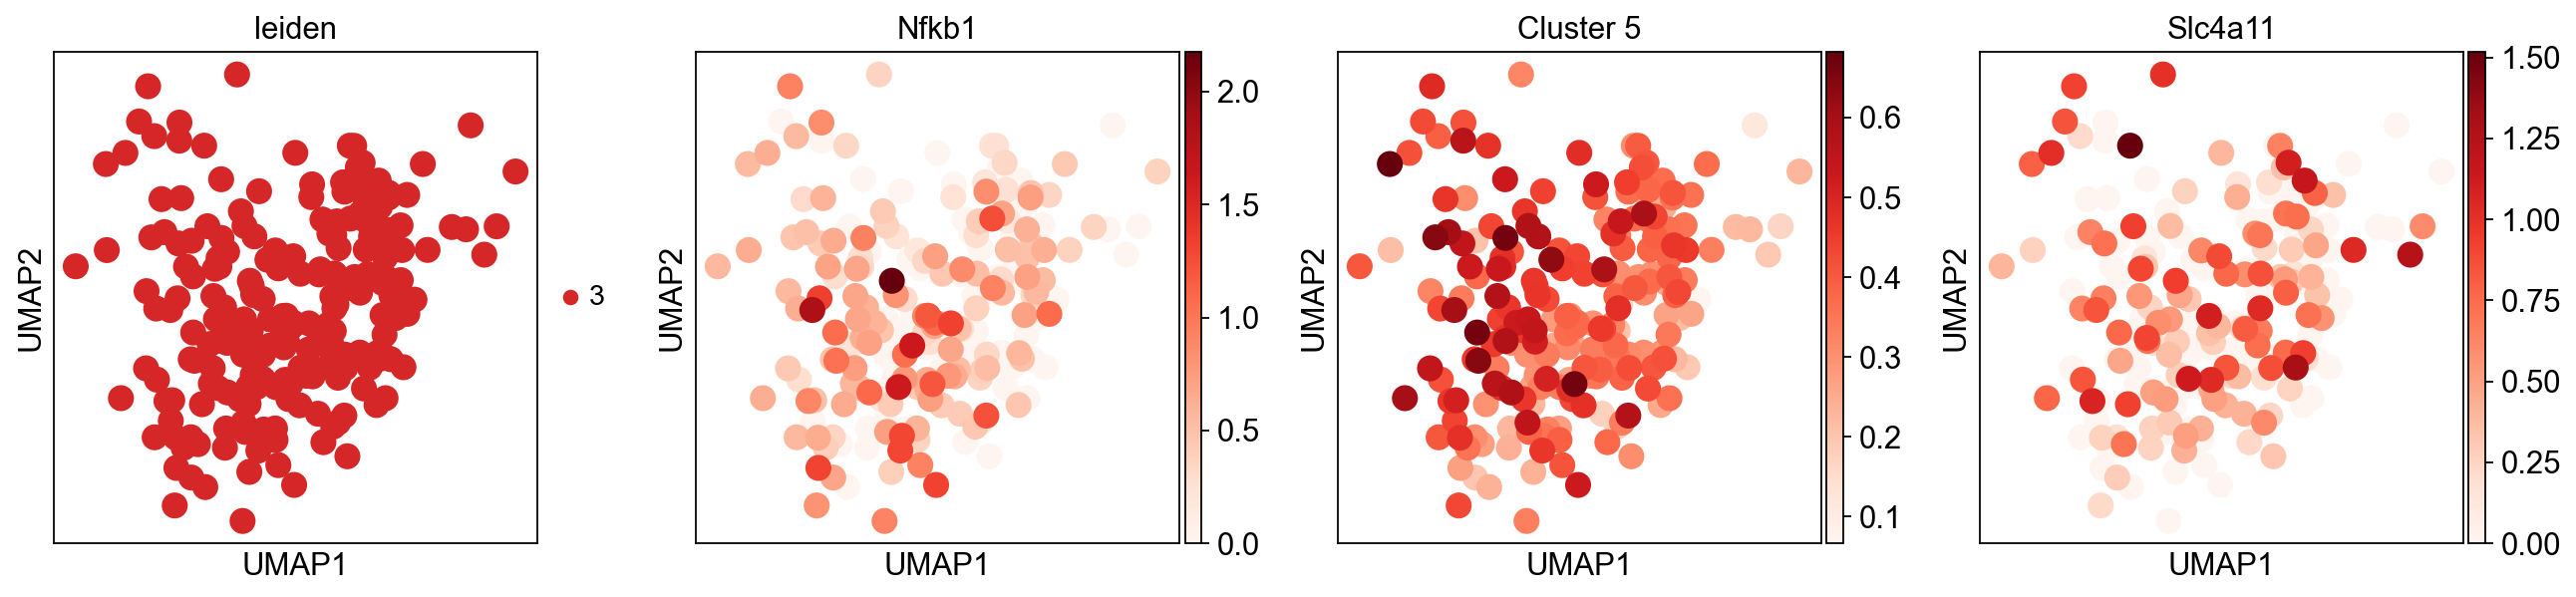

In [83]:
sc.pl.umap(adata2, color=['leiden','Nfkb1','Cluster 5','Slc4a11'], cmap='Reds')

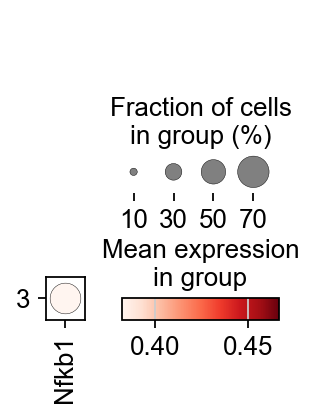

In [84]:
sc.pl.dotplot(adata2, ['Nfkb1'], groupby='leiden',use_raw=True)

In [85]:
# Test if proportion of each cell state differs between conditions
# at the MOUSE level (proper statistics)

def test_state_proportions(adata, state_key='leiden', 
                           sample_key='Classification', 
                           condition_key='Group'):
    
    # Calculate proportion of each state per mouse
    proportions = []
    
    for mouse in adata.obs[sample_key].unique():
        adata_mouse = adata[adata.obs[sample_key] == mouse]
        condition = adata_mouse.obs[condition_key].iloc[0]
        
        state_counts = adata_mouse.obs[state_key].value_counts()
        state_props = state_counts / adata_mouse.n_obs
        
        for state, prop in state_props.items():
            proportions.append({
                'mouse_id': mouse,
                'condition': condition,
                'cell_state': state,
                'proportion': prop
            })
    
    props_df = pd.DataFrame(proportions)
    
    # Test each state (Wilcoxon or t-test with n=3 per group)
    from scipy.stats import mannwhitneyu
    
    for state in props_df['cell_state'].unique():
        state_data = props_df[props_df['cell_state'] == state]
        grp1 = state_data[state_data['condition'] == 'shRenilla']['proportion']
        grp2 = state_data[state_data['condition'] == 'shRela']['proportion']
        
        stat, pval = mannwhitneyu(grp1, grp2)
        print(f"{state}: p={pval:.4f}")

In [86]:
test_state_proportions(adata)

0: p=0.5333
2: p=1.0000
1: p=0.5333
3: p=0.5333
5: p=0.6667
6: p=1.0000
4: p=nan


/tmp/ipykernel_2029983/938503693.py:36: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, pval = mannwhitneyu(grp1, grp2)


## Evaluate differences in Groups via GSEA

In [87]:
import scanpy as sc
import pandas as pd
import numpy as np
from scipy.stats import ranksums, ttest_ind
from scipy.stats import false_discovery_control


# ========================================
# CREATE NORMALIZED PSEUDOBULK
# ========================================

def create_normalized_pseudobulk(adata, 
                                 sample_key='Classification',
                                 condition_key='Group',
                                 layer=None):
    """
    Create per-cell normalized pseudobulk matrix
    
    Parameters:
    -----------
    adata : AnnData
        Annotated data object
    sample_key : str
        Column in adata.obs with mouse/sample IDs
    condition_key : str
        Column in adata.obs with condition labels
    layer : str or None
        Which layer to use. None = use .X, 'raw' = use .raw.X
    
    Returns:
    --------
    pseudobulk_df : DataFrame
        Genes x Samples with per-cell averaged expression
    metadata_df : DataFrame
        Sample metadata
    """
    
    pseudobulk_list = []
    metadata_list = []
    
    for sample in adata.obs[sample_key].unique():
        # Subset to this mouse
        adata_sample = adata[adata.obs[sample_key] == sample].copy()
        
        # Get condition
        condition = adata_sample.obs[condition_key].iloc[0]
        n_cells = adata_sample.n_obs
        
        # Get counts - use raw counts for DE
        if layer is None:
            if adata_sample.raw is not None:
                counts = adata_sample.raw.X
            else:
                counts = adata_sample.X
        else:
            counts = adata_sample.layers[layer]
        
        # Sum across cells
        if hasattr(counts, 'toarray'):  # sparse matrix
            summed = np.array(counts.sum(axis=0)).flatten()
        else:
            summed = counts.sum(axis=0).flatten()
        
        # Normalize by cell number - this is key for enriched samples!
        per_cell_avg = summed / n_cells
        
        pseudobulk_list.append(per_cell_avg)
        metadata_list.append({
            'sample_id': sample,
            'condition': condition,
            'n_cells': n_cells
        })
    
    # Create DataFrame
    if adata.raw is not None:
        gene_names = adata.raw.var_names
    else:
        gene_names = adata.var_names
    
    pseudobulk_df = pd.DataFrame(
        np.array(pseudobulk_list).T,
        index=gene_names,
        columns=[m['sample_id'] for m in metadata_list]
    )
    
    metadata_df = pd.DataFrame(metadata_list)
    
    return pseudobulk_df, metadata_df

# Create pseudobulk
print("Creating normalized pseudobulk...")
pseudobulk, metadata = create_normalized_pseudobulk(
    adata2,
    sample_key='Classification',
    condition_key='Group'
)

print(f"Pseudobulk shape: {pseudobulk.shape}")
print(f"Samples: {metadata['sample_id'].tolist()}")
print(f"Conditions: {metadata['condition'].tolist()}")

# ========================================
# DIFFERENTIAL EXPRESSION TESTING
# ========================================

def run_de_analysis(pseudobulk_df, metadata_df, 
                    condition1='shRenilla', 
                    condition2='shRela',
                    min_expression=1.0,
                    test='wilcoxon'):
    """
    Run differential expression between two conditions
    
    Parameters:
    -----------
    pseudobulk_df : DataFrame
        Genes x Samples pseudobulk matrix
    metadata_df : DataFrame
        Sample metadata with 'condition' column
    condition1 : str
        Reference condition (denominator for fold change)
    condition2 : str
        Test condition (numerator for fold change)
    min_expression : float
        Minimum mean expression to include gene
    test : str
        'wilcoxon' or 'ttest'
    
    Returns:
    --------
    results_df : DataFrame
        DE results with logFC, p-values, etc.
    """
    
    # Get sample indices for each condition
    samples1 = metadata_df[metadata_df['condition'] == condition1]['sample_id'].values
    samples2 = metadata_df[metadata_df['condition'] == condition2]['sample_id'].values
    
    print(f"\nComparing {condition2} (n={len(samples2)}) vs {condition1} (n={len(samples1)})")
    print(f"  {condition1} samples: {samples1}")
    print(f"  {condition2} samples: {samples2}")
    
    # Filter genes by expression
    mean_expr = pseudobulk_df.mean(axis=1)
    genes_to_test = mean_expr[mean_expr >= min_expression].index
    print(f"  Testing {len(genes_to_test)} genes (mean expression >= {min_expression})")
    
    results = []
    
    for gene in genes_to_test:
        group1 = pseudobulk_df.loc[gene, samples1].values
        group2 = pseudobulk_df.loc[gene, samples2].values
        
        # Calculate means and fold change
        mean1 = np.mean(group1)
        mean2 = np.mean(group2)
        
        # Log2 fold change (add pseudocount to avoid log(0))
        log2fc = np.log2((mean2 + 1) / (mean1 + 1))
        
        # Statistical test
        if test == 'wilcoxon':
            try:
                stat, pval = ranksums(group1, group2)
            except:
                pval = 1.0
        elif test == 'ttest':
            stat, pval = ttest_ind(group1, group2)
        else:
            raise ValueError("test must be 'wilcoxon' or 'ttest'")
        
        results.append({
            'gene': gene,
            'mean_control': mean1,
            'mean_treatment': mean2,
            'log2FC': log2fc,
            'pval': pval
        })
    
    results_df = pd.DataFrame(results)
    
    # FDR correction
    results_df['padj'] = false_discovery_control(results_df['pval'].values)
    
    # Sort by p-value
    results_df = results_df.sort_values('pval')
    
    print(f"  Significant genes (padj < 0.05): {(results_df['padj'] < 0.05).sum()}")
    print(f"  Upregulated (log2FC > 0.5, padj < 0.05): {((results_df['log2FC'] > 0.5) & (results_df['padj'] < 0.05)).sum()}")
    print(f"  Downregulated (log2FC < -0.5, padj < 0.05): {((results_df['log2FC'] < -0.5) & (results_df['padj'] < 0.05)).sum()}")
    
    return results_df

# Run DE analysis
de_results_Rela = run_de_analysis(
    pseudobulk, 
    metadata,
    condition1='shRenilla',  # Change to your control condition name
    condition2='shRela',    # Change to your treatment condition name
    min_expression=1.0,
    test='wilcoxon'  # or 'ttest'
)

# Save full results
de_results_Rela.to_csv('write/de_results_shRela_vs_shRenilla.csv', index=False)
print("\nSaved DE results to: de_results_shRela_vs_shRenilla.csv")

de_results_Nfkb1 = run_de_analysis(
    pseudobulk, 
    metadata,
    condition1='shRenilla',  # Change to your control condition name
    condition2='shNfkb1',    # Change to your treatment condition name
    min_expression=1.0,
    test='wilcoxon'  # or 'ttest'
)

# Save full results
de_results_Nfkb1.to_csv('write/de_results_shNfkb1_vs_shRenilla.csv', index=False)
print("\nSaved DE results to: de_results_shNfkb1_vs_shRenilla.csv")

de_results_Rel = run_de_analysis(
    pseudobulk, 
    metadata,
    condition1='shRenilla',  # Change to your control condition name
    condition2='shRel',    # Change to your treatment condition name
    min_expression=1.0,
    test='wilcoxon'  # or 'ttest'
)

# Save full results
de_results_Rel.to_csv('write/de_results_shRel_vs_shRenilla.csv', index=False)
print("\nSaved DE results to: de_results_shRel_vs_shRenilla.csv")


# ========================================
# CREATE RANKING METRIC FOR GSEA
# ========================================

def create_gsea_ranking(de_results_df, 
                       ranking_method='signed_pval'):
    """
    Create ranking metric for GSEA Prerank
    
    Parameters:
    -----------
    de_results_df : DataFrame
        DE results with gene, log2FC, pval columns
    ranking_method : str
        'signed_pval': -log10(pval) * sign(log2FC)
        'weighted_fc': log2FC * -log10(pval)
        'signal2noise': log2FC / SE (requires replicates)
    
    Returns:
    --------
    ranked_df : DataFrame
        Genes ranked for GSEA
    """
    
    df = de_results_df.copy()
    
    # Replace p=0 with minimum non-zero p-value
    min_pval = df[df['pval'] > 0]['pval'].min()
    df.loc[df['pval'] == 0, 'pval'] = min_pval / 10
    
    if ranking_method == 'signed_pval':
        # Classic approach: sign(FC) * -log10(pval)
        df['rank_metric'] = -np.log10(df['pval']) * np.sign(df['log2FC'])
        
    elif ranking_method == 'weighted_fc':
        # Weight fold change by significance
        df['rank_metric'] = df['log2FC'] * -np.log10(df['pval'])
        
    elif ranking_method == 'log2fc_only':
        # Just use fold change (not recommended for small n)
        df['rank_metric'] = df['log2FC']
    
    else:
        raise ValueError(f"Unknown ranking method: {ranking_method}")
    
    # Sort by ranking metric (high to low)
    df = df.sort_values('rank_metric', ascending=False)
    
    # Remove any NaN or infinite values
    df = df[np.isfinite(df['rank_metric'])]
    
    print(f"\nRanking method: {ranking_method}")
    print(f"Top 5 upregulated genes:")
    print(df[['gene', 'log2FC', 'pval', 'rank_metric']].head())
    print(f"\nTop 5 downregulated genes:")
    print(df[['gene', 'log2FC', 'pval', 'rank_metric']].tail())
    
    return df[['gene', 'rank_metric']]

# Create ranking
ranked_genes_Rela = create_gsea_ranking(
    de_results_Rela, 
    ranking_method='signed_pval'  # or 'weighted_fc'
)

ranked_genes_Nfkb1 = create_gsea_ranking(
    de_results_Nfkb1, 
    ranking_method='signed_pval'  # or 'weighted_fc'
)


ranked_genes_Rel = create_gsea_ranking(
    de_results_Rel, 
    ranking_method='signed_pval'  # or 'weighted_fc'
)

# ========================================
# EXPORT FOR GSEA PRERANK
# ========================================

# Save as .rnk file (tab-separated, no header)
output_file_Rela = 'write/shRela_vs_shRenilla.rnk'
ranked_genes_Rela.to_csv(
    output_file_Rela,
    sep='\t',
    header=False,
    index=False
)
print(f"\nSaved GSEA ranking file: {output_file_Rela}")
print(f"Total genes in ranking: {len(ranked_genes_Rela)}")

# Save as .rnk file (tab-separated, no header)
output_file_Nfkb1 = 'write/shNfkb1_vs_shRenilla.rnk'
ranked_genes_Nfkb1.to_csv(
    output_file_Nfkb1,
    sep='\t',
    header=False,
    index=False
)

print(f"\nSaved GSEA ranking file: {output_file_Nfkb1}")
print(f"Total genes in ranking: {len(ranked_genes_Nfkb1)}")

output_file_Rel = 'write/shRel_vs_shRenilla.rnk'
ranked_genes_Rel.to_csv(
    output_file_Rel,
    sep='\t',
    header=False,
    index=False
)
print(f"\nSaved GSEA ranking file: {output_file_Rel}")
print(f"Total genes in ranking: {len(ranked_genes_Rel)}")


# ========================================
# 6. OPTIONAL: RUN GSEA IN PYTHON
# ========================================

# If you want to run GSEA directly in Python instead of using the GSEA app:

def run_gsea_prerank_python(ranked_genes_df, 
                           gene_sets='MSigDB_Hallmark_2020',
                           organism='Mouse',
                           output_dir='write/gsea_output'):
    """
    Run GSEA Prerank using gseapy
    
    Requires: pip install gseapy
    """
    try:
        import gseapy as gp
    except ImportError:
        print("gseapy not installed. Install with: pip install gseapy")
        return None
    
    print(f"\nRunning GSEA Prerank...")
    print(f"  Gene sets: {gene_sets}")
    print(f"  Organism: {organism}")
    
    # Run GSEA
    pre_res = gp.prerank(
        rnk=ranked_genes_df,
        gene_sets=gene_sets,
        organism=organism,
        outdir=output_dir,
        min_size=15,
        max_size=500,
        permutation_num=1000,
        seed=42,
        verbose=True
    )
    
    print(f"\nGSEA complete! Results saved to: {output_dir}")
    
    # Show top results
    results = pre_res.res2d
    results = results.sort_values('NOM p-val')
    
    print("\nTop 20 enriched pathways:")
    print(results[['Term', 'ES', 'NES', 'NOM p-val', 'FDR q-val']].head(20))
    
    return pre_res

# run GSEA in Python:
gsea_results_Rela = run_gsea_prerank_python(
     ranked_genes_Rela,
     gene_sets='MSigDB_Hallmark_2020',  # or 'KEGG_2021', 'GO_Biological_Process_2021', etc.
     organism='Mouse',
     output_dir='write/gsea_shRela_vs_shRenilla'
 )

gsea_results_Nfkb1 = run_gsea_prerank_python(
     ranked_genes_Nfkb1,
     gene_sets='MSigDB_Hallmark_2020',  # or 'KEGG_2021', 'GO_Biological_Process_2021', etc.
     organism='Mouse',
     output_dir='write/gsea_shNfkb1_vs_shRenilla'
 )

gsea_results_Rel = run_gsea_prerank_python(
     ranked_genes_Rel,
     gene_sets='MSigDB_Hallmark_2020',  # or 'KEGG_2021', 'GO_Biological_Process_2021', etc.
     organism='Mouse',
     output_dir='write/gsea_shRel_vs_shRenilla'
 )

print("\n" + "="*60)
print("COMPLETE! Next steps:")
print("="*60)
print("1. Check de_results_hairpin1_vs_shRenilla.csv for DE genes")
print("2. Use hairpin1_vs_shRenilla.rnk in GSEA Prerank desktop app")
print("   - Load .rnk file")
print("   - Choose gene sets (e.g., MSigDB Hallmark for mouse)")
print("   - Run with default parameters")
print("3. Or uncomment the Python GSEA code above to run in Python")
print("="*60)

# ========================================
# 7. OPTIONAL: STATE-SPECIFIC ANALYSIS
# ========================================

def run_state_specific_analysis(adata, 
                                state_key='cell_state',
                                states_to_analyze=None):
    """
    Run separate pseudobulk analysis for each cell state
    """
    
    if states_to_analyze is None:
        states_to_analyze = adata.obs[state_key].unique()
    
    all_results = {}
    
    for state in states_to_analyze:
        print(f"\n{'='*60}")
        print(f"Analyzing state: {state}")
        print(f"{'='*60}")
        
        # Subset to this state
        adata_state = adata[adata.obs[state_key] == state].copy()
        
        # Check we have enough cells per mouse
        cells_per_mouse = adata_state.obs.groupby(['Classification', 'Group']).size()
        print(f"Cells per mouse:\n{cells_per_mouse}")
        
        if cells_per_mouse.min() < 10:
            print(f"WARNING: Some mice have <10 cells in {state} state. Results may be unreliable.")
        
        # Create pseudobulk
        pb, meta = create_normalized_pseudobulk(
            adata_state,
            sample_key='Classification',
            condition_key='Group'
        )
        
        # Run DE
        de = run_de_analysis(
            pb, meta,
            condition1='shRenilla',
            condition2='shRela',
            min_expression=0.5  # Lower threshold for state-specific
        )
        
        # Create ranking
        ranked = create_gsea_ranking(de, ranking_method='signed_pval')
        
        # Save
        state_name = state.replace(' ', '_').replace('/', '_')
        ranked.to_csv(f'{state_name}_hairpin1_vs_shRenilla.rnk', 
                     sep='\t', header=False, index=False)
        de.to_csv(f'de_results_{state_name}_hairpin1_vs_shRenilla.csv', index=False)
        
        all_results[state] = {
            'de_results': de,
            'ranked_genes': ranked
        }
        
        print(f"Saved: {state_name}_hairpin1_vs_shRenilla.rnk")
    
    return all_results

# Uncomment if you want state-specific analysis:
# state_results = run_state_specific_analysis(
#     adata,
#     state_key='cell_state',  # or 'leiden', 'cell_type', etc.
#     states_to_analyze=['State1', 'State2', 'State3']  # or None for all
# )

Creating normalized pseudobulk...
Pseudobulk shape: (30144, 12)
Samples: ['BF1087_B0313', 'BF1240_(BE1834)_B0312', 'BE1491-NT_B0310', 'BE1157_(BD1674)_B0305', 'BE1490_B0309', 'BE1139_B0307', 'BE1140-NT_B0308', 'BE1155_(BD1672)_B0302', 'BE1662_B0311', 'BD1941_B0306', 'BD1939_B0303', 'BE1156_(BD1671)_B0301']
Conditions: ['shRenilla', 'shRenilla', 'shRel', 'shRela', 'shRel', 'shRela', 'shRela', 'shNfkb1', 'shRel', 'shRela', 'shNfkb1', 'shNfkb1']

Comparing shRela (n=4) vs shRenilla (n=2)
  shRenilla samples: ['BF1087_B0313' 'BF1240_(BE1834)_B0312']
  shRela samples: ['BE1157_(BD1674)_B0305' 'BE1139_B0307' 'BE1140-NT_B0308' 'BD1941_B0306']
  Testing 668 genes (mean expression >= 1.0)
  Significant genes (padj < 0.05): 0
  Upregulated (log2FC > 0.5, padj < 0.05): 0
  Downregulated (log2FC < -0.5, padj < 0.05): 0

Saved DE results to: de_results_shRela_vs_shRenilla.csv

Comparing shNfkb1 (n=3) vs shRenilla (n=2)
  shRenilla samples: ['BF1087_B0313' 'BF1240_(BE1834)_B0312']
  shNfkb1 samples:

2026-01-30 17:09:03,322 [WARNING] Duplicated values found in preranked stats: 98.65% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-01-30 17:09:03,322 [INFO] Parsing data files for GSEA.............................
2026-01-30 17:09:03,324 [INFO] Enrichr library gene sets already downloaded in: /home/chanj2/.cache/gseapy, use local file
2026-01-30 17:09:03,329 [INFO] 0034 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-30 17:09:03,329 [INFO] 0016 gene_sets used for further statistical testing.....
2026-01-30 17:09:03,329 [INFO] Start to run GSEA...Might take a while..................
2026-01-30 17:09:03,331 [INFO] Genes are converted to uppercase.


  Significant genes (padj < 0.05): 0
  Upregulated (log2FC > 0.5, padj < 0.05): 0
  Downregulated (log2FC < -0.5, padj < 0.05): 0

Saved DE results to: de_results_shRel_vs_shRenilla.csv

Ranking method: signed_pval
Top 5 upregulated genes:
          gene    log2FC      pval  rank_metric
162       Eea1  0.275872  0.064078     1.193294
323        Mt2  0.501343  0.064078     1.193294
151     Dnajb6  0.109089  0.064078     1.193294
158    Dync1i2  0.168386  0.064078     1.193294
544  Serpinb6a  0.350439  0.064078     1.193294

Top 5 downregulated genes:
        gene    log2FC      pval  rank_metric
651    Ywhaq -0.243732  0.064078    -1.193294
658  Zfp36l1 -0.369023  0.064078    -1.193294
660   mt-Co1 -0.150232  0.064078    -1.193294
662   mt-Nd1 -0.142027  0.064078    -1.193294
663   mt-Nd2 -0.193787  0.064078    -1.193294

Ranking method: signed_pval
Top 5 upregulated genes:
       gene    log2FC      pval  rank_metric
412   Rab14  0.167873  0.083265      1.07954
73   Capns1  0.123591  0

2026-01-30 17:09:04,182 [INFO] Congratulations. GSEApy runs successfully................

2026-01-30 17:09:04,187 [WARNING] Duplicated values found in preranked stats: 98.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-01-30 17:09:04,187 [INFO] Parsing data files for GSEA.............................
2026-01-30 17:09:04,188 [INFO] Enrichr library gene sets already downloaded in: /home/chanj2/.cache/gseapy, use local file
2026-01-30 17:09:04,194 [INFO] 0034 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-30 17:09:04,194 [INFO] 0016 gene_sets used for further statistical testing.....
2026-01-30 17:09:04,195 [INFO] Start to run GSEA...Might take a while..................
2026-01-30 17:09:04,195 [INFO] Genes are converted to uppercase.



GSEA complete! Results saved to: write/gsea_shRela_vs_shRenilla

Top 20 enriched pathways:
                                 Term        ES       NES NOM p-val FDR q-val
0           Oxidative Phosphorylation -0.674115 -1.811451       0.0  0.000673
1                      Myc Targets V1  -0.52973 -1.537819  0.001012  0.041706
3                   Androgen Response -0.575131 -1.377194  0.060606   0.17086
2                             Hypoxia  0.327044  1.384118   0.06383  0.380952
4                     Mitotic Spindle  0.406412  1.332704  0.114754  0.283069
5                IL-2/STAT5 Signaling  0.330643  1.097453  0.294118  0.539683
6                          Complement  0.287037   1.05767  0.309524  0.486772
7                      UV Response Up -0.405936 -1.036946  0.454839       1.0
8       TNF-alpha Signaling via NF-kB  0.226984  0.999121       0.5  0.531217
9                    mTORC1 Signaling -0.327318 -0.892345  0.665615       1.0
10                    Apical Junction  0.236104  0

2026-01-30 17:09:04,794 [INFO] Congratulations. GSEApy runs successfully................

2026-01-30 17:09:04,797 [WARNING] Duplicated values found in preranked stats: 98.95% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2026-01-30 17:09:04,798 [INFO] Parsing data files for GSEA.............................
2026-01-30 17:09:04,800 [INFO] Enrichr library gene sets already downloaded in: /home/chanj2/.cache/gseapy, use local file
2026-01-30 17:09:04,805 [INFO] 0034 gene_sets have been filtered out when max_size=500 and min_size=15
2026-01-30 17:09:04,805 [INFO] 0016 gene_sets used for further statistical testing.....
2026-01-30 17:09:04,805 [INFO] Start to run GSEA...Might take a while..................
2026-01-30 17:09:04,806 [INFO] Genes are converted to uppercase.



GSEA complete! Results saved to: write/gsea_shNfkb1_vs_shRenilla

Top 20 enriched pathways:
                                 Term        ES       NES NOM p-val FDR q-val
0                           Apoptosis -0.652155 -1.652344   0.00358  0.055465
2           Oxidative Phosphorylation -0.574856 -1.479772   0.01954  0.129049
1                          Complement -0.624177 -1.521531  0.021713  0.130343
3                      UV Response Up -0.565596 -1.375653   0.10122  0.262073
4                    mTORC1 Signaling -0.481342 -1.279876  0.117845  0.404896
5                     Apical Junction -0.505546 -1.241768   0.17734  0.424124
7                      Myc Targets V1 -0.405202 -1.162974  0.202128  0.483656
6                     Mitotic Spindle -0.530049 -1.205194   0.22796  0.443087
8                   Androgen Response -0.479441 -1.094104  0.352941  0.587808
9                         p53 Pathway -0.381951 -1.021112  0.453409  0.683553
10                            Hypoxia -0.374641 -

2026-01-30 17:09:06,617 [INFO] Congratulations. GSEApy runs successfully................




GSEA complete! Results saved to: write/gsea_shRel_vs_shRenilla

Top 20 enriched pathways:
                                 Term        ES       NES NOM p-val FDR q-val
0                             Hypoxia  0.490747  1.860375       0.0  0.008143
1       TNF-alpha Signaling via NF-kB  0.444161  1.846967       0.0  0.004072
2   Epithelial Mesenchymal Transition    0.4939    1.7394       0.0  0.006786
5                      Myc Targets V1 -0.542676 -1.558241  0.001015  0.030903
4                    mTORC1 Signaling -0.584448 -1.564416  0.002103  0.058828
3                IL-2/STAT5 Signaling  0.478846  1.588923  0.008475  0.015269
7           Oxidative Phosphorylation -0.518803 -1.379754  0.044351  0.134596
6            PI3K/AKT/mTOR  Signaling -0.567774 -1.386515  0.051685  0.167795
8                          Complement -0.551853 -1.360351  0.059016  0.128825
9                      UV Response Up -0.479316  -1.18848   0.22782  0.386971
10          Unfolded Protein Response -0.442485 -1.

## Decoupler Test

In [88]:
import decoupler as dc

In [89]:
pdata = adata.copy()

In [90]:
del pdata.uns['log1p']

In [91]:
pdata.X = pdata.layers['counts'].copy()

In [92]:
pdata = dc.pp.pseudobulk(
    adata=pdata,
    sample_col="Classification",
    groups_col="leiden",
    #groups_col=None,
    mode="sum",
)

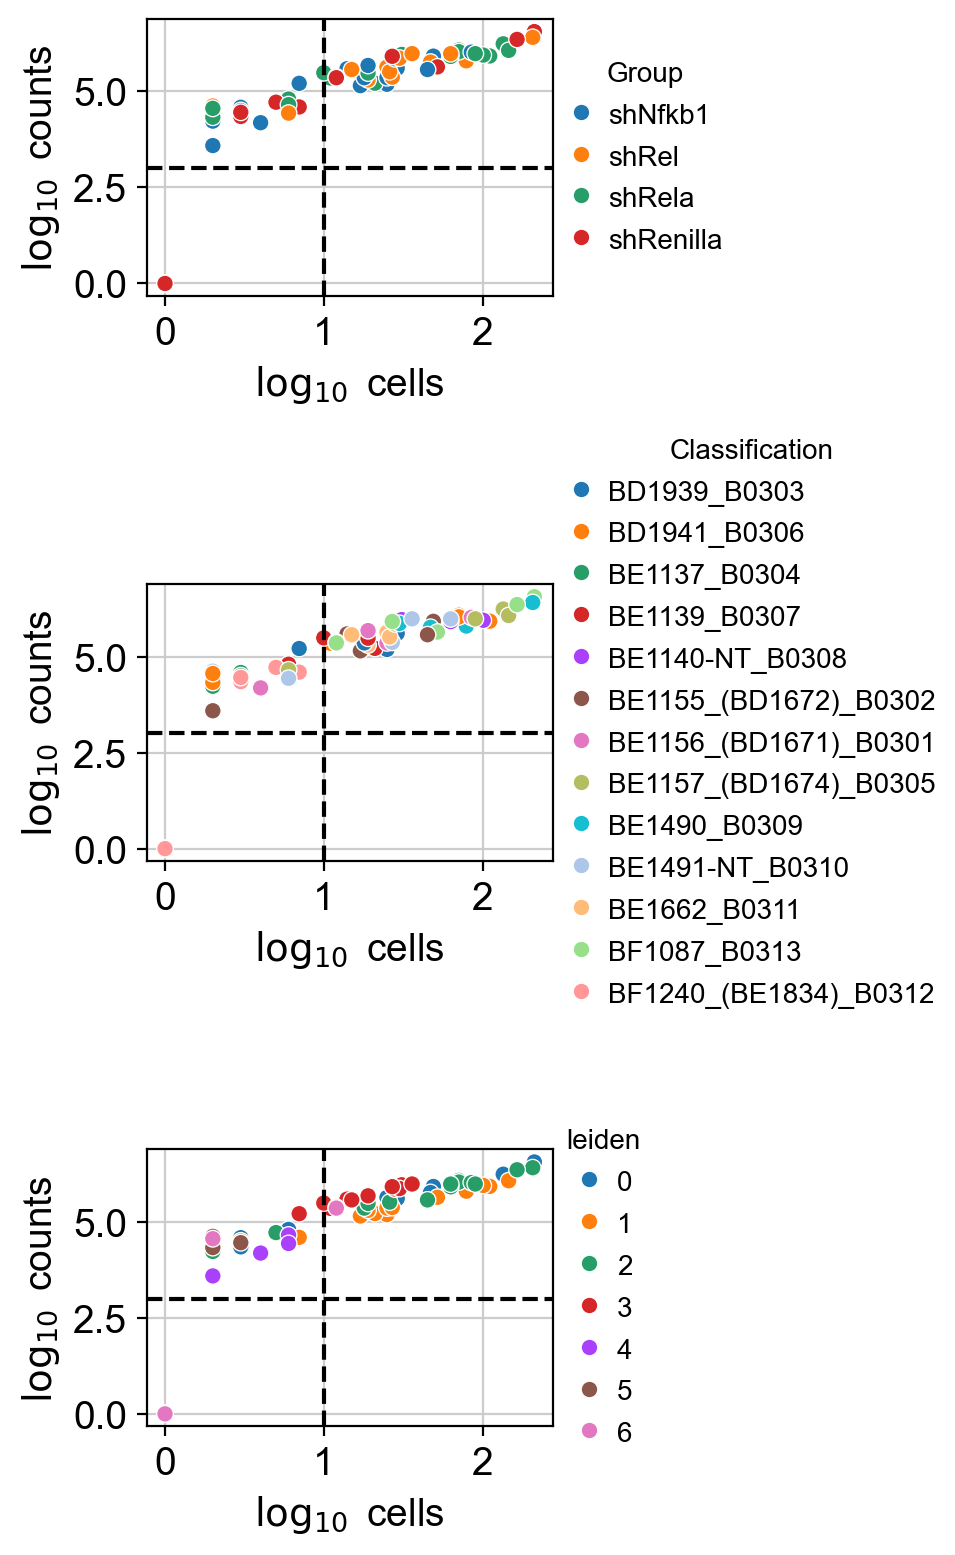

In [93]:
dc.pl.filter_samples(
    adata=pdata,
    groupby=["Group", "Classification",'leiden'], 
    min_cells=10,
    min_counts=1000,
    figsize=(5, 8),
)

In [94]:
dc.pp.filter_samples(pdata, min_cells=10, min_counts=1000)

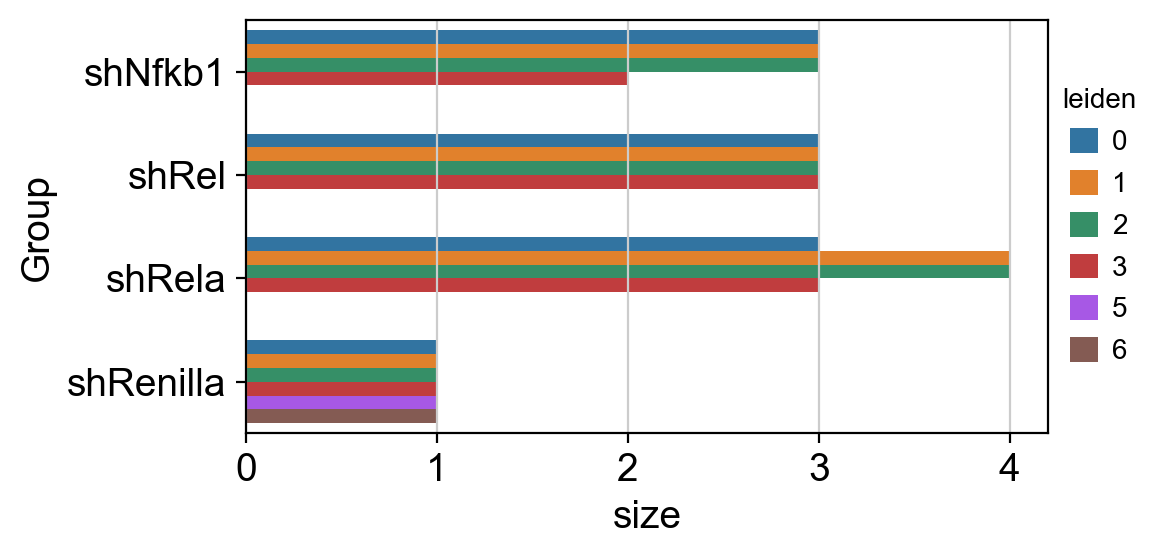

In [95]:
dc.pl.obsbar(adata=pdata, y="Group", hue="leiden", figsize=(6, 3)) 

In [96]:
# Store raw counts in layers
pdata.layers["counts"] = pdata.X.copy()

pdatabak = pdata.copy()
del pdata.obs['2117-Nfkb1']

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.pp.swap_layer(adata=pdata, key="counts", inplace=True)

normalizing counts per cell
    finished (0:00:00)
computing PCA
    with n_comps=42
    finished (0:00:00)


In [97]:
import numpy as np
import pandas as pd

print("obsm keys:", list(pdata.obsm.keys()))
print("X_pca shape:", None if "X_pca" not in pdata.obsm else pdata.obsm["X_pca"].shape)

print("\nobs columns:", pdata.obs.columns.tolist())
print("\nobs head:\n", pdata.obs.head())

# how many rows?
print("\nndata:", pdata.n_obs)

# Find candidate grouping columns: non-null and >1 unique value
candidates = []
for c in pdata.obs.columns:
    s = pdata.obs[c]
    nunq = s.dropna().nunique()
    if nunq >= 2:
        candidates.append((c, nunq, str(s.dtype)))
print("\nGrouping candidates (>=2 unique non-NA):")
print(pd.DataFrame(candidates, columns=["col","n_unique","dtype"]).sort_values("n_unique", ascending=False))


obsm keys: ['X_pca']
X_pca shape: (43, 42)

obs columns: ['Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts']

obs head:
                                 Classification leiden    Group       batch  \
BD1939_B0303_0                    BD1939_B0303      0  shNfkb1  shHairpins   
BD1941_B0306_0                    BD1941_B0306      0   shRela  shHairpins   
BE1140-NT_B0308_0              BE1140-NT_B0308      0   shRela  shHairpins   
BE1155_(BD1672)_B0302_0  BE1155_(BD1672)_B0302      0  shNfkb1  shHairpins   
BE1156_(BD1671)_B0301_0  BE1156_(BD1671)_B0301      0  shNfkb1  shHairpins   

                        condition  psbulk_cells  psbulk_counts  
BD1939_B0303_0            perturb          28.0       400452.0  
BD1941_B0306_0            perturb          70.0      1190145.0  
BE1140-NT_B0308_0         perturb          17.0       255087.0  
BE1155_(BD1672)_B0302_0   perturb          48.0       825745.0  
BE1156_(BD1671)_B0301_0   perturb          6

In [98]:
dc.tl.rankby_obsm(pdata, key="X_pca",obs_keys=['Group'])

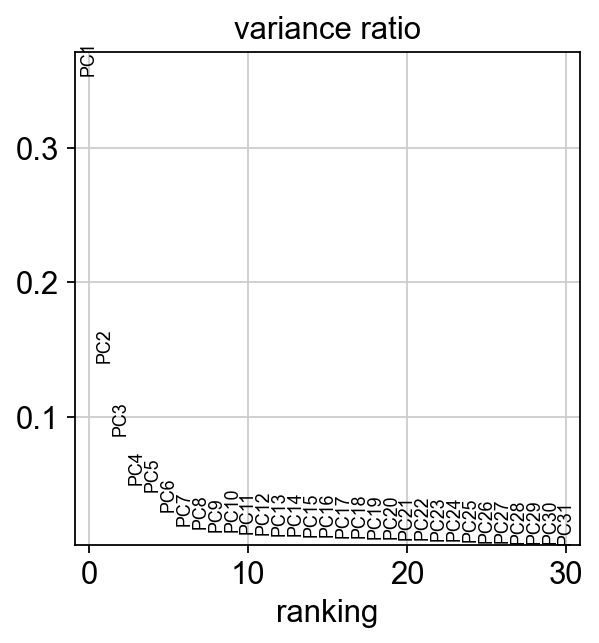

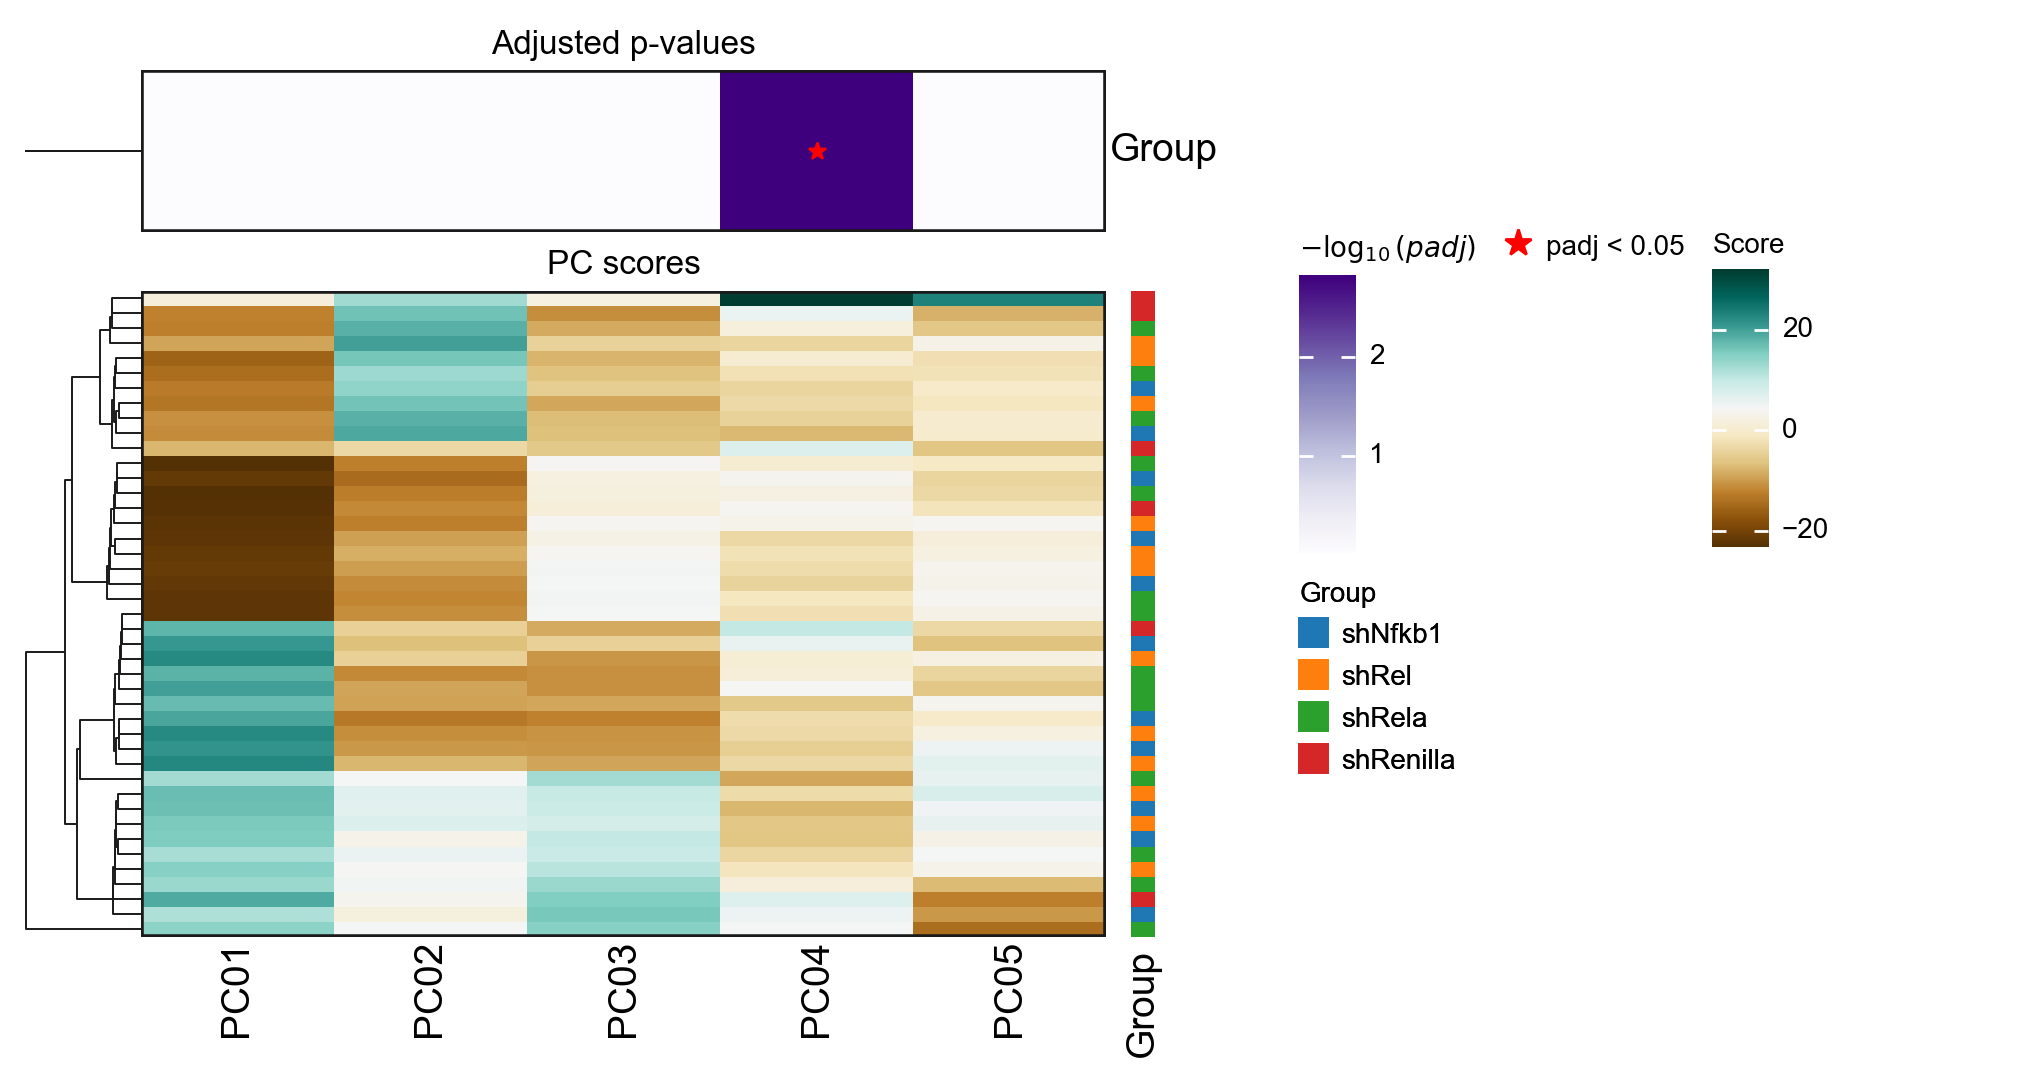

In [99]:
sc.pl.pca_variance_ratio(pdata)
dc.pl.obsm(adata=pdata, return_fig=True, nvar=5, titles=["PC scores", "Adjusted p-values"], figsize=(10, 5))

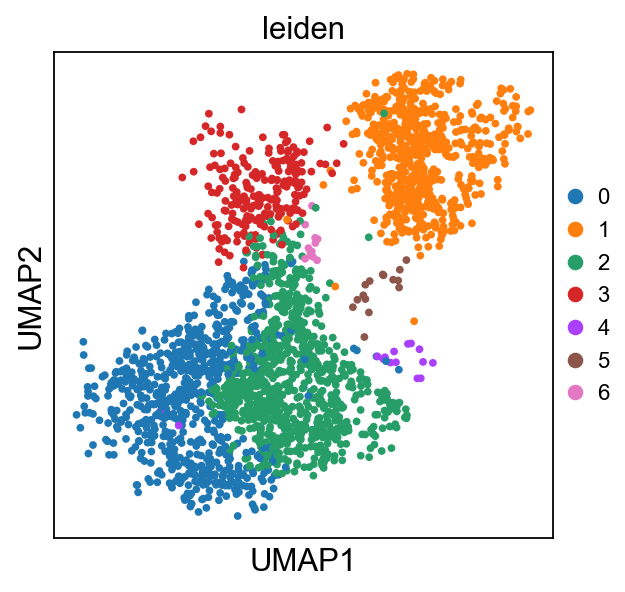

In [100]:
sc.pl.umap(adata, color='leiden')

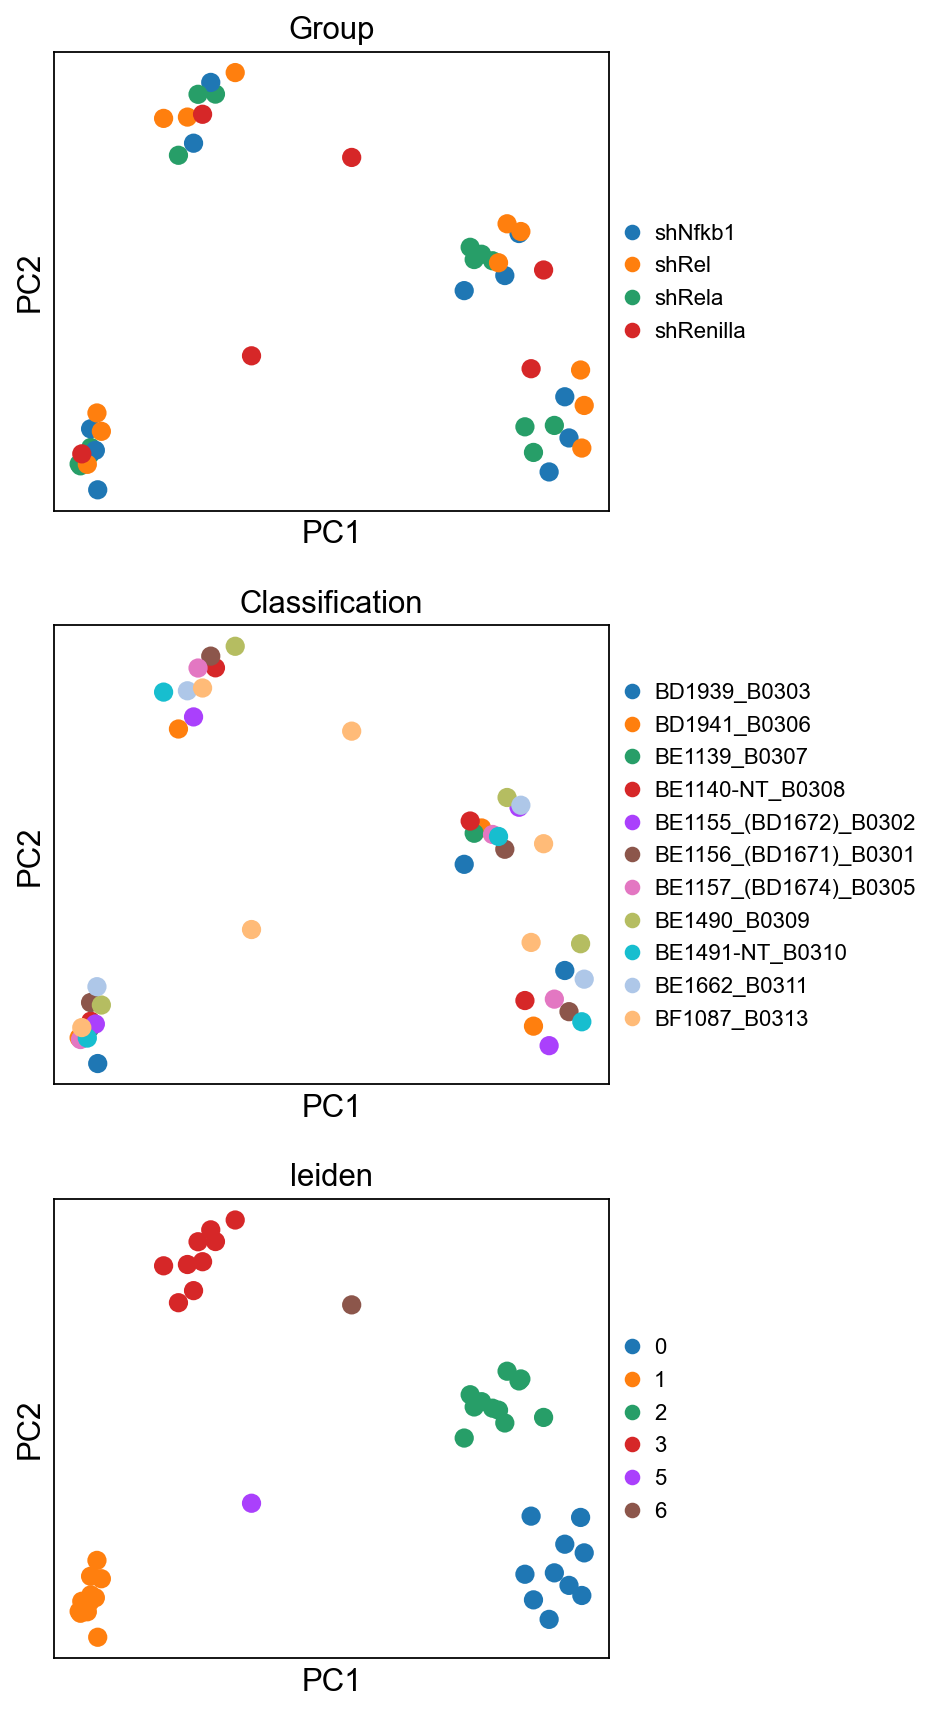

In [101]:
sc.pl.pca(
    pdata,
    color=["Group", "Classification",'leiden'], 
    ncols=1,
    size=300,
    frameon=True,
)

In [102]:
# select relevant samples
#hpcscells = pdata[pdata.obs["leiden"] == "3"].copy()
hpcscells = pdata.copy()
hpcscells

AnnData object with n_obs × n_vars = 43 × 30144
    obs: 'Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids-IkbSR-Cre', 'feature_types-IkbSR-Cre', 'genome-IkbSR-Cre', 'pattern-IkbSR-Cre', 'read-IkbSR-Cre', 'sequence-IkbSR-Cre', 'n_cells-IkbSR-Cre', 'mt-IkbSR-Cre', 'n_cells_by_counts-IkbSR-Cre', 'mean_counts-IkbSR-Cre', 'pct_dropout_by_counts-IkbSR-Cre', 'total_counts-IkbSR-Cre', 'highly_variable-IkbSR-Cre', 'means-IkbSR-Cre', 'dispersions-IkbSR-Cre', 'dispersions_norm-IkbSR-Cre', 'gene_ids-shHairpins', 'feature_types-shHairpins', 'genome-shHairpins', 'pattern-shHairpins', 'read-shHairpins', 'sequence-shHairpins', 'n_cells-shHairpins', 'mt-shHairpins', 'n_cells_by_counts-shHairpins', 'mean_counts-shHairpins', 'pct_dropout_by_counts-shHairpins', 'total_counts-shHairpins', 'highly_variable-shHairpins', 'means-shHairpins', 'dispersions-shHairpins', 'dispersions_norm-shHairpins', 'gene_ids-shNfkb1_lane1', 'feature_types-shNfkb1_lane

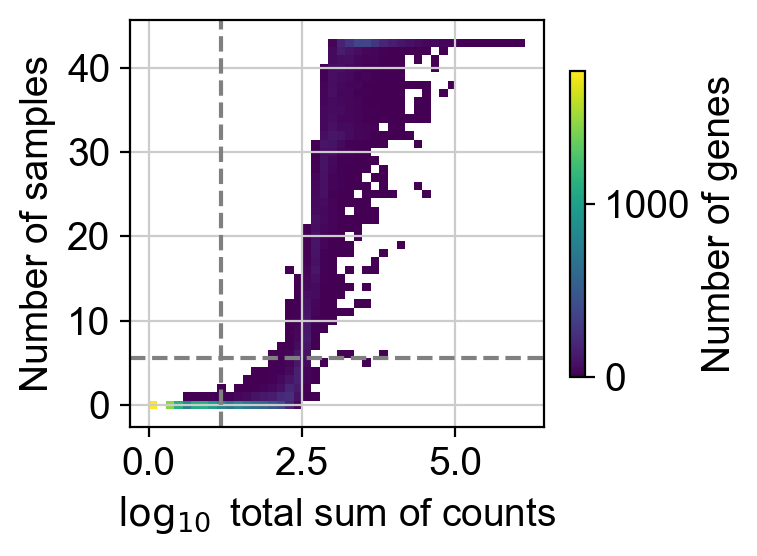

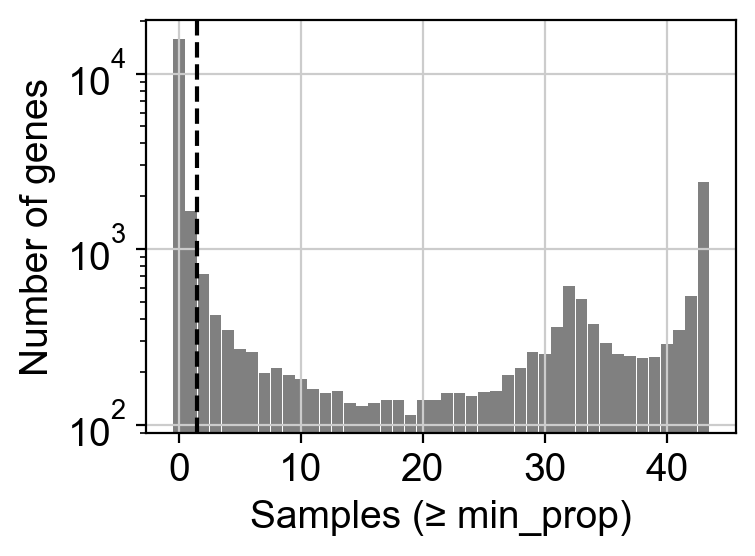

In [103]:
dc.pl.filter_by_expr(
    adata=hpcscells,
    group="Group",
    min_count=10, #10 / 5
    min_total_count=15, #15 / 100
    large_n=20,
    min_prop=0.1,
)
dc.pl.filter_by_prop(
    adata=hpcscells,
    min_prop=0.1,
    min_smpls=2, #7
)

In [104]:
dc.pp.filter_by_expr(
    adata=hpcscells,
    group="Group",
    min_count=5,
    min_total_count=100,
    large_n=20,
    min_prop=0.1,
)
dc.pp.filter_by_prop(
    adata=hpcscells,
    min_prop=0.1,
    min_smpls=7,
)
hpcscells

AnnData object with n_obs × n_vars = 43 × 10364
    obs: 'Classification', 'leiden', 'Group', 'batch', 'condition', 'psbulk_cells', 'psbulk_counts'
    var: 'gene_ids-IkbSR-Cre', 'feature_types-IkbSR-Cre', 'genome-IkbSR-Cre', 'pattern-IkbSR-Cre', 'read-IkbSR-Cre', 'sequence-IkbSR-Cre', 'n_cells-IkbSR-Cre', 'mt-IkbSR-Cre', 'n_cells_by_counts-IkbSR-Cre', 'mean_counts-IkbSR-Cre', 'pct_dropout_by_counts-IkbSR-Cre', 'total_counts-IkbSR-Cre', 'highly_variable-IkbSR-Cre', 'means-IkbSR-Cre', 'dispersions-IkbSR-Cre', 'dispersions_norm-IkbSR-Cre', 'gene_ids-shHairpins', 'feature_types-shHairpins', 'genome-shHairpins', 'pattern-shHairpins', 'read-shHairpins', 'sequence-shHairpins', 'n_cells-shHairpins', 'mt-shHairpins', 'n_cells_by_counts-shHairpins', 'mean_counts-shHairpins', 'pct_dropout_by_counts-shHairpins', 'total_counts-shHairpins', 'highly_variable-shHairpins', 'means-shHairpins', 'dispersions-shHairpins', 'dispersions_norm-shHairpins', 'gene_ids-shNfkb1_lane1', 'feature_types-shNfkb1_lane

In [105]:
hpcscells.obs["Group"] = (
    hpcscells.obs["Group"]
    .astype("category")
    .cat.reorder_categories(
        ["shRenilla", "shRela", "shNfkb1", 'shRel'],
        ordered=True
    )
)


In [106]:
# Import DESeq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats

# Build DESeq2 object
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    adata=hpcscells,
    design_factors=["Group"],
    refit_cooks=True,
    inference=inference,
)

# Compute LFCs
dds.deseq2()

# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["Group", "shRela", "shRenilla"], inference=inference)

# Compute Wald test
stat_res.summary()

Using None as control genes, passed at DeseqDataSet initialization


/tmp/ipykernel_2029983/3659832135.py:7: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.22 seconds.

Fitting dispersion trend curve...
... done in 0.16 seconds.

Fitting MAP dispersions...
... done in 5.09 seconds.

Fitting LFCs...
... done in 2.96 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 11 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Group shRela vs shRenilla
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Retreg1   45.264179        0.307558  0.264260  1.163848  0.244486  0.999971
Nploc4    13.721854        0.315494  0.230867  1.366559  0.171764  0.999971
Mrpl46    17.073348        0.058577  0.319894  0.183113  0.854710  0.999971
Yap1      25.548771       -0.183448  0.299260 -0.613004  0.539874  0.999971
Slc22a17   1.528355        0.479013  1.021804  0.468792  0.639219  0.999971
...             ...             ...       ...       ...       ...       ...
Stard4     4.785833       -1.790262  0.595780 -3.004902  0.002657  0.429964
AU021092  27.073545       -0.413219  0.906433 -0.455873  0.648481  0.999971
Kdm2b      7.329514       -0.271501  0.485273 -0.559480  0.575834  0.999971
Plxna4    26.733901        0.045452  0.593692  0.076557  0.938976  0.999971
Riox2      8.849333        0.285433  0.268464  1.063208  0.287688  0.999971

[10364 rows x 6 columns

... done in 1.06 seconds.



In [107]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Retreg1   45.264179        0.307558  0.264260  1.163848  0.244486  0.999971
Nploc4    13.721854        0.315494  0.230867  1.366559  0.171764  0.999971
Mrpl46    17.073348        0.058577  0.319894  0.183113  0.854710  0.999971
Yap1      25.548771       -0.183448  0.299260 -0.613004  0.539874  0.999971
Slc22a17   1.528355        0.479013  1.021804  0.468792  0.639219  0.999971
...             ...             ...       ...       ...       ...       ...
Stard4     4.785833       -1.790262  0.595780 -3.004902  0.002657  0.429964
AU021092  27.073545       -0.413219  0.906433 -0.455873  0.648481  0.999971
Kdm2b      7.329514       -0.271501  0.485273 -0.559480  0.575834  0.999971
Plxna4    26.733901        0.045452  0.593692  0.076557  0.938976  0.999971
Riox2      8.849333        0.285433  0.268464  1.063208  0.287688  0.999971

[10364 rows x 6 columns]

2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:33 | [WARNING] Some labels are too lo

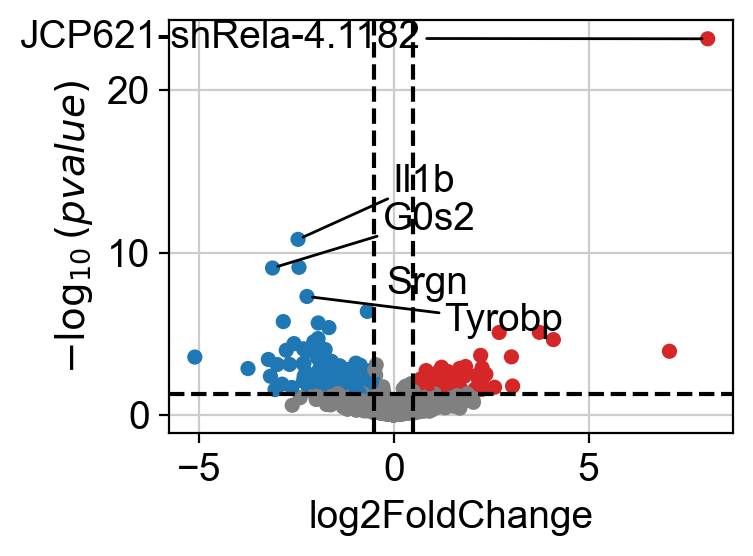

In [108]:
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue")

In [109]:
# check Rela expression
results_df.loc["Rela", ["log2FoldChange", "pvalue", "padj"]]

log2FoldChange   -1.809229
pvalue            0.000400
padj              0.142839
Name: Rela, dtype: float64

In [110]:
# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["Group", "shNfkb1", "shRenilla"], inference=inference)

# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Group shNfkb1 vs shRenilla
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Retreg1   45.264179        0.203360  0.280001  0.726282  0.467666  0.999928
Nploc4    13.721854        0.074304  0.259518  0.286315  0.774637  0.999928
Mrpl46    17.073348        0.217723  0.340576  0.639278  0.522642  0.999928
Yap1      25.548771        0.220890  0.315319  0.700530  0.483597  0.999928
Slc22a17   1.528355        0.339594  1.097201  0.309510  0.756934       NaN
...             ...             ...       ...       ...       ...       ...
Stard4     4.785833       -1.563504  0.644660 -2.425315  0.015295  0.866791
AU021092  27.073545       -0.332388  0.945388 -0.351589  0.725147  0.999928
Kdm2b      7.329514       -0.373170  0.523535 -0.712788  0.475977  0.999928
Plxna4    26.733901       -0.091590  0.622370 -0.147164  0.883003  0.999928
Riox2      8.849333       -0.020525  0.304924 -0.067312  0.946333  0.999928

[10364 rows x 6 column

... done in 0.93 seconds.



In [111]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Retreg1   45.264179        0.203360  0.280001  0.726282  0.467666  0.999928
Nploc4    13.721854        0.074304  0.259518  0.286315  0.774637  0.999928
Mrpl46    17.073348        0.217723  0.340576  0.639278  0.522642  0.999928
Yap1      25.548771        0.220890  0.315319  0.700530  0.483597  0.999928
Slc22a17   1.528355        0.339594  1.097201  0.309510  0.756934       NaN
...             ...             ...       ...       ...       ...       ...
Stard4     4.785833       -1.563504  0.644660 -2.425315  0.015295  0.866791
AU021092  27.073545       -0.332388  0.945388 -0.351589  0.725147  0.999928
Kdm2b      7.329514       -0.373170  0.523535 -0.712788  0.475977  0.999928
Plxna4    26.733901       -0.091590  0.622370 -0.147164  0.883003  0.999928
Riox2      8.849333       -0.020525  0.304924 -0.067312  0.946333  0.999928

[10364 rows x 6 columns]

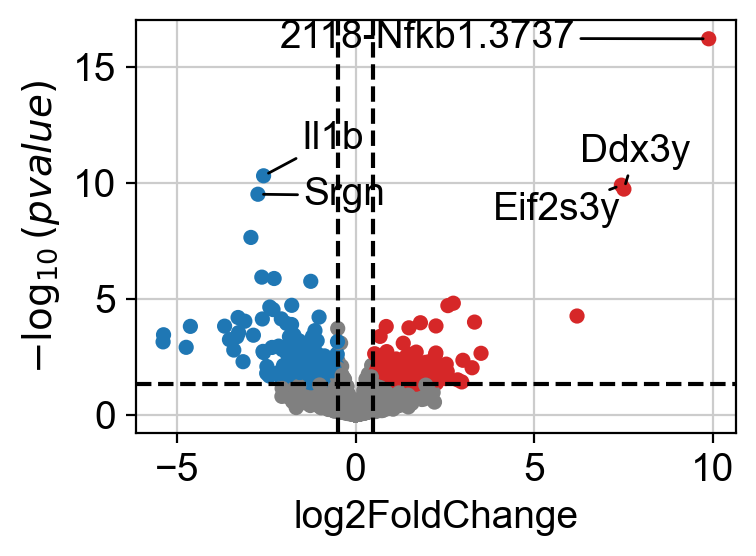

In [112]:
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue")

In [113]:
# check Rela expression
results_df.loc["Nfkb1", ["log2FoldChange", "pvalue", "padj"]]

log2FoldChange   -0.495177
pvalue            0.303757
padj              0.999928
Name: Nfkb1, dtype: float64

In [114]:
# Extract contrast between conditions
stat_res = DeseqStats(dds, contrast=["Group", "shRel", "shRenilla"], inference=inference)

# Compute Wald test
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: Group shRel vs shRenilla
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Retreg1   45.264179        0.041765  0.272737  0.153132  0.878294  0.999707
Nploc4    13.721854        0.330971  0.239479  1.382043  0.166958  0.999707
Mrpl46    17.073348        0.075464  0.329653  0.228920  0.818931  0.999707
Yap1      25.548771        0.007901  0.306883  0.025747  0.979459  0.999707
Slc22a17   1.528355        0.401879  1.054037  0.381276  0.702999  0.999707
...             ...             ...       ...       ...       ...       ...
Stard4     4.785833       -0.739022  0.596369 -1.239204  0.215270  0.999707
AU021092  27.073545       -0.642745  0.929936 -0.691171  0.489458  0.999707
Kdm2b      7.329514       -0.118412  0.498474 -0.237549  0.812231  0.999707
Plxna4    26.733901       -0.038157  0.609190 -0.062636  0.950056  0.999707
Riox2      8.849333        0.011893  0.284083  0.041863  0.966608  0.999707

[10364 rows x 6 columns]

... done in 0.92 seconds.



In [115]:
# Extract results
results_df = stat_res.results_df
results_df

baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Retreg1   45.264179        0.041765  0.272737  0.153132  0.878294  0.999707
Nploc4    13.721854        0.330971  0.239479  1.382043  0.166958  0.999707
Mrpl46    17.073348        0.075464  0.329653  0.228920  0.818931  0.999707
Yap1      25.548771        0.007901  0.306883  0.025747  0.979459  0.999707
Slc22a17   1.528355        0.401879  1.054037  0.381276  0.702999  0.999707
...             ...             ...       ...       ...       ...       ...
Stard4     4.785833       -0.739022  0.596369 -1.239204  0.215270  0.999707
AU021092  27.073545       -0.642745  0.929936 -0.691171  0.489458  0.999707
Kdm2b      7.329514       -0.118412  0.498474 -0.237549  0.812231  0.999707
Plxna4    26.733901       -0.038157  0.609190 -0.062636  0.950056  0.999707
Riox2      8.849333        0.011893  0.284083  0.041863  0.966608  0.999707

[10364 rows x 6 columns]

2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too long, can't fit inside the X axis
2026-01-30 17:09:37 | [WARNING] Some labels are too lo

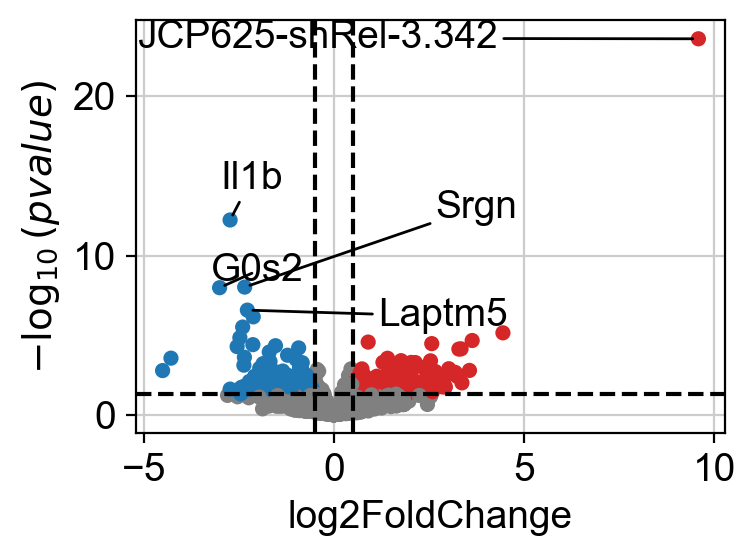

In [116]:
dc.pl.volcano(results_df, x="log2FoldChange", y="pvalue")

In [117]:
# check Rela expression
results_df.loc["Rela", ["log2FoldChange", "pvalue", "padj"]]

log2FoldChange   -0.113096
pvalue            0.825791
padj              0.999707
Name: Rela, dtype: float64

In [118]:
adata.obs.groupby(["Group", "Classification"]).size().unstack(fill_value=0)


Classification  BD1939_B0303  BD1941_B0306  BE1137_B0304  BE1139_B0307  \
Group                                                                    
shRenilla                  0             0             0             0   
shRela                     0           262             0            52   
shNfkb1                   75             0             5             0   
shRel                      0             0             0             0   

Classification  BE1140-NT_B0308  BE1155_(BD1672)_B0302  BE1156_(BD1671)_B0301  \
Group                                                                           
shRenilla                     0                      0                      0   
shRela                      209                      0                      0   
shNfkb1                       0                    122                    196   
shRel                         0                      0                      0   

Classification  BE1157_(BD1674)_B0305  BE1490_B0309  BE1491-NT_B0310  \
Group                                                                  
shRenilla                           0             0                0   
shRela                            400             0                0   
shNfkb1                             0             0                0   
shRel                               0           359              199   

Classification  BE1662_B0311  BF1087_B0313  BF1240_(BE1834)_B0312  
Group                                                              
shRenilla                  0           474                     15  
shRela                     0             0                      0  
shNfkb1                    0             0                      0  
shRel                     82             0                      0

In [119]:
import numpy as np, pandas as pd

x = adata.raw[:, "Nfkb1"].X.toarray().ravel()   # guaranteed length = n_obs
tmp = pd.DataFrame({
    "Group": adata.obs["Group"].to_numpy(),
    "Rep": adata.obs["Classification"].to_numpy(),  # mouse id
    "Nfkb1": x
})

rep_means = tmp.groupby(["Group","Rep"])["Nfkb1"].mean().reset_index()
rep_means

per_mouse = tmp.groupby(["Group","Rep"]).agg(
    mean=("Nfkb1","mean"),
    pct_detected=("Nfkb1", lambda v: (v>0).mean()),
    mean_detected=("Nfkb1", lambda v: v[v>0].mean() if (v>0).any() else np.nan),
    n_cells=("Nfkb1","size")
).reset_index()
per_mouse

Group                    Rep      mean  pct_detected  mean_detected  \
0     shNfkb1           BD1939_B0303  0.285954      0.333333       0.857863   
1     shNfkb1           BE1137_B0304  0.286919      0.200000       1.434597   
2     shNfkb1  BE1155_(BD1672)_B0302  0.446943      0.532787       0.838878   
3     shNfkb1  BE1156_(BD1671)_B0301  0.331959      0.418367       0.793463   
4       shRel           BE1490_B0309  0.408004      0.484680       0.841802   
5       shRel        BE1491-NT_B0310  0.441491      0.542714       0.813488   
6       shRel           BE1662_B0311  0.355060      0.475610       0.746537   
7      shRela           BD1941_B0306  0.286584      0.381679       0.750849   
8      shRela           BE1139_B0307  0.396613      0.461538       0.859329   
9      shRela        BE1140-NT_B0308  0.258830      0.334928       0.772793   
10     shRela  BE1157_(BD1674)_B0305  0.287657      0.350000       0.821877   
11  shRenilla           BF1087_B0313  0.450507      0.552743       0.815040   
12  shRenilla  BF1240_(BE1834)_B0312  0.187511      0.333333       0.562534   

    n_cells  
0        75  
1         5  
2       122  
3       196  
4       359  
5       199  
6        82  
7       262  
8        52  
9       209  
10      400  
11      474  
12       15

In [120]:
per_mouse.groupby("Group")[["mean","pct_detected","mean_detected"]].describe()


mean                                                              \
          count      mean       std       min       25%       50%       75%   
Group                                                                         
shNfkb1     4.0  0.337944  0.075770  0.285954  0.286678  0.309439  0.360705   
shRel       3.0  0.401518  0.043579  0.355060  0.381532  0.408004  0.424747   
shRela      4.0  0.307421  0.060940  0.258830  0.279645  0.287120  0.314896   
shRenilla   2.0  0.319009  0.185966  0.187511  0.253260  0.319009  0.384758   

                    pct_detected            ...                      \
                max        count      mean  ...       75%       max   
Group                                       ...                       
shNfkb1    0.446943          4.0  0.371122  ...  0.446972  0.532787   
shRel      0.441491          3.0  0.501001  ...  0.513697  0.542714   
shRela     0.396613          4.0  0.382037  ...  0.401644  0.461538   
shRenilla  0.450507          2.0  0.443038  ...  0.497890  0.552743   

          mean_detected                                                    \
                  count      mean       std       min       25%       50%   
Group                                                                       
shNfkb1             4.0  0.981200  0.303470  0.793463  0.827524  0.848371   
shRel               3.0  0.800609  0.048921  0.746537  0.780012  0.813488   
shRela              4.0  0.801212  0.048815  0.750849  0.767307  0.797335   
shRenilla           2.0  0.688787  0.178548  0.562534  0.625661  0.688787   

                               
                75%       max  
Group                          
shNfkb1    1.002047  1.434597  
shRel      0.827645  0.841802  
shRela     0.831240  0.859329  
shRenilla  0.751914  0.815040  

[4 rows x 24 columns]

In [121]:
per_mouse.groupby("Group")["n_cells"].describe()


count        mean         std   min     25%    50%     75%    max
Group                                                                       
shNfkb1      4.0   99.500000   80.309817   5.0   57.50   98.5  140.50  196.0
shRel        3.0  213.333333  139.055145  82.0  140.50  199.0  279.00  359.0
shRela       4.0  230.750000  143.813247  52.0  169.75  235.5  296.50  400.0
shRenilla    2.0  244.500000  324.562013  15.0  129.75  244.5  359.25  474.0

In [122]:
rep_means.groupby("Group")["Nfkb1"].agg(["mean","std","count"])


mean       std  count
Group                               
shNfkb1    0.337944  0.075770      4
shRel      0.401518  0.043579      3
shRela     0.307421  0.060940      4
shRenilla  0.319009  0.185966      2

In [123]:
import numpy as np
import pandas as pd

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

def _to_counts_df(adata_sub):
    """Return genes x samples integer counts dataframe from AnnData."""
    X = adata_sub.X
    if hasattr(X, "toarray"):
        X = X.toarray()
    X = np.asarray(X)
    # DESeq expects integers
    if not np.all(np.isfinite(X)):
        raise ValueError("Counts contain non-finite values.")
    # rounding only if you KNOW you have counts; otherwise stop
    if not np.all(np.mod(X, 1) == 0):
        raise ValueError("Counts are not integers. Ensure pdata.X is summed raw counts.")
    # pydeseq2 expects samples x genes as a DataFrame in many examples,
    # but DeseqDataSet(adata=...) accepts AnnData directly.
    return X

def run_deseq_by_leiden(
    pdata,
    leiden_col="leiden",
    group_col="Group",
    mouse_col="Classification",
    ref_group="shRenilla",
    contrast_group="shRela",
    gene_of_interest="Rela",
    gene_set=None,
    min_mice_per_group=3,
    min_cells_per_pseudobulk=None,  # set e.g. 50 if you have pdata.obs["n_cells"]
):
    rows = []
    gene_set = gene_set or []

    # optional cell-count filter
    ad = pdata
    if min_cells_per_pseudobulk is not None and "n_cells" in ad.obs.columns:
        ad = ad[ad.obs["n_cells"].astype(int) >= int(min_cells_per_pseudobulk)].copy()

    for k in sorted(ad.obs[leiden_col].unique(), key=lambda x: str(x)):
        sub = ad[ad.obs[leiden_col] == k].copy()

        # mice per group in this state
        mice_by_group = (
            sub.obs[[group_col, mouse_col]]
            .drop_duplicates()
            .groupby(group_col)[mouse_col]
            .nunique()
            .to_dict()
        )

        n_ref = int(mice_by_group.get(ref_group, 0))
        n_con = int(mice_by_group.get(contrast_group, 0))

        # skip underpowered states
        if n_ref < min_mice_per_group or n_con < min_mice_per_group:
            rows.append({
                "leiden": k,
                "status": "skipped_low_mice",
                "n_mice_ref": n_ref,
                "n_mice_contrast": n_con,
                "ref_group": ref_group,
                "contrast_group": contrast_group,
            })
            continue

        # sanity: counts integer?
        _ = _to_counts_df(sub)

        # run DESeq2 for this state
        dds = DeseqDataSet(
            adata=sub,
            design_factors=[group_col],
            refit_cooks=True,
        )
        dds.deseq2()

        stat = DeseqStats(
            dds,
            contrast=[group_col, contrast_group, ref_group],
        )
        stat.summary()
        res = stat.results_df.copy()  # index = genes

        # Pull gene of interest
        if gene_of_interest in res.index:
            goi = res.loc[gene_of_interest]
            goi_lfc = float(goi["log2FoldChange"])
            goi_p = float(goi["pvalue"])
            goi_padj = float(goi["padj"]) if pd.notnull(goi["padj"]) else np.nan
            goi_stat = float(goi["stat"])
        else:
            goi_lfc = goi_p = goi_padj = goi_stat = np.nan

        # Summarize NFkB gene set using DESeq2 stats (directional)
        gs = [g for g in gene_set if g in res.index]
        if len(gs) > 0:
            # Use mean(stat) as a stable directional summary; also record mean(log2FC)
            nfkb_stat_mean = float(np.nanmean(res.loc[gs, "stat"].values))
            nfkb_lfc_mean = float(np.nanmean(res.loc[gs, "log2FoldChange"].values))
            nfkb_n_genes = int(len(gs))
        else:
            nfkb_stat_mean = nfkb_lfc_mean = np.nan
            nfkb_n_genes = 0

        rows.append({
            "leiden": k,
            "status": "ok",
            "n_mice_ref": n_ref,
            "n_mice_contrast": n_con,
            "ref_group": ref_group,
            "contrast_group": contrast_group,
            "gene": gene_of_interest,
            "gene_log2FC": goi_lfc,
            "gene_stat": goi_stat,
            "gene_p": goi_p,
            "gene_padj": goi_padj,
            "nfkb_genes_used": nfkb_n_genes,
            "nfkb_stat_mean": nfkb_stat_mean,
            "nfkb_log2FC_mean": nfkb_lfc_mean,
        })

    out = pd.DataFrame(rows)

    # Nice ordering for reading
    out["leiden"] = out["leiden"].astype(str)
    out = out.sort_values(["status", "leiden"], ascending=[True, True]).reset_index(drop=True)
    return out


In [124]:
tidy_hp2 = run_deseq_by_leiden(
    pdata=pdata,
    ref_group="shRenilla",
    contrast_group="shRela",
    gene_of_interest="Rela",
    gene_set=hallmark_nfkb,
    min_mice_per_group=3,
    min_cells_per_pseudobulk=20,  # set None if you don't have n_cells or don't want filtering
)
tidy_hp2


leiden            status  n_mice_ref  n_mice_contrast  ref_group  \
0      0  skipped_low_mice           1                3  shRenilla   
1      1  skipped_low_mice           1                4  shRenilla   
2      2  skipped_low_mice           1                4  shRenilla   
3      3  skipped_low_mice           1                3  shRenilla   
4      5  skipped_low_mice           1                0  shRenilla   
5      6  skipped_low_mice           1                0  shRenilla   

  contrast_group  
0         shRela  
1         shRela  
2         shRela  
3         shRela  
4         shRela  
5         shRela

In [125]:
adata.n_obs, adata.raw.n_obs


(2450, 2450)

In [126]:
x = adata.raw[:, "Rela"].X
type(x), x.shape


(scipy.sparse._csr.csr_matrix, (2450, 1))

In [127]:
adata.obs.shape[0], adata.X.shape[0]


(2450, 2450)

## Calculate phenotypic volume

In [128]:
#Phenotypic Volume
def calcPV(matrix):
    if hasattr(matrix, 'toarray'):
        matrix = matrix.toarray()
    
    matrix = np.asarray(matrix, dtype=np.float64)
    gene_cov = np.cov(matrix.T)
    mat = pd.DataFrame(gene_cov)
    eig_vals = np.linalg.eigvalsh(mat)
    return(sum(np.log2(eig_vals[eig_vals > 0])))

In [129]:
from scipy.stats import mannwhitneyu

In [130]:
repeats = 1000

In [131]:
adata.obs['Group'].value_counts()

Group
shRela       923
shRel        640
shRenilla    489
shNfkb1      398
Name: count, dtype: int64

In [132]:
matrix = adata[adata.obs['Group'].isin(['shRenilla']),adata.var['highly_variable']].X.copy()
dist1 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist1.append(calcPV(matrix[sample_id]))

In [133]:
matrix = adata[adata.obs['Group'].isin(['shRela']),adata.var['highly_variable']].X.copy()
dist2 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist2.append(calcPV(matrix[sample_id]))

In [134]:
matrix = adata[adata.obs['Group'].isin(['shNfkb1']),adata.var['highly_variable']].X.copy()
dist3 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist3.append(calcPV(matrix[sample_id]))

In [135]:
matrix = adata[adata.obs['Group'].isin(['shRel']),adata.var['highly_variable']].X.copy()
dist4 = []
for x in range(0,repeats):
    sample_id = np.random.choice(matrix.shape[0],100)
    dist4.append(calcPV(matrix[sample_id]))

2026-01-30 17:12:35 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-30 17:12:35 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


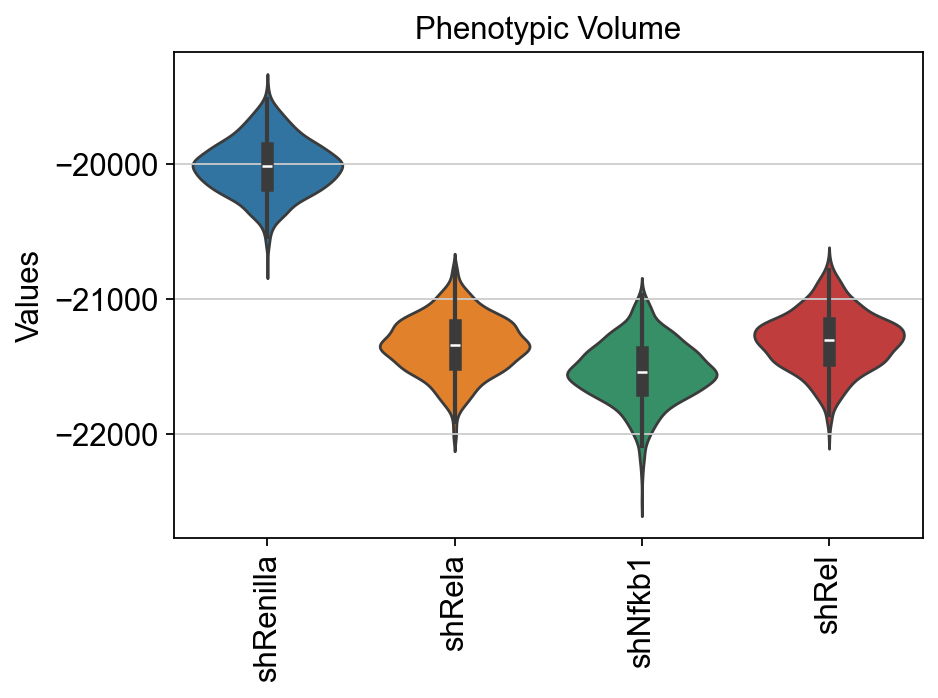

In [136]:
import seaborn as sns
data = [dist1, dist2, dist3, dist4]
labels = ["shRenilla", "shRela", "shNfkb1", "shRel"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1, 2, 3], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.show()

## Figures for the paper

### Look within the whole tumor

2026-01-30 17:12:35 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-30 17:12:35 | [INFO] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


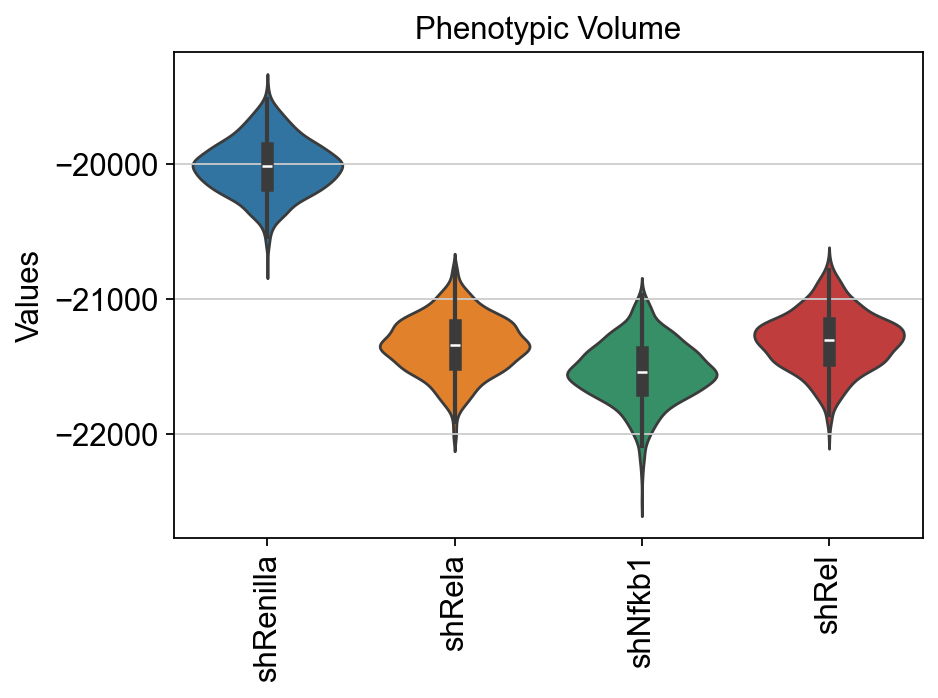

In [137]:
import seaborn as sns
data = [dist1, dist2, dist3, dist4]
labels = ["shRenilla", "shRela", "shNfkb1", "shRel"]

# Create violin plot using Seaborn
plt.figure(figsize=(6, 4))
sns.violinplot(data=data)
plt.xticks(ticks=[0, 1, 2, 3], labels=labels, rotation=90)
plt.ylabel("Values")
plt.title("Phenotypic Volume")
plt.savefig('figures/shNfkbComponents_PV.svg')
plt.show()

### Look within HPCS

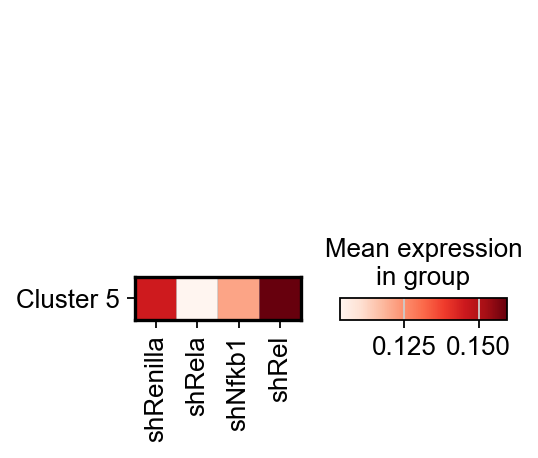

In [138]:
sc.pl.matrixplot(adata, ['Cluster 5'], groupby='Group',cmap='Reds',swap_axes=True,save='Fig_1l_shComponents.svg')

In [139]:
import scipy
scipy.stats.ttest_ind(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shRela']),:].obs['Cluster 5'])

TtestResult(statistic=np.float64(6.013067654418185), pvalue=np.float64(2.3152240543605044e-09), df=np.float64(1410.0))

In [140]:
import scipy
scipy.stats.ttest_ind(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shNfkb1']),:].obs['Cluster 5'])

TtestResult(statistic=np.float64(2.71302089290761), pvalue=np.float64(0.006796771352773002), df=np.float64(885.0))

In [141]:
import scipy
scipy.stats.ttest_ind(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shRel']),:].obs['Cluster 5'])

TtestResult(statistic=np.float64(-1.8110898224665588), pvalue=np.float64(0.07039310280116842), df=np.float64(1127.0))

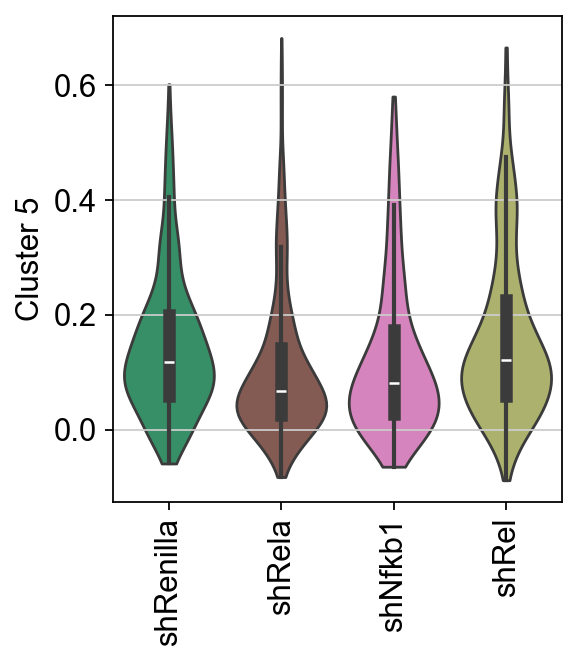

In [142]:
sc.pl.violin(adata, 'Cluster 5', 'Group', inner='box', rotation=90, stripplot=False, save='Ext_Data_Fig3c.svg')

In [143]:
import scipy
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shRela']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(283934.0), pvalue=np.float64(1.3317864398552126e-15))

In [144]:
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shNfkb1']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(113721.0), pvalue=np.float64(1.5324025865929045e-05))

In [145]:
scipy.stats.mannwhitneyu(adata[adata.obs.Group.isin(['shRenilla']),:].obs['Cluster 5'],
                        adata[adata.obs.Group.isin(['shRel']),:].obs['Cluster 5'])

MannwhitneyuResult(statistic=np.float64(152308.0), pvalue=np.float64(0.44223710021687435))

In [146]:
#gseapy.dotplot(enr0.res2d,title="%s shRela Up" % gsets,cmap="RdBu_r",ofname='figures/shRela_HallmarkUp_Enrichr.svg')
gseapy.dotplot(enr1.res2d,title="%s shRela Down" % gsets,cmap="RdBu_r",ofname='figures/Ext_Data_Fig3d_shRela_HallmarkDown_Enrichr.svg')
#gseapy.dotplot(enr2.res2d,title="%s shNfkb1 Up" % gsets,cmap="RdBu_r",ofname='figures/shNfkb1_HallmarkUp_Enrichr.svg')
#gseapy.dotplot(enr3.res2d,title="%s shNfkb1 Down" % gsets,cmap="RdBu_r",ofname='figures/shNfkb1_HallmarkDown_Enrichr.svg')
#gseapy.dotplot(enr4.res2d,title="%s shRel Up" % gsets,cmap="RdBu_r",ofname='figures/shRel_HallmarkUp_Enrichr.svg')
gseapy.dotplot(enr5.res2d,title="%s shRel Down" % gsets,cmap="RdBu_r",ofname='figures/Ext_Data_Fig3f_shRel_HallmarkDown_Enrichr.svg')